# Recommendation system for restaurants
### Based on the [Yelp Dataset](https://www.kaggle.com/yelp-dataset/yelp-dataset).  

## 0. Libraries
First of all, we define all the libraries we need.

In [1]:
from matplotlib.ticker import PercentFormatter as _PercentFormatter
import matplotlib.pyplot as _plt
import numpy as _np
import pandas as _pd
import joblib as _jl
import glob as _glob
import os as _os
import re as _re
import time as _time
from multiprocessing import Pool as _Pool
from sklearn.preprocessing import OrdinalEncoder as _OrdinalEncoder
from sklearn.metrics import confusion_matrix as _confusion_matrix, roc_curve as _roc_curve, classification_report as _classification_report, accuracy_score as _accuracy_score
from sklearn.model_selection import GridSearchCV as _GridSearchCV
from sklearn.svm import LinearSVC as _LinearSVC
from sklearn.metrics.pairwise import cosine_similarity as _cosine_similarity
from sklearn.ensemble import RandomForestClassifier

_pd.set_option('display.max_columns', None)

Since we are going to use big datasets, and we'll need to load them more
times, we define a commodity function that deletes all user defined variables,
in order to free some memory.

In [2]:
def _del_all():
    %reset_selective -f [^_]

## 1. Data cleaning
### Based on [Ashish Gandhe's kernel](https://www.kaggle.com/wenqihou828/recommendation-for-yelp-users-itself).

We execute the code in ```recommendation_system_preprocessing.ipynb``` in order to
clean the data and to reduce the size of the dataset, using pickles instead of json and dropping unnecessary columns.

We explore the resulting datasets: 

In [5]:
dataset_list = _glob.glob("../dataset/[!checked]*.pickle")
for d in dataset_list:
    dataset = _pd.read_pickle(d)
    
    f = _os.path.splitext(_os.path.basename(d))[0]
    c = ", ".join(list(dataset.columns))
    s = dataset.shape
    
    print("Dataset '" + f + "':")
    print("\tfeatures:", c)
    print("\tshape:", s)
    print()

Dataset 'all_checkin':
	features: business_id, date
	shape: (57402, 2)

Dataset 'all_review':
	features: review_id, user_id, business_id, stars, useful, funny, cool, text, date
	shape: (4201684, 9)

Dataset 'all_tips':
	features: restaurant_name, tips_date, user_id
	shape: (770878, 3)

Dataset 'all_users':
	features: user_id, user_name, average_stars, yelping_since, review, years_of_elite, fans, useful, cool, funny, friends
	shape: (1148098, 11)

Dataset 'restaurants':
	features: name, business_id, address, cuisine, postal_code, latitude, longitude, review_count, stars, OutdoorSeating, BusinessAcceptsCreditCards, RestaurantsDelivery, RestaurantsReservations, WiFi, Alcohol, categories, city, Monday_Open, Tuesday_Open, Wednesday_Open, Thursday_Open, Friday_Open, Saturday_Open, Sunday_Open, Monday_Close, Tuesday_Close, Wednesday_Close, Thursday_Close, Friday_Close, Saturday_Close, Sunday_Close
	shape: (59371, 31)



In [10]:
_del_all()

## 2. Fake Review Detection
### Based on Zhiwei Zhang's [work](https://medium.com/@zhiwei_zhang/final-blog-642fb9c7e781) and [code](https://github.com/zzhang83/Yelp_Sentiment_Analysis).

Then, in order to filter out deceptive reviews, that could alter the results
of our analysis, we load the model based on Support Vector Machine
defined in ```Yelp_sentiment_analysis/Scripts/fake_reviews.ipynb```
by [Zhiwei Zhang](https://medium.com/@zhiwei_zhang/final-blog-642fb9c7e781),
that has the best scores for accuracy, precision, recall and f1-score.

In [2]:
vectorizer = _jl.load('../models/tfidf_vectorizer.joblib')
svc = _jl.load('../models/fake_review_svc_model.joblib')

Now, we can apply this model to our data.

In [4]:
review = _pd.read_pickle("../dataset/all_review.pickle")

review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
3,yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5,0,0,0,Went in for a lunch. Steak sandwich was delici...,2018-01-09 20:56:38
5,fdiNeiN_hoCxCMy2wTRW9g,w31MKYsNFMrjhWxxAb5wIw,eU_713ec6fTGNO4BegRaww,4,0,0,0,I'll be the first to admit that I was not exci...,2013-01-20 13:25:59
6,G7XHMxG0bx9oBJNECG4IFg,jlu4CztcSxrKx56ba1a5AQ,3fw2X5bZYeW9xCz_zGhOHg,3,5,4,5,Tracy dessert had a big name in Hong Kong and ...,2016-05-07 01:21:02
7,8e9HxxLjjqc9ez5ezzN7iQ,d6xvYpyzcfbF_AZ8vMB7QA,zvO-PJCpNk4fgAVUnExYAA,1,3,1,1,This place has gone down hill. Clearly they h...,2010-10-05 19:12:35
10,kbtscdyz6lvrtGjD1quQTg,FIk4lQQu1eTe2EpzQ4xhBA,8mIrX_LrOnAqWsB5JrOojQ,4,0,0,0,"Like walking back in time, every Saturday morn...",2011-11-30 02:11:15


In [5]:
texts = list(review["text"])
X = vectorizer.transform(texts)
predictions = svc.predict(X)

In [6]:
print(type(predictions))
print("SVC predictions:", predictions)

<class 'numpy.ndarray'>
SVC predictions: [1 1 1 ... 1 1 1]


Now we repeat the whole process with a different model that allows us to
obtain real weights instead of a binary evaluation. 

In [7]:
cal_svc = _jl.load('../models/fake_review_cal_svc_model.joblib')
cal_predictions = cal_svc.predict_proba(X)


In [8]:
print("Calibrated SVC predictions:\n", cal_predictions)
cal_predictions = _np.array([x[1] for x in cal_predictions])
print("Calibrated SVC predictions for class '1':\n", cal_predictions)

Calibrated SVC predictions:
 [[0.12112422 0.87887578]
 [0.011      0.989     ]
 [0.03538102 0.96461898]
 ...
 [0.36147536 0.63852464]
 [0.00379598 0.99620402]
 [0.00133685 0.99866315]]
Calibrated SVC predictions for class '1':
 [0.87887578 0.989      0.96461898 ... 0.63852464 0.99620402 0.99866315]


In [9]:
print("columns before:\n", review.columns)
checked_review = review.assign(bin_truth_score=predictions, real_truth_score=cal_predictions)
print("columns after:\n", checked_review.columns)

columns before:
 Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')
columns after:
 Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date', 'bin_truth_score', 'real_truth_score'],
      dtype='object')


Let's see what we just obtained.

In [10]:
checked_review[['review_id', 'text', 'bin_truth_score', 'real_truth_score']].head()

,review_id,text,bin_truth_score,real_truth_score
3,yi0R0Ugj_xUx_Nek0-_Qig,Went in for a lunch. Steak sandwich was delici...,1,0.878876
5,fdiNeiN_hoCxCMy2wTRW9g,I'll be the first to admit that I was not exci...,1,0.989000
6,G7XHMxG0bx9oBJNECG4IFg,Tracy dessert had a big name in Hong Kong and ...,1,0.964619
7,8e9HxxLjjqc9ez5ezzN7iQ,This place has gone down hill. Clearly they h...,1,0.867897
10,kbtscdyz6lvrtGjD1quQTg,"Like walking back in time, every Saturday morn...",1,0.975404


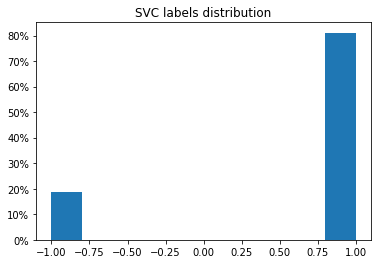

In [11]:
data = checked_review['bin_truth_score']
_plt.hist(data, weights=_np.ones(len(data)) / len(data))
_plt.title("SVC labels distribution")
_plt.gca().yaxis.set_major_formatter(_PercentFormatter(1))
_plt.show()

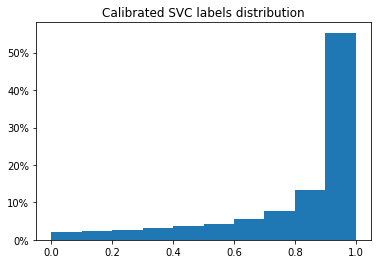

In [12]:
data = checked_review['real_truth_score']
_plt.hist(data, weights=_np.ones(len(data)) / len(data))
_plt.title("Calibrated SVC labels distribution")
_plt.gca().yaxis.set_major_formatter(_PercentFormatter(1))
_plt.show()

Finally, we can save the new dataset without the ```text``` column,
in order to save space and computation time.  

In [17]:
checked_review.drop(columns=['text'], inplace=True)
checked_review.to_pickle('../dataset/checked_review.pickle')

Check that everything has worked properly. 

In [18]:
final_review = _pd.read_pickle('../dataset/checked_review.pickle')
print(final_review.columns)
final_review.head()

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'date', 'bin_truth_score', 'real_truth_score'],
      dtype='object')


,review_id,user_id,business_id,stars,useful,funny,cool,date,bin_truth_score,real_truth_score
3,yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5,0,0,0,2018-01-09 20:56:38,1,0.878876
5,fdiNeiN_hoCxCMy2wTRW9g,w31MKYsNFMrjhWxxAb5wIw,eU_713ec6fTGNO4BegRaww,4,0,0,0,2013-01-20 13:25:59,1,0.989000
6,G7XHMxG0bx9oBJNECG4IFg,jlu4CztcSxrKx56ba1a5AQ,3fw2X5bZYeW9xCz_zGhOHg,3,5,4,5,2016-05-07 01:21:02,1,0.964619
7,8e9HxxLjjqc9ez5ezzN7iQ,d6xvYpyzcfbF_AZ8vMB7QA,zvO-PJCpNk4fgAVUnExYAA,1,3,1,1,2010-10-05 19:12:35,1,0.867897
10,kbtscdyz6lvrtGjD1quQTg,FIk4lQQu1eTe2EpzQ4xhBA,8mIrX_LrOnAqWsB5JrOojQ,4,0,0,0,2011-11-30 02:11:15,1,0.975404


In [ ]:
_del_all()

## 3. Historical features

Following [this paper](https://www.semanticscholar.org/paper/Restaurant-Recommendation-System-Gandhe/093cecc3e53f2ba4c0c466ad3d8294ba64962050),
we add some historical features to our dataset:
1. user-level features:
    <br>1.1. average of the ratings given by a certain user,
    <br>1.2. number of reviews written by a certain user,
2. business-level features:
    <br>2.1. average of the ratings given to a certain restaurant,
    <br>2.2. number of reviews written about a certain restaurant,
3. user-business features:
    <br>3.1. average rating given by a certain user to each category,
    <br>3.2. average of the ratings given by a certain user to the categories of a certain restaurant.

Before proceeding with the computation of the new features, we have to split the dataset in three parts:
1. <i>Test set</i>, from the last day considered in the dataset, to the previous `M` months;
2. <i>Training set</i>, from the day before the beginning of the test set, up to `N` months before;
3. <i>History</i>, the remaining part of the dataset, used to compute historical features.

For the moment, we pick `m=2` and `n=9`, so the test set goes from 10/1/2018 to 11/30/2018,
the training set goes from 1/1/2018 to 9/30/2018, the history contains the remaining data,
from 10/12/2004 to 12/31/2017.

In [5]:
review_all = _pd.read_pickle("../dataset/checked_review.pickle")
review_test = review_all[review_all['date']>=_np.datetime64('2018-09-01')]
review_train = review_all[(review_all['date']>=_np.datetime64('2018-01-01')) & (review_all['date']<_np.datetime64('2018-09-01'))]
# review_hist = review_all[review_all['date']<_np.datetime64('2018-01-01')]

review_test.to_pickle('../dataset/m2_n9/review_test.pickle')
review_train.to_pickle('../dataset/m2_n9/review_train.pickle')
# review_hist.to_pickle('../dataset/m2_n9/review_hist.pickle')

In [13]:
tips_all = _pd.read_pickle("../dataset/all_tips.pickle")
tips_test = tips_all[tips_all['tips_date']>=_np.datetime64('2018-10-01')]
tips_train = tips_all[(tips_all['tips_date']>=_np.datetime64('2018-01-01')) & (tips_all['tips_date']<_np.datetime64('2018-10-01'))]
tips_hist = tips_all[tips_all['tips_date']<_np.datetime64('2018-01-01')]

tips_test.to_pickle('../dataset/m2_n9/tips_test.pickle')
tips_train.to_pickle('../dataset/m2_n9/tips_train.pickle')
tips_hist.to_pickle('../dataset/m2_n9/tips_hist.pickle')

In [18]:
_del_all()

### User-level features

In [3]:
review_hist = _pd.read_pickle('../dataset/m2_n9/review_hist.pickle')
users = _pd.read_pickle("../dataset/all_users.pickle")

In [8]:
avg_stars = review_hist['stars'].mean()

users = users.assign(average_stars=avg_stars)
users = users.assign(num_reviews=0)
users = users.assign(average_stars_bin=avg_stars)
users = users.assign(num_reviews_bin=0)
users = users.assign(average_stars_real=avg_stars)
users = users.assign(num_reviews_real=0)
users = users.set_index('user_id')
users.head()

,user_name,average_stars,yelping_since,review,years_of_elite,fans,useful,cool,funny,friends,num_reviews,average_stars_bin,num_reviews_bin,average_stars_real,num_reviews_real
user_id,,,,,,,,,,,,,,,
l6BmjZMeQD3rDxWUbiAiow,Rashmi,3.703313,2013-10-08,95,3,5,84,25,17,2374,0,3.703313,0,3.703313,0
4XChL029mKr5hydo79Ljxg,Jenna,3.703313,2013-02-21,33,0,4,48,16,22,27646,0,3.703313,0,3.703313,0
bc8C_eETBWL0olvFSJJd0w,David,3.703313,2013-10-04,16,0,0,28,10,8,358,0,3.703313,0,3.703313,0
dD0gZpBctWGdWo9WlGuhlA,Angela,3.703313,2014-05-22,17,0,5,30,14,4,12598,0,3.703313,0,3.703313,0
MM4RJAeH6yuaN8oZDSt0RA,Nancy,3.703313,2013-10-23,361,4,39,1114,665,279,5542,0,3.703313,0,3.703313,0


In [3]:
def _f(grouped):
    d = {}
    
    d['num'] = grouped['stars'].size
    d['stars'] = grouped['stars'].mean()
    
    non_fake = _np.ma.masked_where(grouped['bin_truth_score']<0, grouped['stars']).compressed()
    d['num_bin'] = non_fake.size
    d['stars_bin'] = non_fake.mean()
    
    d['num_real'] = grouped['real_truth_score'].sum()
    d['stars_real'] = _np.average(grouped['stars'], weights=grouped['real_truth_score'])
    
    return _pd.Series(d, index=['num', 'stars', 'num_bin', 'stars_bin', 'num_real', 'stars_real'])

In [ ]:
grouped_reviews = review_hist.groupby('user_id').apply(_f)
grouped_reviews.head()

In [18]:
import random
import statistics

current_milli_time = lambda: int(round(_time.time() * 1000))

def get_time(df):
    us_id = random.choice(grouped_reviews.index)
    x = random.randrange(1000)
    t = current_milli_time()
    df.loc[us_id, ["test"]] = x
    t0 = current_milli_time()
    return t0-t

def get_time_mul(df):
    us_id = random.choice(grouped_reviews.index)
    x = random.randrange(1000)
    y = random.randrange(1000)
    z = random.randrange(1000)
    t = current_milli_time()
    df.loc[us_id, ["test", "ciao", "prova"]] = [x, y, z]
    t0 = current_milli_time()
    return t0-t

def test():
    df = users.copy()
    df['test'] = -1
    times = []
    for i in range(1000):
         times += [get_time(df)]
    avg_time = statistics.mean(times)
    del df
    return avg_time

def test_mul():
    df = users.copy()
    df['test'] = -1
    df['ciao'] = -1
    df['prova'] = -1
    times = []
    for i in range(1000):
         times += [get_time(df)]
    avg_time = statistics.mean(times)
    del df
    return avg_time

def tot_time(ops, x, k):
    time_millis = ops * k * x
    hours = time_millis/1000/60/60
    return hours

tot = len(grouped_reviews)
x = test()
print("hours:", tot_time(tot, x, 6))
x = test_mul()
print("hours mul:", tot_time(tot, x, 1))

hours: 53.065662455
hours mul: 8.774814544166667


In [9]:
count = 1
tot = len(grouped_reviews)
print("tot:", tot)

for index, row in grouped_reviews.iterrows():
    uid = index
    num = row['num']
    stars = row['stars']
    num_bin = row['num_bin']
    stars_bin = row['stars_bin']
    num_real = row['num_real']
    stars_real = row['stars_real']
    
    cols = ["num_reviews", "average_stars", "num_reviews_bin",
            "average_stars_bin", "num_reviews_real", "average_stars_real"]
    vals = [num, stars, num_bin, stars_bin, num_real, stars_real]
    users.loc[uid, cols] = vals
    
    count += 1
    if count % 1000 == 0:
        percent = (count/tot)*100
        print("row {}/{} - {}%".format(count, tot, percent))

tot: 954447
row 1000/954447 - 0.10477271131870078%
row 2000/954447 - 0.20954542263740156%
row 3000/954447 - 0.31431813395610236%
row 4000/954447 - 0.4190908452748031%
row 5000/954447 - 0.5238635565935038%
row 6000/954447 - 0.6286362679122047%
row 7000/954447 - 0.7334089792309054%
row 8000/954447 - 0.8381816905496062%
row 9000/954447 - 0.942954401868307%
row 10000/954447 - 1.0477271131870076%
row 11000/954447 - 1.1524998245057085%
row 12000/954447 - 1.2572725358244095%
row 13000/954447 - 1.3620452471431101%
row 14000/954447 - 1.4668179584618108%
row 15000/954447 - 1.5715906697805118%
row 16000/954447 - 1.6763633810992125%
row 17000/954447 - 1.7811360924179132%
row 18000/954447 - 1.885908803736614%
row 19000/954447 - 1.9906815150553148%
row 20000/954447 - 2.0954542263740152%
row 21000/954447 - 2.2002269376927166%
row 22000/954447 - 2.304999649011417%
row 23000/954447 - 2.409772360330118%
row 24000/954447 - 2.514545071648819%
row 25000/954447 - 2.6193177829675194%
row 26000/954447 - 2.724

In [10]:
users = users.reset_index()
users.to_pickle('../dataset/m2_n9/users.pickle')
_del_all()

### Business-level features

In [4]:
restaurants = _pd.read_pickle("../dataset/restaurants.pickle")
review_hist = _pd.read_pickle('../dataset/m2_n9/review_hist.pickle')
avg_stars = review_hist['stars'].mean()

In [5]:
restaurants = restaurants.assign(average_stars=avg_stars)
restaurants = restaurants.assign(num_reviews=0)
restaurants = restaurants.assign(average_stars_bin=avg_stars)
restaurants = restaurants.assign(num_reviews_bin=0)
restaurants = restaurants.assign(average_stars_real=avg_stars)
restaurants = restaurants.assign(num_reviews_real=0)
restaurants = restaurants.set_index('business_id')
restaurants.head()

,name,address,cuisine,postal_code,latitude,longitude,review_count,stars,OutdoorSeating,BusinessAcceptsCreditCards,...,Thursday_Close,Friday_Close,Saturday_Close,Sunday_Close,average_stars,num_reviews,average_stars_bin,num_reviews_bin,average_stars_real,num_reviews_real
business_id,,,,,,,,,,,,,,,,,,,,,
QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Chinese,L5R 3E7,43.605499,-79.652289,128,2.5,False,NaN,...,00:00:00,01:00:00,01:00:00,00:00:00,3.703313,0,3.703313,0,3.703313,0
gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Japanese,28210,35.092564,-80.859132,170,4.0,False,True,...,21:30:00,22:00:00,22:00:00,21:00:00,3.703313,0,3.703313,0,3.703313,0
1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,2450 E Indian School Rd,Mexican,85016,33.495194,-112.028588,18,3.0,False,True,...,01:00:00,01:00:00,01:00:00,00:00:00,3.703313,0,3.703313,0,3.703313,0
fweCYi8FmbJXHCqLnwuk8w,Marco's Pizza,5981 Andrews Rd,Italian,44060,41.708520,-81.359556,16,4.0,False,True,...,00:00:00,01:00:00,01:00:00,00:00:00,3.703313,0,3.703313,0,3.703313,0
PZ-LZzSlhSe9utkQYU8pFg,Carluccio's Tivoli Gardens,"1775 E Tropicana Ave, Ste 29",Italian,89119,36.100016,-115.128529,40,4.0,False,True,...,NaT,NaT,NaT,NaT,3.703313,0,3.703313,0,3.703313,0


In [6]:
grouped_reviews = review_hist.groupby('business_id').apply(_f)
grouped_reviews.head()

C:\Users\super\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\super\Anaconda3\envs\tf-gpu\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,num,stars,num_bin,stars_bin,num_real,stars_real
business_id,,,,,,
--1UhMGODdWsrMastO9DZw,22.0,4.227273,14.0,4.214286,16.978214,4.267477
--6MefnULPED_I942VcFNA,38.0,3.157895,32.0,3.218750,33.948759,3.218815
--9e1ONYQuAa-CB_Rrw7Tw,1504.0,4.107048,1216.0,4.088816,1205.738732,4.092415
--DaPTJW3-tB1vP-PfdTEg,40.0,3.650000,33.0,3.575758,34.780500,3.642790
--FBCX-N37CMYDfs790Bnw,122.0,3.737705,90.0,3.611111,93.369750,3.646290


In [7]:
count = 1
tot = len(grouped_reviews)
print("tot:", tot)

for index, row in grouped_reviews.iterrows():
    uid = index
    num = row['num']
    stars = row['stars']
    num_bin = row['num_bin']
    stars_bin = row['stars_bin']
    num_real = row['num_real']
    stars_real = row['stars_real']
    
    cols = ["num_reviews", "average_stars", "num_reviews_bin",
            "average_stars_bin", "num_reviews_real", "average_stars_real"]
    vals = [num, stars, num_bin, stars_bin, num_real, stars_real]
    restaurants.loc[uid, cols] = vals
    
    count += 1
    if count % 1000 == 0:
        percent = (count/tot)*100
        print("row {}/{} - {}%".format(count, tot, percent))

tot: 56850
row 1000/56850 - 1.759014951627089%
row 2000/56850 - 3.518029903254178%
row 3000/56850 - 5.277044854881266%
row 4000/56850 - 7.036059806508356%
row 5000/56850 - 8.795074758135444%
row 6000/56850 - 10.554089709762533%
row 7000/56850 - 12.313104661389621%
row 8000/56850 - 14.072119613016712%
row 9000/56850 - 15.8311345646438%
row 10000/56850 - 17.590149516270888%
row 11000/56850 - 19.349164467897978%
row 12000/56850 - 21.108179419525065%
row 13000/56850 - 22.867194371152156%
row 14000/56850 - 24.626209322779243%
row 15000/56850 - 26.385224274406333%
row 16000/56850 - 28.144239226033424%
row 17000/56850 - 29.90325417766051%
row 18000/56850 - 31.6622691292876%
row 19000/56850 - 33.42128408091469%
row 20000/56850 - 35.180299032541775%
row 21000/56850 - 36.93931398416886%
row 22000/56850 - 38.698328935795956%
row 23000/56850 - 40.45734388742304%
row 24000/56850 - 42.21635883905013%
row 25000/56850 - 43.97537379067722%
row 26000/56850 - 45.73438874230431%
row 27000/56850 - 47.49340

In [8]:
restaurants = restaurants.reset_index()
restaurants.to_pickle('../dataset/m2_n9/restaurants.pickle')
_del_all()


### User - Business level features

#### 3.1. average rating given by a certain user to each category

In [2]:
restaurants = _pd.read_pickle('../dataset/m2_n9/restaurants.pickle')
restaurants.head()

,business_id,name,address,cuisine,postal_code,latitude,longitude,review_count,stars,OutdoorSeating,...,Thursday_Close,Friday_Close,Saturday_Close,Sunday_Close,average_stars,num_reviews,average_stars_bin,num_reviews_bin,average_stars_real,num_reviews_real
0,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Chinese,L5R 3E7,43.605499,-79.652289,128,2.5,False,...,00:00:00,01:00:00,01:00:00,00:00:00,2.726496,117.0,2.718750,96.0,2.730197,95.873087
1,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Japanese,28210,35.092564,-80.859132,170,4.0,False,...,21:30:00,22:00:00,22:00:00,21:00:00,4.063291,158.0,4.094203,138.0,4.067541,139.112078
2,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,2450 E Indian School Rd,Mexican,85016,33.495194,-112.028588,18,3.0,False,...,01:00:00,01:00:00,01:00:00,00:00:00,3.125000,16.0,2.769231,13.0,2.847327,12.604125
3,fweCYi8FmbJXHCqLnwuk8w,Marco's Pizza,5981 Andrews Rd,Italian,44060,41.708520,-81.359556,16,4.0,False,...,00:00:00,01:00:00,01:00:00,00:00:00,4.230769,13.0,4.166667,12.0,4.142021,10.965903
4,PZ-LZzSlhSe9utkQYU8pFg,Carluccio's Tivoli Gardens,"1775 E Tropicana Ave, Ste 29",Italian,89119,36.100016,-115.128529,40,4.0,False,...,NaT,NaT,NaT,NaT,4.097561,41.0,4.212121,33.0,4.167159,33.655622


In [5]:
restaurants.columns

Index(['business_id', 'name', 'address', 'cuisine', 'postal_code', 'latitude',
       'longitude', 'review_count', 'stars', 'OutdoorSeating',
       'BusinessAcceptsCreditCards', 'RestaurantsDelivery',
       'RestaurantsReservations', 'WiFi', 'Alcohol', 'categories', 'city',
       'Monday_Open', 'Tuesday_Open', 'Wednesday_Open', 'Thursday_Open',
       'Friday_Open', 'Saturday_Open', 'Sunday_Open', 'Monday_Close',
       'Tuesday_Close', 'Wednesday_Close', 'Thursday_Close', 'Friday_Close',
       'Saturday_Close', 'Sunday_Close', 'average_stars', 'num_reviews',
       'average_stars_bin', 'num_reviews_bin', 'average_stars_real',
       'num_reviews_real'],
      dtype='object')

In [3]:
review_hist = _pd.read_pickle('../dataset/m2_n9/review_hist.pickle')
review_hist.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date,bin_truth_score,real_truth_score
5,fdiNeiN_hoCxCMy2wTRW9g,w31MKYsNFMrjhWxxAb5wIw,eU_713ec6fTGNO4BegRaww,4,0,0,0,2013-01-20 13:25:59,1,0.989000
6,G7XHMxG0bx9oBJNECG4IFg,jlu4CztcSxrKx56ba1a5AQ,3fw2X5bZYeW9xCz_zGhOHg,3,5,4,5,2016-05-07 01:21:02,1,0.964619
7,8e9HxxLjjqc9ez5ezzN7iQ,d6xvYpyzcfbF_AZ8vMB7QA,zvO-PJCpNk4fgAVUnExYAA,1,3,1,1,2010-10-05 19:12:35,1,0.867897
10,kbtscdyz6lvrtGjD1quQTg,FIk4lQQu1eTe2EpzQ4xhBA,8mIrX_LrOnAqWsB5JrOojQ,4,0,0,0,2011-11-30 02:11:15,1,0.975404
11,-I5umRTkhw15RqpKMl_o1Q,-mA3-1mN4JIEkqOtdbNXCQ,mRUVMJkUGxrByzMQ2MuOpA,1,0,1,0,2017-12-15 23:27:08,1,0.972826


In [4]:
joined_reviews = review_hist.join(restaurants.set_index('business_id'), on = 'business_id', lsuffix='_review', rsuffix='_rest')
joined_reviews.head()

,review_id,user_id,business_id,stars_review,useful,funny,cool,date,bin_truth_score,real_truth_score,...,Thursday_Close,Friday_Close,Saturday_Close,Sunday_Close,average_stars,num_reviews,average_stars_bin,num_reviews_bin,average_stars_real,num_reviews_real
5,fdiNeiN_hoCxCMy2wTRW9g,w31MKYsNFMrjhWxxAb5wIw,eU_713ec6fTGNO4BegRaww,4,0,0,0,2013-01-20 13:25:59,1,0.989000,...,22:00:00,23:00:00,23:00:00,NaT,3.642276,123.0,3.594059,101.0,3.596369,99.505441
6,G7XHMxG0bx9oBJNECG4IFg,jlu4CztcSxrKx56ba1a5AQ,3fw2X5bZYeW9xCz_zGhOHg,3,5,4,5,2016-05-07 01:21:02,1,0.964619,...,00:00:00,02:00:00,02:00:00,00:00:00,3.292453,106.0,3.320000,100.0,3.289493,94.480786
7,8e9HxxLjjqc9ez5ezzN7iQ,d6xvYpyzcfbF_AZ8vMB7QA,zvO-PJCpNk4fgAVUnExYAA,1,3,1,1,2010-10-05 19:12:35,1,0.867897,...,22:00:00,23:00:00,23:00:00,23:00:00,2.655172,29.0,2.875000,24.0,2.727490,23.413530
10,kbtscdyz6lvrtGjD1quQTg,FIk4lQQu1eTe2EpzQ4xhBA,8mIrX_LrOnAqWsB5JrOojQ,4,0,0,0,2011-11-30 02:11:15,1,0.975404,...,23:00:00,00:00:00,00:00:00,23:00:00,4.491259,1144.0,4.499535,1075.0,4.502904,1031.313358
11,-I5umRTkhw15RqpKMl_o1Q,-mA3-1mN4JIEkqOtdbNXCQ,mRUVMJkUGxrByzMQ2MuOpA,1,0,1,0,2017-12-15 23:27:08,1,0.972826,...,00:00:00,02:00:00,02:00:00,00:00:00,3.666667,12.0,3.833333,6.0,3.650460,7.482296


In [8]:
categories = ', '.join(list(restaurants['categories'].unique()))
categories = categories.split(', ')
print(len(categories))

cat = []
for h in categories:
    if h not in cat:
        cat.append(h)
        
print(len(cat))

cuisines = ', '.join(list(restaurants['cuisine'].unique()))
cuisines = cuisines.split(', ')
print(len(cuisines))

_cuisines_unique = []
for cuisine in cuisines:
    if not cuisine in _cuisines_unique:
        _cuisines_unique.append(cuisine)
        
print("Number of cuisines: {0}".format(len(_cuisines_unique)))
print(_cuisines_unique)

173884
761
249
Number of cuisines: 10
['Chinese', 'Japanese', 'Mexican', 'Italian', 'Others', 'American', 'Korean', 'Mediterranean', 'Thai', 'Asian Fusion']


In [5]:
joined_reviews.to_pickle('../dataset/m2_n9/join_restaurants_reviewhist.pickle')

In [ ]:
_del_all()

Checkpoint

In [ ]:
joined_reviews =  _pd.read_pickle('../dataset/m2_n9/join_restaurants_reviewhist.pickle')
joined_reviews.head()

,index,review_id,user_id,business_id,stars_review,useful,funny,cool,date,bin_truth_score,...,Thursday_Close,Friday_Close,Saturday_Close,Sunday_Close,average_stars,num_reviews,average_stars_bin,num_reviews_bin,average_stars_real,num_reviews_real
0,5,fdiNeiN_hoCxCMy2wTRW9g,w31MKYsNFMrjhWxxAb5wIw,eU_713ec6fTGNO4BegRaww,4,0,0,0,2013-01-20 13:25:59,1,...,22:00:00,23:00:00,23:00:00,NaT,3.642276,123.0,3.594059,101.0,3.596369,99.505441
1,6,G7XHMxG0bx9oBJNECG4IFg,jlu4CztcSxrKx56ba1a5AQ,3fw2X5bZYeW9xCz_zGhOHg,3,5,4,5,2016-05-07 01:21:02,1,...,00:00:00,02:00:00,02:00:00,00:00:00,3.292453,106.0,3.320000,100.0,3.289493,94.480786
2,7,8e9HxxLjjqc9ez5ezzN7iQ,d6xvYpyzcfbF_AZ8vMB7QA,zvO-PJCpNk4fgAVUnExYAA,1,3,1,1,2010-10-05 19:12:35,1,...,22:00:00,23:00:00,23:00:00,23:00:00,2.655172,29.0,2.875000,24.0,2.727490,23.413530
3,10,kbtscdyz6lvrtGjD1quQTg,FIk4lQQu1eTe2EpzQ4xhBA,8mIrX_LrOnAqWsB5JrOojQ,4,0,0,0,2011-11-30 02:11:15,1,...,23:00:00,00:00:00,00:00:00,23:00:00,4.491259,1144.0,4.499535,1075.0,4.502904,1031.313358
4,11,-I5umRTkhw15RqpKMl_o1Q,-mA3-1mN4JIEkqOtdbNXCQ,mRUVMJkUGxrByzMQ2MuOpA,1,0,1,0,2017-12-15 23:27:08,1,...,00:00:00,02:00:00,02:00:00,00:00:00,3.666667,12.0,3.833333,6.0,3.650460,7.482296


In [ ]:
# joined_reviews = joined_reviews.reset_index()
joined_reviews = joined_reviews[['review_id', 'user_id', 'business_id', 'bin_truth_score', 'real_truth_score', 'cuisine', 'stars_review']]
joined_reviews.head()

,review_id,user_id,business_id,bin_truth_score,real_truth_score,cuisine,stars_review
0,fdiNeiN_hoCxCMy2wTRW9g,w31MKYsNFMrjhWxxAb5wIw,eU_713ec6fTGNO4BegRaww,1,0.989000,Italian,4
1,G7XHMxG0bx9oBJNECG4IFg,jlu4CztcSxrKx56ba1a5AQ,3fw2X5bZYeW9xCz_zGhOHg,1,0.964619,Chinese,3
2,8e9HxxLjjqc9ez5ezzN7iQ,d6xvYpyzcfbF_AZ8vMB7QA,zvO-PJCpNk4fgAVUnExYAA,1,0.867897,American,1
3,kbtscdyz6lvrtGjD1quQTg,FIk4lQQu1eTe2EpzQ4xhBA,8mIrX_LrOnAqWsB5JrOojQ,1,0.975404,Others,4
4,-I5umRTkhw15RqpKMl_o1Q,-mA3-1mN4JIEkqOtdbNXCQ,mRUVMJkUGxrByzMQ2MuOpA,1,0.972826,American,1


In [ ]:
#cuisines_unique = ['Chinese', 'Japanese', 'Mexican', 'Italian', 'Others', 'American', 'Korean', 'Mediterranean', 'Thai', 'Asian Fusion']

In [ ]:
def each_cuisine_ratings(grouped):
    d = {}
    index = []
    for cuisine in _cuisines_unique:
        cuisine_av = cuisine + "_av"
        cuisine_records = _np.ma.masked_where(~grouped['cuisine'].str.contains(cuisine), grouped['stars_review']).compressed()
        d[cuisine_av] = cuisine_records.mean()
        index.append(cuisine_av)
    # print("cuisine_av done")
        
    for cuisine in _cuisines_unique:
        cuisine_av_bin = cuisine + "_av_bin"
        #non_fake = _np.ma.masked_where(grouped['bin_truth_score'] < 0, grouped).compressed()
        non_fake = grouped[grouped['bin_truth_score'] > 0]
        cuisine_records = _np.ma.masked_where(~non_fake['cuisine'].str.contains(cuisine), non_fake['stars_review']).compressed()
        d[cuisine_av_bin] = cuisine_records.mean()
        index.append(cuisine_av_bin)
    # print("cuisine_av_bin done")
    
    for cuisine in _cuisines_unique:
        cuisine_av_real = cuisine + "_av_real"
        cuisine_records = _np.ma.masked_where(~grouped['cuisine'].str.contains(cuisine), grouped['stars_review']).compressed()
        cuisine_truth_score = _np.ma.masked_where(~grouped['cuisine'].str.contains(cuisine), grouped['real_truth_score']).compressed()
        d[cuisine_av_real] = _np.ma.average(cuisine_records, weights = cuisine_truth_score)
        index.append(cuisine_av_real)
    # print("cuisine_av_real done")
    
    return _pd.Series(d, index = index)
    

In [ ]:
grouped_reviews = joined_reviews.groupby('user_id').apply(each_cuisine_ratings)

C:\Users\super\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  
C:\Users\super\Anaconda3\envs\tf-gpu\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\super\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice.
C:\Users\super\Anaconda3\envs\tf-gpu\lib\site-packages\numpy\ma\extras.py:607: RuntimeWarning: invalid value encountered in double_scalars
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


In [ ]:
grouped_reviews.head()

,Chinese_av,Japanese_av,Mexican_av,Italian_av,Others_av,American_av,Korean_av,Mediterranean_av,Thai_av,Asian Fusion_av,...,Chinese_av_real,Japanese_av_real,Mexican_av_real,Italian_av_real,Others_av_real,American_av_real,Korean_av_real,Mediterranean_av_real,Thai_av_real,Asian Fusion_av_real
user_id,,,,,,,,,,,,,,,,,,,,,
---1lKK3aKOuomHnwAkAow,NaN,2.333333,3.666667,3.166667,4.352941,3.9375,4.0,NaN,3.25,3.5,...,NaN,2.035809,3.720609,3.226154,4.524134,3.963953,4.0,NaN,3.134858,3.443446
---PLwSf5gKdIoVnyRHgBA,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,NaN
---cu1hq55BP9DWVXXKHZg,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
---udAKDsn0yQXmzbWQNSw,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,4.00,NaN,...,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,4.000000,NaN
--0RtXvcOIE4XbErYca6Rw,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN


Checkpoint 2

In [3]:
users = _pd.read_pickle('../dataset/m2_n9/users.pickle')
users.head()

,user_id,user_name,average_stars,yelping_since,review,years_of_elite,fans,useful,cool,funny,friends,num_reviews,average_stars_bin,num_reviews_bin,average_stars_real,num_reviews_real
0,l6BmjZMeQD3rDxWUbiAiow,Rashmi,3.000000,2013-10-08,95,3,5,84,25,17,2374,2.0,3.000000,2.0,3.017247,1.957334
1,4XChL029mKr5hydo79Ljxg,Jenna,3.500000,2013-02-21,33,0,4,48,16,22,27646,12.0,3.777778,9.0,3.626019,9.280533
2,bc8C_eETBWL0olvFSJJd0w,David,3.384615,2013-10-04,16,0,0,28,10,8,358,13.0,3.500000,12.0,3.326528,10.350275
3,dD0gZpBctWGdWo9WlGuhlA,Angela,5.000000,2014-05-22,17,0,5,30,14,4,12598,1.0,NaN,0.0,5.000000,0.329341
4,MM4RJAeH6yuaN8oZDSt0RA,Nancy,4.400000,2013-10-23,361,4,39,1114,665,279,5542,5.0,4.400000,5.0,4.378799,4.720870


In [4]:
users = users.assign(av_rat_chinese_cuisine = _np.nan, av_rat_japanese_cuisine = _np.nan, av_rat_mexican_cuisine = _np.nan, 
                     av_rat_italian_cuisine = _np.nan, av_rat_others_cuisine = _np.nan, av_rat_american_cuisine = _np.nan, 
                     av_rat_korean_cuisine = _np.nan, av_rat_mediterranean_cuisine = _np.nan, av_rat_thai_cuisine = _np.nan, 
                     av_rat_asianfusion_cuisine = _np.nan)

users = users.assign(av_rat_chinese_cuisine_bin = _np.nan, av_rat_japanese_cuisine_bin = _np.nan, av_rat_mexican_cuisine_bin = _np.nan, 
                     av_rat_italian_cuisine_bin = _np.nan, av_rat_others_cuisine_bin = _np.nan, av_rat_american_cuisine_bin = _np.nan, 
                     av_rat_korean_cuisine_bin = _np.nan, av_rat_mediterranean_cuisine_bin = _np.nan, av_rat_thai_cuisine_bin = _np.nan, 
                     av_rat_asianfusion_cuisine_bin = _np.nan)

users = users.assign(av_rat_chinese_cuisine_real = _np.nan, av_rat_japanese_cuisine_real = _np.nan, av_rat_mexican_cuisine_real = _np.nan, 
                     av_rat_italian_cuisine_real = _np.nan, av_rat_others_cuisine_real = _np.nan, av_rat_american_cuisine_real = _np.nan, 
                     av_rat_korean_cuisine_real = _np.nan, av_rat_mediterranean_cuisine_real = _np.nan, av_rat_thai_cuisine_real = _np.nan, 
                     av_rat_asianfusion_cuisine_real = _np.nan)

users = users.set_index('user_id')

In [5]:
users.head()

,user_name,average_stars,yelping_since,review,years_of_elite,fans,useful,cool,funny,friends,...,av_rat_chinese_cuisine_real,av_rat_japanese_cuisine_real,av_rat_mexican_cuisine_real,av_rat_italian_cuisine_real,av_rat_others_cuisine_real,av_rat_american_cuisine_real,av_rat_korean_cuisine_real,av_rat_mediterranean_cuisine_real,av_rat_thai_cuisine_real,av_rat_asianfusion_cuisine_real
user_id,,,,,,,,,,,,,,,,,,,,,
l6BmjZMeQD3rDxWUbiAiow,Rashmi,3.000000,2013-10-08,95,3,5,84,25,17,2374,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4XChL029mKr5hydo79Ljxg,Jenna,3.500000,2013-02-21,33,0,4,48,16,22,27646,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bc8C_eETBWL0olvFSJJd0w,David,3.384615,2013-10-04,16,0,0,28,10,8,358,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dD0gZpBctWGdWo9WlGuhlA,Angela,5.000000,2014-05-22,17,0,5,30,14,4,12598,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MM4RJAeH6yuaN8oZDSt0RA,Nancy,4.400000,2013-10-23,361,4,39,1114,665,279,5542,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
grouped_reviews = _pd.read_pickle('../dataset/m2_n9/grouped_reviews.pickle')
grouped_reviews.head()

,Chinese_av,Japanese_av,Mexican_av,Italian_av,Others_av,American_av,Korean_av,Mediterranean_av,Thai_av,Asian Fusion_av,...,Chinese_av_real,Japanese_av_real,Mexican_av_real,Italian_av_real,Others_av_real,American_av_real,Korean_av_real,Mediterranean_av_real,Thai_av_real,Asian Fusion_av_real
user_id,,,,,,,,,,,,,,,,,,,,,
---1lKK3aKOuomHnwAkAow,NaN,2.333333,3.666667,3.166667,4.352941,3.9375,4.0,NaN,3.25,3.5,...,NaN,2.035809,3.720609,3.226154,4.524134,3.963953,4.0,NaN,3.134858,3.443446
---PLwSf5gKdIoVnyRHgBA,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,NaN
---cu1hq55BP9DWVXXKHZg,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
---udAKDsn0yQXmzbWQNSw,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,4.00,NaN,...,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,4.000000,NaN
--0RtXvcOIE4XbErYca6Rw,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN


In [8]:
# split grouped_reviews and users datasets into n_cores parts, where n_cores is the number of available processors
n_cores = _os.cpu_count()

df_out = _np.array_split(users, n_cores)   # list of input dataframes (from users)

df_out_names = []   # list of paths of output dataframes (from grouped_reviews)
df_in = []
for i, df in enumerate(df_out):
    name = "../dataset/m2_n9/tmp/df_out_" + str(i) + ".pickle"
    df_out_names += [name]
    
    df_tmp = grouped_reviews.loc[df.index]
    df_in += [df_tmp]

C:\Users\super\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  if sys.path[0] == '':


In [9]:
from multiproc_utils import user_business_features

if __name__ ==  '__main__':
    with _Pool(processes=n_cores) as p:
        p.map(user_business_features, zip(df_in, df_out, df_out_names))

In [10]:
users_chunks = []

# add chunks produced by subprocesses
for name in df_out_names:
    df_out_i = _pd.read_pickle(name)
    users_chunks += [df_out_i]
    _os.remove(name)

users = _pd.concat(users_chunks)
users.head()

,user_name,average_stars,yelping_since,review,years_of_elite,fans,useful,cool,funny,friends,...,av_rat_chinese_cuisine_real,av_rat_japanese_cuisine_real,av_rat_mexican_cuisine_real,av_rat_italian_cuisine_real,av_rat_others_cuisine_real,av_rat_american_cuisine_real,av_rat_korean_cuisine_real,av_rat_mediterranean_cuisine_real,av_rat_thai_cuisine_real,av_rat_asianfusion_cuisine_real
user_id,,,,,,,,,,,,,,,,,,,,,
l6BmjZMeQD3rDxWUbiAiow,Rashmi,3.000000,2013-10-08,95,3,5,84,25,17,2374,...,NaN,NaN,NaN,4.0,2.0,4.000000,NaN,NaN,NaN,NaN
4XChL029mKr5hydo79Ljxg,Jenna,3.500000,2013-02-21,33,0,4,48,16,22,27646,...,NaN,NaN,NaN,NaN,4.0,3.501823,NaN,4.0,NaN,NaN
bc8C_eETBWL0olvFSJJd0w,David,3.384615,2013-10-04,16,0,0,28,10,8,358,...,3.399765,NaN,2.0,NaN,5.0,3.123598,NaN,3.0,3.632007,1.997225
dD0gZpBctWGdWo9WlGuhlA,Angela,5.000000,2014-05-22,17,0,5,30,14,4,12598,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000
MM4RJAeH6yuaN8oZDSt0RA,Nancy,4.400000,2013-10-23,361,4,39,1114,665,279,5542,...,NaN,NaN,NaN,NaN,NaN,4.450279,NaN,5.0,3.000000,5.000000


In [11]:
users = users.reset_index()
users.to_pickle('../dataset/m2_n9/users_2.pickle')

In [12]:
users.shape

(1148098, 46)

In [13]:
users_pre = _pd.read_pickle("../dataset/m2_n9/users.pickle")
users_pre.shape

(1148098, 16)

In [4]:
len(grouped_reviews)

954447

In [7]:
print("expected diff:", users.shape[0]-len(grouped_reviews))

expected diff: 193651


In [8]:
users_tmp = users[['av_rat_chinese_cuisine', 'av_rat_japanese_cuisine', 'av_rat_mexican_cuisine', 'av_rat_italian_cuisine', 
            'av_rat_others_cuisine', 'av_rat_american_cuisine', 'av_rat_korean_cuisine', 'av_rat_mediterranean_cuisine',
            'av_rat_thai_cuisine', 'av_rat_asianfusion_cuisine',
           
           'av_rat_chinese_cuisine_bin', 'av_rat_japanese_cuisine_bin', 'av_rat_mexican_cuisine_bin', 
           'av_rat_italian_cuisine_bin', 'av_rat_others_cuisine_bin', 'av_rat_american_cuisine_bin', 
           'av_rat_korean_cuisine_bin', 'av_rat_mediterranean_cuisine_bin', 'av_rat_thai_cuisine_bin', 
           'av_rat_asianfusion_cuisine_bin',
           
           'av_rat_chinese_cuisine_real', 'av_rat_japanese_cuisine_real', 'av_rat_mexican_cuisine_real', 
           'av_rat_italian_cuisine_real', 'av_rat_others_cuisine_real', 'av_rat_american_cuisine_real', 
           'av_rat_korean_cuisine_real', 'av_rat_mediterranean_cuisine_real', 'av_rat_thai_cuisine_real', 
           'av_rat_asianfusion_cuisine_real']]

count_na = 0
for i, r in users_tmp.iterrows():
        if r.isna().all():
            count_na += 1

print("actual diff:", count_na)

actual diff: 193651


In [4]:
_del_all()

#### 3.2. Average of the ratings given by a certain user to the categories of a certain restaurant.

##### 3.2.1 Test set

In [3]:
review_test = _pd.read_pickle('../dataset/m2_n9/review_test.pickle')
review_test = review_test.sort_values(by=['review_id'])
review_test = review_test.reset_index(drop = True)
review_test.shape

(153993, 10)

In [4]:
review_test.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date,bin_truth_score,real_truth_score
0,---j05qHS2X7FkXjjMKKtA,E6Aoz-3s4avfweIjziHjbA,cTbFJzHQzFSX-z3JF4abKQ,5,1,0,1,2018-11-02 15:01:11,-1,0.229833
1,--4GjusuUCMh24c_oh_cEg,YOOsYiXGEtGFX_wSeZNcww,JytR7WvKyytDQNwOHUzSEg,4,1,0,0,2018-10-13 00:07:17,1,0.987487
2,--4RpVT5wHJ9AfnZkIC3tw,Bdw4E8jFVd6-CbhrNAJ_EA,-CfFjcCcGGDM9MVH_d42RQ,5,0,0,0,2018-10-14 04:41:42,-1,0.524751
3,--4vJzoC0m5h-yodXv-qCw,jm4a1GghQ4zLCN3lQGMQUQ,XMPBg6r_LqZhy9Cf-4ZJrA,2,0,0,0,2018-11-01 19:11:50,1,0.979875
4,--B9JxEb5gY5gAgD2BRhDQ,x_6VdQU3CIdakwHod-dNzA,Fn_IxcCtZl1EoS81sq_s9w,3,1,0,0,2018-10-31 02:01:04,1,0.662471


In [5]:
restaurants = _pd.read_pickle('../dataset/m2_n9/restaurants.pickle')
restaurants = restaurants.reset_index(drop = True)
restaurants = restaurants[['cuisine', 'business_id']]
restaurants.head()

,cuisine,business_id
0,Chinese,QXAEGFB4oINsVuTFxEYKFQ
1,Japanese,gnKjwL_1w79qoiV3IC_xQQ
2,Mexican,1Dfx3zM-rW4n-31KeC8sJg
3,Italian,fweCYi8FmbJXHCqLnwuk8w
4,Italian,PZ-LZzSlhSe9utkQYU8pFg


In [6]:
review_test_rest = review_test.join(restaurants.set_index('business_id'), on = 'business_id')
review_test_rest.to_pickle('../dataset/m2_n9/review_test_cuisine.pickle')
review_test_rest.shape

(153993, 11)

In [7]:
review_test_rest.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date,bin_truth_score,real_truth_score,cuisine
0,---j05qHS2X7FkXjjMKKtA,E6Aoz-3s4avfweIjziHjbA,cTbFJzHQzFSX-z3JF4abKQ,5,1,0,1,2018-11-02 15:01:11,-1,0.229833,American
1,--4GjusuUCMh24c_oh_cEg,YOOsYiXGEtGFX_wSeZNcww,JytR7WvKyytDQNwOHUzSEg,4,1,0,0,2018-10-13 00:07:17,1,0.987487,Others
2,--4RpVT5wHJ9AfnZkIC3tw,Bdw4E8jFVd6-CbhrNAJ_EA,-CfFjcCcGGDM9MVH_d42RQ,5,0,0,0,2018-10-14 04:41:42,-1,0.524751,Mediterranean
3,--4vJzoC0m5h-yodXv-qCw,jm4a1GghQ4zLCN3lQGMQUQ,XMPBg6r_LqZhy9Cf-4ZJrA,2,0,0,0,2018-11-01 19:11:50,1,0.979875,Others
4,--B9JxEb5gY5gAgD2BRhDQ,x_6VdQU3CIdakwHod-dNzA,Fn_IxcCtZl1EoS81sq_s9w,3,1,0,0,2018-10-31 02:01:04,1,0.662471,Italian


In [8]:
del restaurants

users = _pd.read_pickle('../dataset/m2_n9/users_2.pickle')
users.head()

,user_id,user_name,average_stars,yelping_since,review,years_of_elite,fans,useful,cool,funny,friends,num_reviews,average_stars_bin,num_reviews_bin,average_stars_real,num_reviews_real,av_rat_chinese_cuisine,av_rat_japanese_cuisine,av_rat_mexican_cuisine,av_rat_italian_cuisine,av_rat_others_cuisine,av_rat_american_cuisine,av_rat_korean_cuisine,av_rat_mediterranean_cuisine,av_rat_thai_cuisine,av_rat_asianfusion_cuisine,av_rat_chinese_cuisine_bin,av_rat_japanese_cuisine_bin,av_rat_mexican_cuisine_bin,av_rat_italian_cuisine_bin,av_rat_others_cuisine_bin,av_rat_american_cuisine_bin,av_rat_korean_cuisine_bin,av_rat_mediterranean_cuisine_bin,av_rat_thai_cuisine_bin,av_rat_asianfusion_cuisine_bin,av_rat_chinese_cuisine_real,av_rat_japanese_cuisine_real,av_rat_mexican_cuisine_real,av_rat_italian_cuisine_real,av_rat_others_cuisine_real,av_rat_american_cuisine_real,av_rat_korean_cuisine_real,av_rat_mediterranean_cuisine_real,av_rat_thai_cuisine_real,av_rat_asianfusion_cuisine_real
0,l6BmjZMeQD3rDxWUbiAiow,Rashmi,3.000000,2013-10-08,95,3,5,84,25,17,2374,2.0,3.000000,2.0,3.017247,1.957334,NaN,NaN,NaN,4.0,2.0,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2.0,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2.0,4.000000,NaN,NaN,NaN,NaN
1,4XChL029mKr5hydo79Ljxg,Jenna,3.500000,2013-02-21,33,0,4,48,16,22,27646,12.0,3.777778,9.0,3.626019,9.280533,NaN,NaN,NaN,NaN,4.0,3.333333,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.666667,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.501823,NaN,4.0,NaN,NaN
2,bc8C_eETBWL0olvFSJJd0w,David,3.384615,2013-10-04,16,0,0,28,10,8,358,13.0,3.500000,12.0,3.326528,10.350275,3.5,NaN,2.0,NaN,5.0,3.000000,NaN,3.0,3.666667,2.0,3.5,NaN,2.0,NaN,5.0,3.500000,NaN,3.0,3.666667,2.0,3.399765,NaN,2.0,NaN,5.0,3.123598,NaN,3.0,3.632007,1.997225
3,dD0gZpBctWGdWo9WlGuhlA,Angela,5.000000,2014-05-22,17,0,5,30,14,4,12598,1.0,NaN,0.0,5.000000,0.329341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000
4,MM4RJAeH6yuaN8oZDSt0RA,Nancy,4.400000,2013-10-23,361,4,39,1114,665,279,5542,5.0,4.400000,5.0,4.378799,4.720870,NaN,NaN,NaN,NaN,NaN,4.500000,NaN,5.0,3.000000,5.0,NaN,NaN,NaN,NaN,NaN,4.500000,NaN,5.0,3.000000,5.0,NaN,NaN,NaN,NaN,NaN,4.450279,NaN,5.0,3.000000,5.000000


In [9]:
users = users[['user_id', 'av_rat_chinese_cuisine', 'av_rat_japanese_cuisine', 'av_rat_mexican_cuisine', 'av_rat_italian_cuisine', 
            'av_rat_others_cuisine', 'av_rat_american_cuisine', 'av_rat_korean_cuisine', 'av_rat_mediterranean_cuisine',
            'av_rat_thai_cuisine', 'av_rat_asianfusion_cuisine',
           
           'av_rat_chinese_cuisine_bin', 'av_rat_japanese_cuisine_bin', 'av_rat_mexican_cuisine_bin', 
           'av_rat_italian_cuisine_bin', 'av_rat_others_cuisine_bin', 'av_rat_american_cuisine_bin', 
           'av_rat_korean_cuisine_bin', 'av_rat_mediterranean_cuisine_bin', 'av_rat_thai_cuisine_bin', 
           'av_rat_asianfusion_cuisine_bin',
           
           'av_rat_chinese_cuisine_real', 'av_rat_japanese_cuisine_real', 'av_rat_mexican_cuisine_real', 
           'av_rat_italian_cuisine_real', 'av_rat_others_cuisine_real', 'av_rat_american_cuisine_real', 
           'av_rat_korean_cuisine_real', 'av_rat_mediterranean_cuisine_real', 'av_rat_thai_cuisine_real', 
           'av_rat_asianfusion_cuisine_real']]

users.head()

,user_id,av_rat_chinese_cuisine,av_rat_japanese_cuisine,av_rat_mexican_cuisine,av_rat_italian_cuisine,av_rat_others_cuisine,av_rat_american_cuisine,av_rat_korean_cuisine,av_rat_mediterranean_cuisine,av_rat_thai_cuisine,av_rat_asianfusion_cuisine,av_rat_chinese_cuisine_bin,av_rat_japanese_cuisine_bin,av_rat_mexican_cuisine_bin,av_rat_italian_cuisine_bin,av_rat_others_cuisine_bin,av_rat_american_cuisine_bin,av_rat_korean_cuisine_bin,av_rat_mediterranean_cuisine_bin,av_rat_thai_cuisine_bin,av_rat_asianfusion_cuisine_bin,av_rat_chinese_cuisine_real,av_rat_japanese_cuisine_real,av_rat_mexican_cuisine_real,av_rat_italian_cuisine_real,av_rat_others_cuisine_real,av_rat_american_cuisine_real,av_rat_korean_cuisine_real,av_rat_mediterranean_cuisine_real,av_rat_thai_cuisine_real,av_rat_asianfusion_cuisine_real
0,l6BmjZMeQD3rDxWUbiAiow,NaN,NaN,NaN,4.0,2.0,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2.0,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2.0,4.000000,NaN,NaN,NaN,NaN
1,4XChL029mKr5hydo79Ljxg,NaN,NaN,NaN,NaN,4.0,3.333333,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.666667,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.501823,NaN,4.0,NaN,NaN
2,bc8C_eETBWL0olvFSJJd0w,3.5,NaN,2.0,NaN,5.0,3.000000,NaN,3.0,3.666667,2.0,3.5,NaN,2.0,NaN,5.0,3.500000,NaN,3.0,3.666667,2.0,3.399765,NaN,2.0,NaN,5.0,3.123598,NaN,3.0,3.632007,1.997225
3,dD0gZpBctWGdWo9WlGuhlA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000
4,MM4RJAeH6yuaN8oZDSt0RA,NaN,NaN,NaN,NaN,NaN,4.500000,NaN,5.0,3.000000,5.0,NaN,NaN,NaN,NaN,NaN,4.500000,NaN,5.0,3.000000,5.0,NaN,NaN,NaN,NaN,NaN,4.450279,NaN,5.0,3.000000,5.000000


In [10]:
test_join = review_test_rest.join(users.set_index('user_id'), on = 'user_id', lsuffix = '_test_revirew', rsuffix = '_users')
test_join.shape

(153993, 41)

In [11]:
test_join.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date,bin_truth_score,real_truth_score,cuisine,av_rat_chinese_cuisine,av_rat_japanese_cuisine,av_rat_mexican_cuisine,av_rat_italian_cuisine,av_rat_others_cuisine,av_rat_american_cuisine,av_rat_korean_cuisine,av_rat_mediterranean_cuisine,av_rat_thai_cuisine,av_rat_asianfusion_cuisine,av_rat_chinese_cuisine_bin,av_rat_japanese_cuisine_bin,av_rat_mexican_cuisine_bin,av_rat_italian_cuisine_bin,av_rat_others_cuisine_bin,av_rat_american_cuisine_bin,av_rat_korean_cuisine_bin,av_rat_mediterranean_cuisine_bin,av_rat_thai_cuisine_bin,av_rat_asianfusion_cuisine_bin,av_rat_chinese_cuisine_real,av_rat_japanese_cuisine_real,av_rat_mexican_cuisine_real,av_rat_italian_cuisine_real,av_rat_others_cuisine_real,av_rat_american_cuisine_real,av_rat_korean_cuisine_real,av_rat_mediterranean_cuisine_real,av_rat_thai_cuisine_real,av_rat_asianfusion_cuisine_real
0,---j05qHS2X7FkXjjMKKtA,E6Aoz-3s4avfweIjziHjbA,cTbFJzHQzFSX-z3JF4abKQ,5,1,0,1,2018-11-02 15:01:11,-1,0.229833,American,NaN,4.00,NaN,4.500,3.444444,4.000000,NaN,NaN,NaN,4.0,NaN,4.00,NaN,4.500,3.444444,4.285714,NaN,NaN,NaN,4.0,NaN,4.000000,NaN,4.508384,3.446572,3.969038,NaN,NaN,NaN,4.102936
1,--4GjusuUCMh24c_oh_cEg,YOOsYiXGEtGFX_wSeZNcww,JytR7WvKyytDQNwOHUzSEg,4,1,0,0,2018-10-13 00:07:17,1,0.987487,Others,3.75,3.75,4.0,3.625,3.604167,3.230769,2.0,4.4,3.666667,3.0,3.75,3.75,4.666667,3.625,3.607143,3.333333,2.0,4.25,3.666667,3.0,3.756843,3.726028,4.287215,3.525072,3.610109,3.170261,2.0,4.355007,3.664197,3.021022
2,--4RpVT5wHJ9AfnZkIC3tw,Bdw4E8jFVd6-CbhrNAJ_EA,-CfFjcCcGGDM9MVH_d42RQ,5,0,0,0,2018-10-14 04:41:42,-1,0.524751,Mediterranean,NaN,NaN,1.0,NaN,5.000000,5.000000,NaN,5.0,NaN,NaN,NaN,NaN,1.000000,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,5.000000,5.000000,NaN,5.000000,NaN,NaN
3,--4vJzoC0m5h-yodXv-qCw,jm4a1GghQ4zLCN3lQGMQUQ,XMPBg6r_LqZhy9Cf-4ZJrA,2,0,0,0,2018-11-01 19:11:50,1,0.979875,Others,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,--B9JxEb5gY5gAgD2BRhDQ,x_6VdQU3CIdakwHod-dNzA,Fn_IxcCtZl1EoS81sq_s9w,3,1,0,0,2018-10-31 02:01:04,1,0.662471,Italian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
test_join.to_pickle('../dataset/m2_n9/join_test_users_review.pickle')
del users, review_test_rest

In [13]:
def _restaturants_users_cuisine_ratings(grouped):
    cuisines = str(grouped['cuisine']).split(", ")
    
    d = {'review_id' : grouped['review_id'],'cuisine_av_hist' : 0, 'cuisine_av_hist_bin' : 0, 'cuisine_av_hist_real': 0}
    index = ['review_id', 'cuisine_av_hist', 'cuisine_av_hist_bin', 'cuisine_av_hist_real']
   
    values = []
    for cuisine in cuisines:
        cui = cuisine.lower().replace(" ", "")
        name = "av_rat_{0}_cuisine".format(cui)
        values.append(grouped[name])
    d['cuisine_av_hist'] = _np.average(values)
    
    values = []
    for cuisine in cuisines:
        cui = cuisine.lower().replace(" ", "")
        name = "av_rat_{0}_cuisine_bin".format(cui)
        values.append(grouped[name])
    d['cuisine_av_hist_bin'] = _np.average(values)
    
    values = []
    for cuisine in cuisines:
        cui = cuisine.lower().replace(" ", "")
        name = "av_rat_{0}_cuisine_real".format(cui)
        values.append(grouped[name])
    d['cuisine_av_hist_real'] = _np.average(values)
    
    return _pd.Series(d, index = index)

In [14]:
applied_test = test_join.apply(_restaturants_users_cuisine_ratings, axis = 1)
applied_test.shape

(153993, 4)

In [15]:
applied_test = applied_test.sort_values(by=['review_id'])
applied_test = applied_test.reset_index(drop = True)
applied_test.head()

,review_id,cuisine_av_hist,cuisine_av_hist_bin,cuisine_av_hist_real
0,---j05qHS2X7FkXjjMKKtA,4.000000,4.285714,3.969038
1,--4GjusuUCMh24c_oh_cEg,3.604167,3.607143,3.610109
2,--4RpVT5wHJ9AfnZkIC3tw,5.000000,NaN,5.000000
3,--4vJzoC0m5h-yodXv-qCw,NaN,NaN,NaN
4,--B9JxEb5gY5gAgD2BRhDQ,NaN,NaN,NaN


In [16]:
applied_test.to_pickle('../dataset/m2_n9/applied_test_users_review.pickle')

In [17]:
review_test.shape

(153993, 10)

In [18]:
review_test.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date,bin_truth_score,real_truth_score
0,---j05qHS2X7FkXjjMKKtA,E6Aoz-3s4avfweIjziHjbA,cTbFJzHQzFSX-z3JF4abKQ,5,1,0,1,2018-11-02 15:01:11,-1,0.229833
1,--4GjusuUCMh24c_oh_cEg,YOOsYiXGEtGFX_wSeZNcww,JytR7WvKyytDQNwOHUzSEg,4,1,0,0,2018-10-13 00:07:17,1,0.987487
2,--4RpVT5wHJ9AfnZkIC3tw,Bdw4E8jFVd6-CbhrNAJ_EA,-CfFjcCcGGDM9MVH_d42RQ,5,0,0,0,2018-10-14 04:41:42,-1,0.524751
3,--4vJzoC0m5h-yodXv-qCw,jm4a1GghQ4zLCN3lQGMQUQ,XMPBg6r_LqZhy9Cf-4ZJrA,2,0,0,0,2018-11-01 19:11:50,1,0.979875
4,--B9JxEb5gY5gAgD2BRhDQ,x_6VdQU3CIdakwHod-dNzA,Fn_IxcCtZl1EoS81sq_s9w,3,1,0,0,2018-10-31 02:01:04,1,0.662471


In [19]:
review_test = review_test.assign(cuisine_av_hist = applied_test['cuisine_av_hist'],
                                 cuisine_av_hist_bin = applied_test['cuisine_av_hist_bin'],
                                 cuisine_av_hist_real = applied_test['cuisine_av_hist_real'])
review_test.shape

(153993, 13)

In [20]:
review_test.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date,bin_truth_score,real_truth_score,cuisine_av_hist,cuisine_av_hist_bin,cuisine_av_hist_real
0,---j05qHS2X7FkXjjMKKtA,E6Aoz-3s4avfweIjziHjbA,cTbFJzHQzFSX-z3JF4abKQ,5,1,0,1,2018-11-02 15:01:11,-1,0.229833,4.000000,4.285714,3.969038
1,--4GjusuUCMh24c_oh_cEg,YOOsYiXGEtGFX_wSeZNcww,JytR7WvKyytDQNwOHUzSEg,4,1,0,0,2018-10-13 00:07:17,1,0.987487,3.604167,3.607143,3.610109
2,--4RpVT5wHJ9AfnZkIC3tw,Bdw4E8jFVd6-CbhrNAJ_EA,-CfFjcCcGGDM9MVH_d42RQ,5,0,0,0,2018-10-14 04:41:42,-1,0.524751,5.000000,NaN,5.000000
3,--4vJzoC0m5h-yodXv-qCw,jm4a1GghQ4zLCN3lQGMQUQ,XMPBg6r_LqZhy9Cf-4ZJrA,2,0,0,0,2018-11-01 19:11:50,1,0.979875,NaN,NaN,NaN
4,--B9JxEb5gY5gAgD2BRhDQ,x_6VdQU3CIdakwHod-dNzA,Fn_IxcCtZl1EoS81sq_s9w,3,1,0,0,2018-10-31 02:01:04,1,0.662471,NaN,NaN,NaN


In [21]:
test_set = review_test
test_set.to_pickle('../dataset/m2_n9/review_test_cuisine_final.pickle')
_del_all()

##### 3.2.2 Training set

In [22]:
review_train = _pd.read_pickle('../dataset/m2_n9/review_train.pickle')
review_train = review_train.sort_values(by=['review_id'])
review_train = review_train.reset_index(drop = True)
review_train.shape

(558386, 10)

In [23]:
review_train.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date,bin_truth_score,real_truth_score
0,---HLAnHbuLi7vd5TL6uYg,zyp8SaRnZ94sWZpLrifS1Q,l6xZVTEtdZAvNpL1JhYGuw,4,0,0,0,2018-05-26 13:49:33,-1,0.595406
1,---L4b6VR6HoB-q7cfMWIA,697iJkhX1mkVF9RNhn114Q,XiXu6WHbDoopKpeg7DfKdQ,5,3,1,2,2018-04-15 18:54:27,1,0.993384
2,---sPYSgArT4Sd5v1nDVMQ,iVSuN8PrtKVtLzhNiu23uA,OumGHdbdp7WgyYMhcAdjhw,1,0,0,0,2018-07-07 15:16:09,1,0.519254
3,--0SzSMXVUoAXfackNoB4g,v9P7J6hWWtIblnylQ5UBfA,iCQpiavjjPzJ5_3gPD5Ebg,5,0,0,0,2018-05-09 13:59:37,1,0.983368
4,--1JMhPk6K9fZo4FOp_yMw,2xZ1mHP14as5RJ1KOrVU4A,QJatAcxYgK1Zp9BRZMAx7g,2,0,0,0,2018-06-16 17:00:42,1,0.866956


In [24]:
restaurants = _pd.read_pickle('../dataset/m2_n9/restaurants.pickle')
restaurants = restaurants.reset_index(drop = True)
restaurants = restaurants[['cuisine', 'business_id']]
restaurants.head()

,cuisine,business_id
0,Chinese,QXAEGFB4oINsVuTFxEYKFQ
1,Japanese,gnKjwL_1w79qoiV3IC_xQQ
2,Mexican,1Dfx3zM-rW4n-31KeC8sJg
3,Italian,fweCYi8FmbJXHCqLnwuk8w
4,Italian,PZ-LZzSlhSe9utkQYU8pFg


In [25]:
review_train_rest = review_train.join(restaurants.set_index('business_id'), on = 'business_id')
review_train_rest.to_pickle('../dataset/m2_n9/review_train_cuisine.pickle')
review_train_rest.shape

(558386, 11)

In [26]:
review_train_rest.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date,bin_truth_score,real_truth_score,cuisine
0,---HLAnHbuLi7vd5TL6uYg,zyp8SaRnZ94sWZpLrifS1Q,l6xZVTEtdZAvNpL1JhYGuw,4,0,0,0,2018-05-26 13:49:33,-1,0.595406,"Italian, Mediterranean"
1,---L4b6VR6HoB-q7cfMWIA,697iJkhX1mkVF9RNhn114Q,XiXu6WHbDoopKpeg7DfKdQ,5,3,1,2,2018-04-15 18:54:27,1,0.993384,Others
2,---sPYSgArT4Sd5v1nDVMQ,iVSuN8PrtKVtLzhNiu23uA,OumGHdbdp7WgyYMhcAdjhw,1,0,0,0,2018-07-07 15:16:09,1,0.519254,American
3,--0SzSMXVUoAXfackNoB4g,v9P7J6hWWtIblnylQ5UBfA,iCQpiavjjPzJ5_3gPD5Ebg,5,0,0,0,2018-05-09 13:59:37,1,0.983368,Others
4,--1JMhPk6K9fZo4FOp_yMw,2xZ1mHP14as5RJ1KOrVU4A,QJatAcxYgK1Zp9BRZMAx7g,2,0,0,0,2018-06-16 17:00:42,1,0.866956,American


In [27]:
del restaurants

users = _pd.read_pickle('../dataset/m2_n9/users_2.pickle')
users.head()

,user_id,user_name,average_stars,yelping_since,review,years_of_elite,fans,useful,cool,funny,friends,num_reviews,average_stars_bin,num_reviews_bin,average_stars_real,num_reviews_real,av_rat_chinese_cuisine,av_rat_japanese_cuisine,av_rat_mexican_cuisine,av_rat_italian_cuisine,av_rat_others_cuisine,av_rat_american_cuisine,av_rat_korean_cuisine,av_rat_mediterranean_cuisine,av_rat_thai_cuisine,av_rat_asianfusion_cuisine,av_rat_chinese_cuisine_bin,av_rat_japanese_cuisine_bin,av_rat_mexican_cuisine_bin,av_rat_italian_cuisine_bin,av_rat_others_cuisine_bin,av_rat_american_cuisine_bin,av_rat_korean_cuisine_bin,av_rat_mediterranean_cuisine_bin,av_rat_thai_cuisine_bin,av_rat_asianfusion_cuisine_bin,av_rat_chinese_cuisine_real,av_rat_japanese_cuisine_real,av_rat_mexican_cuisine_real,av_rat_italian_cuisine_real,av_rat_others_cuisine_real,av_rat_american_cuisine_real,av_rat_korean_cuisine_real,av_rat_mediterranean_cuisine_real,av_rat_thai_cuisine_real,av_rat_asianfusion_cuisine_real
0,l6BmjZMeQD3rDxWUbiAiow,Rashmi,3.000000,2013-10-08,95,3,5,84,25,17,2374,2.0,3.000000,2.0,3.017247,1.957334,NaN,NaN,NaN,4.0,2.0,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2.0,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2.0,4.000000,NaN,NaN,NaN,NaN
1,4XChL029mKr5hydo79Ljxg,Jenna,3.500000,2013-02-21,33,0,4,48,16,22,27646,12.0,3.777778,9.0,3.626019,9.280533,NaN,NaN,NaN,NaN,4.0,3.333333,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.666667,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.501823,NaN,4.0,NaN,NaN
2,bc8C_eETBWL0olvFSJJd0w,David,3.384615,2013-10-04,16,0,0,28,10,8,358,13.0,3.500000,12.0,3.326528,10.350275,3.5,NaN,2.0,NaN,5.0,3.000000,NaN,3.0,3.666667,2.0,3.5,NaN,2.0,NaN,5.0,3.500000,NaN,3.0,3.666667,2.0,3.399765,NaN,2.0,NaN,5.0,3.123598,NaN,3.0,3.632007,1.997225
3,dD0gZpBctWGdWo9WlGuhlA,Angela,5.000000,2014-05-22,17,0,5,30,14,4,12598,1.0,NaN,0.0,5.000000,0.329341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000
4,MM4RJAeH6yuaN8oZDSt0RA,Nancy,4.400000,2013-10-23,361,4,39,1114,665,279,5542,5.0,4.400000,5.0,4.378799,4.720870,NaN,NaN,NaN,NaN,NaN,4.500000,NaN,5.0,3.000000,5.0,NaN,NaN,NaN,NaN,NaN,4.500000,NaN,5.0,3.000000,5.0,NaN,NaN,NaN,NaN,NaN,4.450279,NaN,5.0,3.000000,5.000000


In [28]:
users = users[['user_id', 'av_rat_chinese_cuisine', 'av_rat_japanese_cuisine', 'av_rat_mexican_cuisine', 'av_rat_italian_cuisine', 
            'av_rat_others_cuisine', 'av_rat_american_cuisine', 'av_rat_korean_cuisine', 'av_rat_mediterranean_cuisine',
            'av_rat_thai_cuisine', 'av_rat_asianfusion_cuisine',
           
           'av_rat_chinese_cuisine_bin', 'av_rat_japanese_cuisine_bin', 'av_rat_mexican_cuisine_bin', 
           'av_rat_italian_cuisine_bin', 'av_rat_others_cuisine_bin', 'av_rat_american_cuisine_bin', 
           'av_rat_korean_cuisine_bin', 'av_rat_mediterranean_cuisine_bin', 'av_rat_thai_cuisine_bin', 
           'av_rat_asianfusion_cuisine_bin',
           
           'av_rat_chinese_cuisine_real', 'av_rat_japanese_cuisine_real', 'av_rat_mexican_cuisine_real', 
           'av_rat_italian_cuisine_real', 'av_rat_others_cuisine_real', 'av_rat_american_cuisine_real', 
           'av_rat_korean_cuisine_real', 'av_rat_mediterranean_cuisine_real', 'av_rat_thai_cuisine_real', 
           'av_rat_asianfusion_cuisine_real']]

users.head()

,user_id,av_rat_chinese_cuisine,av_rat_japanese_cuisine,av_rat_mexican_cuisine,av_rat_italian_cuisine,av_rat_others_cuisine,av_rat_american_cuisine,av_rat_korean_cuisine,av_rat_mediterranean_cuisine,av_rat_thai_cuisine,av_rat_asianfusion_cuisine,av_rat_chinese_cuisine_bin,av_rat_japanese_cuisine_bin,av_rat_mexican_cuisine_bin,av_rat_italian_cuisine_bin,av_rat_others_cuisine_bin,av_rat_american_cuisine_bin,av_rat_korean_cuisine_bin,av_rat_mediterranean_cuisine_bin,av_rat_thai_cuisine_bin,av_rat_asianfusion_cuisine_bin,av_rat_chinese_cuisine_real,av_rat_japanese_cuisine_real,av_rat_mexican_cuisine_real,av_rat_italian_cuisine_real,av_rat_others_cuisine_real,av_rat_american_cuisine_real,av_rat_korean_cuisine_real,av_rat_mediterranean_cuisine_real,av_rat_thai_cuisine_real,av_rat_asianfusion_cuisine_real
0,l6BmjZMeQD3rDxWUbiAiow,NaN,NaN,NaN,4.0,2.0,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2.0,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2.0,4.000000,NaN,NaN,NaN,NaN
1,4XChL029mKr5hydo79Ljxg,NaN,NaN,NaN,NaN,4.0,3.333333,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.666667,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.501823,NaN,4.0,NaN,NaN
2,bc8C_eETBWL0olvFSJJd0w,3.5,NaN,2.0,NaN,5.0,3.000000,NaN,3.0,3.666667,2.0,3.5,NaN,2.0,NaN,5.0,3.500000,NaN,3.0,3.666667,2.0,3.399765,NaN,2.0,NaN,5.0,3.123598,NaN,3.0,3.632007,1.997225
3,dD0gZpBctWGdWo9WlGuhlA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000
4,MM4RJAeH6yuaN8oZDSt0RA,NaN,NaN,NaN,NaN,NaN,4.500000,NaN,5.0,3.000000,5.0,NaN,NaN,NaN,NaN,NaN,4.500000,NaN,5.0,3.000000,5.0,NaN,NaN,NaN,NaN,NaN,4.450279,NaN,5.0,3.000000,5.000000


In [29]:
train_join = review_train_rest.join(users.set_index('user_id'), on = 'user_id', lsuffix = '_train_revirew', rsuffix = '_users')
train_join.shape

(558386, 41)

In [30]:
train_join.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date,bin_truth_score,real_truth_score,cuisine,av_rat_chinese_cuisine,av_rat_japanese_cuisine,av_rat_mexican_cuisine,av_rat_italian_cuisine,av_rat_others_cuisine,av_rat_american_cuisine,av_rat_korean_cuisine,av_rat_mediterranean_cuisine,av_rat_thai_cuisine,av_rat_asianfusion_cuisine,av_rat_chinese_cuisine_bin,av_rat_japanese_cuisine_bin,av_rat_mexican_cuisine_bin,av_rat_italian_cuisine_bin,av_rat_others_cuisine_bin,av_rat_american_cuisine_bin,av_rat_korean_cuisine_bin,av_rat_mediterranean_cuisine_bin,av_rat_thai_cuisine_bin,av_rat_asianfusion_cuisine_bin,av_rat_chinese_cuisine_real,av_rat_japanese_cuisine_real,av_rat_mexican_cuisine_real,av_rat_italian_cuisine_real,av_rat_others_cuisine_real,av_rat_american_cuisine_real,av_rat_korean_cuisine_real,av_rat_mediterranean_cuisine_real,av_rat_thai_cuisine_real,av_rat_asianfusion_cuisine_real
0,---HLAnHbuLi7vd5TL6uYg,zyp8SaRnZ94sWZpLrifS1Q,l6xZVTEtdZAvNpL1JhYGuw,4,0,0,0,2018-05-26 13:49:33,-1,0.595406,"Italian, Mediterranean",NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.022921,NaN,NaN,NaN,NaN,NaN
1,---L4b6VR6HoB-q7cfMWIA,697iJkhX1mkVF9RNhn114Q,XiXu6WHbDoopKpeg7DfKdQ,5,3,1,2,2018-04-15 18:54:27,1,0.993384,Others,3.833333,2.875,4.0,3.25,3.013889,3.125,3.333333,3.4,2.666667,2.666667,3.823529,2.6,4.0,3.25,3.014925,3.066667,3.333333,3.4,2.4,2.666667,3.821347,2.726907,4.0,3.303025,3.039444,3.145065,2.847918,3.387395,2.572254,2.752899
2,---sPYSgArT4Sd5v1nDVMQ,iVSuN8PrtKVtLzhNiu23uA,OumGHdbdp7WgyYMhcAdjhw,1,0,0,0,2018-07-07 15:16:09,1,0.519254,American,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,--0SzSMXVUoAXfackNoB4g,v9P7J6hWWtIblnylQ5UBfA,iCQpiavjjPzJ5_3gPD5Ebg,5,0,0,0,2018-05-09 13:59:37,1,0.983368,Others,NaN,NaN,NaN,1.00,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN
4,--1JMhPk6K9fZo4FOp_yMw,2xZ1mHP14as5RJ1KOrVU4A,QJatAcxYgK1Zp9BRZMAx7g,2,0,0,0,2018-06-16 17:00:42,1,0.866956,American,NaN,NaN,4.0,4.50,5.000000,2.750,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.50,5.000000,2.666667,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.507847,5.000000,2.748879,NaN,NaN,NaN,NaN


In [31]:
train_join.to_pickle('../dataset/m2_n9/join_train_users_review.pickle')
del users, review_train_rest

In [32]:
applied_train = train_join.apply(_restaturants_users_cuisine_ratings, axis = 1)
applied_train.shape

(558386, 4)

In [33]:
applied_train = applied_train.sort_values(by=['review_id'])
applied_train = applied_train.reset_index(drop = True)
applied_train.head()

,review_id,cuisine_av_hist,cuisine_av_hist_bin,cuisine_av_hist_real
0,---HLAnHbuLi7vd5TL6uYg,NaN,NaN,NaN
1,---L4b6VR6HoB-q7cfMWIA,3.013889,3.014925,3.039444
2,---sPYSgArT4Sd5v1nDVMQ,NaN,NaN,NaN
3,--0SzSMXVUoAXfackNoB4g,1.000000,1.000000,1.000000
4,--1JMhPk6K9fZo4FOp_yMw,2.750000,2.666667,2.748879


In [34]:
applied_train.to_pickle('../dataset/m2_n9/applied_train_users_review.pickle')

In [35]:
review_train.shape

(558386, 10)

In [36]:
review_train.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date,bin_truth_score,real_truth_score
0,---HLAnHbuLi7vd5TL6uYg,zyp8SaRnZ94sWZpLrifS1Q,l6xZVTEtdZAvNpL1JhYGuw,4,0,0,0,2018-05-26 13:49:33,-1,0.595406
1,---L4b6VR6HoB-q7cfMWIA,697iJkhX1mkVF9RNhn114Q,XiXu6WHbDoopKpeg7DfKdQ,5,3,1,2,2018-04-15 18:54:27,1,0.993384
2,---sPYSgArT4Sd5v1nDVMQ,iVSuN8PrtKVtLzhNiu23uA,OumGHdbdp7WgyYMhcAdjhw,1,0,0,0,2018-07-07 15:16:09,1,0.519254
3,--0SzSMXVUoAXfackNoB4g,v9P7J6hWWtIblnylQ5UBfA,iCQpiavjjPzJ5_3gPD5Ebg,5,0,0,0,2018-05-09 13:59:37,1,0.983368
4,--1JMhPk6K9fZo4FOp_yMw,2xZ1mHP14as5RJ1KOrVU4A,QJatAcxYgK1Zp9BRZMAx7g,2,0,0,0,2018-06-16 17:00:42,1,0.866956


In [37]:
review_train = review_train.assign(cuisine_av_hist = applied_train['cuisine_av_hist'],
                                   cuisine_av_hist_bin = applied_train['cuisine_av_hist_bin'],
                                   cuisine_av_hist_real = applied_train['cuisine_av_hist_real'])
review_train.shape

(558386, 13)

In [38]:
review_train.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date,bin_truth_score,real_truth_score,cuisine_av_hist,cuisine_av_hist_bin,cuisine_av_hist_real
0,---HLAnHbuLi7vd5TL6uYg,zyp8SaRnZ94sWZpLrifS1Q,l6xZVTEtdZAvNpL1JhYGuw,4,0,0,0,2018-05-26 13:49:33,-1,0.595406,NaN,NaN,NaN
1,---L4b6VR6HoB-q7cfMWIA,697iJkhX1mkVF9RNhn114Q,XiXu6WHbDoopKpeg7DfKdQ,5,3,1,2,2018-04-15 18:54:27,1,0.993384,3.013889,3.014925,3.039444
2,---sPYSgArT4Sd5v1nDVMQ,iVSuN8PrtKVtLzhNiu23uA,OumGHdbdp7WgyYMhcAdjhw,1,0,0,0,2018-07-07 15:16:09,1,0.519254,NaN,NaN,NaN
3,--0SzSMXVUoAXfackNoB4g,v9P7J6hWWtIblnylQ5UBfA,iCQpiavjjPzJ5_3gPD5Ebg,5,0,0,0,2018-05-09 13:59:37,1,0.983368,1.000000,1.000000,1.000000
4,--1JMhPk6K9fZo4FOp_yMw,2xZ1mHP14as5RJ1KOrVU4A,QJatAcxYgK1Zp9BRZMAx7g,2,0,0,0,2018-06-16 17:00:42,1,0.866956,2.750000,2.666667,2.748879


In [39]:
train_set = review_train
train_set.to_pickle('../dataset/m2_n9/review_train_cuisine_final.pickle')
_del_all()

### 4. User-based collaborative approach

$pred(u, r) = a_u + \frac{\sum_{u_i \in U} sim(u, u_i) * a_{u_i, r} - a_r} {\sum_{u_i \in U} sim(u, u_i)}$

In [6]:
users = _pd.read_pickle('../dataset/m2_n9/users_2.pickle')
users.set_index('user_id', inplace=True)
users.shape

(1148098, 45)

In [7]:
from multiproc_utils import cols_std, cols_bin, cols_real

users = users[[*cols_std, *cols_bin, *cols_real]]
users.shape

(1148098, 30)

In [8]:
users = users.fillna(users.mean())

In [9]:
restaurants = _pd.read_pickle('../dataset/m2_n9/restaurants.pickle')
restaurants.set_index('business_id', inplace=True)

#### Training set

In [7]:
review_train = _pd.read_pickle('../dataset/m2_n9/review_train_cuisine_final.pickle')
review_train.set_index('review_id', inplace=True)
review_train.shape

(558386, 12)

In [8]:
review_train = review_train.assign(coll_score=_np.nan, coll_score_bin=_np.nan, coll_score_real=_np.nan)
review_train.shape

(558386, 15)

In [9]:
# split review_train and users datasets into n_cores parts, where n_cores is the number of available processors
n_cores = _os.cpu_count()

review_train_splits = _np.array_split(review_train, n_cores)   # list of input dataframes (from review_train)
review_split_names = []   # list of paths of user dataframes
user_splits = []
restaurant_splits = []

for i, df in enumerate(review_train_splits):
    name = "../dataset/m2_n9/tmp/review_train_split_" + str(i) + ".pickle"
    review_split_names += [name]
    user_splits += [users.loc[df.user_id.unique()]]
    restaurant_splits += [restaurants.loc[df.business_id.unique()]]

In [10]:
from multiproc_utils import set_coll_scores

if __name__ ==  '__main__':
    with _Pool(processes=n_cores) as p:
        p.map(set_coll_scores, zip(review_train_splits, review_split_names, user_splits, restaurant_splits))

In [11]:
review_chunks = []

# add chunks produced by subprocesses
for name in review_split_names:
    review_chunks += [_pd.read_pickle(name)]
    _os.remove(name)

review_train = _pd.concat(review_chunks)
review_train.shape

(558386, 15)

In [13]:
review_train.reset_index(inplace=True)
review_train.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date,bin_truth_score,real_truth_score,cuisine_av_hist,cuisine_av_hist_bin,cuisine_av_hist_real,coll_score,coll_score_bin,coll_score_real
0,---HLAnHbuLi7vd5TL6uYg,zyp8SaRnZ94sWZpLrifS1Q,l6xZVTEtdZAvNpL1JhYGuw,4,0,0,0,2018-05-26 13:49:33,-1,0.595406,NaN,NaN,NaN,NaN,NaN,NaN
1,---L4b6VR6HoB-q7cfMWIA,697iJkhX1mkVF9RNhn114Q,XiXu6WHbDoopKpeg7DfKdQ,5,3,1,2,2018-04-15 18:54:27,1,0.993384,3.013889,3.014925,3.039444,-0.507850,-0.525615,-0.455618
2,---sPYSgArT4Sd5v1nDVMQ,iVSuN8PrtKVtLzhNiu23uA,OumGHdbdp7WgyYMhcAdjhw,1,0,0,0,2018-07-07 15:16:09,1,0.519254,NaN,NaN,NaN,NaN,NaN,NaN
3,--0SzSMXVUoAXfackNoB4g,v9P7J6hWWtIblnylQ5UBfA,iCQpiavjjPzJ5_3gPD5Ebg,5,0,0,0,2018-05-09 13:59:37,1,0.983368,1.000000,1.000000,1.000000,-3.139748,-3.132280,-3.125614
4,--1JMhPk6K9fZo4FOp_yMw,2xZ1mHP14as5RJ1KOrVU4A,QJatAcxYgK1Zp9BRZMAx7g,2,0,0,0,2018-06-16 17:00:42,1,0.866956,2.750000,2.666667,2.748879,-1.212807,-1.267752,-1.191953


In [14]:
review_train.to_pickle('../dataset/m2_n9/review_train.pickle')
del review_train

#### Test set

In [3]:
review_test = _pd.read_pickle('../dataset/m2_n9/review_test_cuisine_final.pickle')
review_test.set_index('review_id', inplace=True)
review_test.shape

(153993, 12)

In [4]:
review_test = review_test.assign(coll_score=_np.nan, coll_score_bin=_np.nan, coll_score_real=_np.nan)
review_test.shape

(153993, 15)

In [10]:
# split review_test and users datasets into n_cores parts, where n_cores is the number of available processors
n_cores = _os.cpu_count()

review_test_splits = _np.array_split(review_test, n_cores)   # list of input dataframes (from review_test)
review_split_names = []   # list of paths of user dataframes
user_splits = []
restaurant_splits = []

for i, df in enumerate(review_test_splits):
    name = "../dataset/m2_n9/tmp/review_test_split_" + str(i) + ".pickle"
    review_split_names += [name]
    user_splits += [users.loc[df.user_id.unique()]]
    restaurant_splits += [restaurants.loc[df.business_id.unique()]]

In [11]:
from multiproc_utils import set_coll_scores

if __name__ ==  '__main__':
    with _Pool(processes=n_cores) as p:
        p.map(set_coll_scores, zip(review_test_splits, review_split_names, user_splits, restaurant_splits))

In [12]:
review_chunks = []

# add chunks produced by subprocesses
for name in review_split_names:
    review_chunks += [_pd.read_pickle(name)]
    _os.remove(name)

review_test = _pd.concat(review_chunks)
review_test.shape

(153993, 15)

In [13]:
review_test.reset_index(inplace=True)
review_test.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date,bin_truth_score,real_truth_score,cuisine_av_hist,cuisine_av_hist_bin,cuisine_av_hist_real,coll_score,coll_score_bin,coll_score_real
0,---j05qHS2X7FkXjjMKKtA,E6Aoz-3s4avfweIjziHjbA,cTbFJzHQzFSX-z3JF4abKQ,5,1,0,1,2018-11-02 15:01:11,-1,0.229833,4.000000,4.285714,3.969038,0.674847,1.042857,0.678155
1,--4GjusuUCMh24c_oh_cEg,YOOsYiXGEtGFX_wSeZNcww,JytR7WvKyytDQNwOHUzSEg,4,1,0,0,2018-10-13 00:07:17,1,0.987487,3.604167,3.607143,3.610109,-0.099146,-0.096170,-0.093204
2,--4RpVT5wHJ9AfnZkIC3tw,Bdw4E8jFVd6-CbhrNAJ_EA,-CfFjcCcGGDM9MVH_d42RQ,5,0,0,0,2018-10-14 04:41:42,-1,0.524751,5.000000,NaN,5.000000,1.156489,NaN,1.182474
3,--4vJzoC0m5h-yodXv-qCw,jm4a1GghQ4zLCN3lQGMQUQ,XMPBg6r_LqZhy9Cf-4ZJrA,2,0,0,0,2018-11-01 19:11:50,1,0.979875,NaN,NaN,NaN,NaN,NaN,NaN
4,--B9JxEb5gY5gAgD2BRhDQ,x_6VdQU3CIdakwHod-dNzA,Fn_IxcCtZl1EoS81sq_s9w,3,1,0,0,2018-10-31 02:01:04,1,0.662471,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
review_test.to_pickle('../dataset/m2_n9/review_test.pickle')
_del_all()

## 5. Some more preprocessing

 - We don't need the dataset <i>checkin</i>, and from the dataset <i>tips</i>
   we take only the feature "compliments";
 - The train set is a join of all the data needed for training;
 - The test set is a join of all the data needed for training and performance evaluation (labels included);
 - The label is a feature 'likes' that is 1 if that user will like that
   restaurant (4 or 5 stars) or 0 if he/she won't like that restaurant (1, 2 or 3 stars).

#### 5.1 Training set

In [15]:
review_train = _pd.read_pickle('../dataset/m2_n9/review_train.pickle')
review_train = review_train.assign(likes = _np.nan)
review_train['likes'] = _np.where(review_train['stars'].isin([4, 5]), 1, 0)
review_train.head(10)

,review_id,user_id,business_id,stars,useful,funny,cool,date,bin_truth_score,real_truth_score,cuisine_av_hist,cuisine_av_hist_bin,cuisine_av_hist_real,coll_score,coll_score_bin,coll_score_real,likes
0,---HLAnHbuLi7vd5TL6uYg,zyp8SaRnZ94sWZpLrifS1Q,l6xZVTEtdZAvNpL1JhYGuw,4,0,0,0,2018-05-26 13:49:33,-1,0.595406,NaN,NaN,NaN,NaN,NaN,NaN,1
1,---L4b6VR6HoB-q7cfMWIA,697iJkhX1mkVF9RNhn114Q,XiXu6WHbDoopKpeg7DfKdQ,5,3,1,2,2018-04-15 18:54:27,1,0.993384,3.013889,3.014925,3.039444,-0.507850,-0.525615,-0.455618,1
2,---sPYSgArT4Sd5v1nDVMQ,iVSuN8PrtKVtLzhNiu23uA,OumGHdbdp7WgyYMhcAdjhw,1,0,0,0,2018-07-07 15:16:09,1,0.519254,NaN,NaN,NaN,NaN,NaN,NaN,0
3,--0SzSMXVUoAXfackNoB4g,v9P7J6hWWtIblnylQ5UBfA,iCQpiavjjPzJ5_3gPD5Ebg,5,0,0,0,2018-05-09 13:59:37,1,0.983368,1.000000,1.000000,1.000000,-3.139748,-3.132280,-3.125614,1
4,--1JMhPk6K9fZo4FOp_yMw,2xZ1mHP14as5RJ1KOrVU4A,QJatAcxYgK1Zp9BRZMAx7g,2,0,0,0,2018-06-16 17:00:42,1,0.866956,2.750000,2.666667,2.748879,-1.212807,-1.267752,-1.191953,0
5,--23TchR_Yc84EtfTkjvlg,w9URAIc40f_vYRuAGZ_9qQ,m9Cme6bUPuZFtqhN1AgmdQ,4,2,1,1,2018-05-23 20:34:46,1,0.903279,NaN,NaN,NaN,NaN,NaN,NaN,1
6,--29SBl8OUdsRP0aSm-Sxw,P2Q7PgJamWesMxRxI0av_Q,TW53EB3Xw-uWnN3XS8qulQ,1,0,0,0,2018-07-30 15:45:24,1,0.937554,NaN,NaN,NaN,NaN,NaN,NaN,0
7,--2JNWfwcbPf_LMWQhTlvw,vbmdBC5KLHCdvbiU6s4DJw,szhJLmdLDVFTevm8fu0T4A,5,0,0,0,2018-04-21 22:10:13,1,0.931162,5.000000,5.000000,5.000000,1.429293,1.459547,1.444802,1
8,--2UJ2rdoEvNsqSHQm5C2g,XN3nlWBW6kZQYJsQTQj-8g,_RiwESa2w64ls6y_5tE4CA,4,0,0,0,2018-07-25 00:21:40,1,0.971406,5.000000,5.000000,5.000000,0.734940,0.772727,0.781268,1
9,--2mkkp6fjhRNKvouP53Ug,1WV2BAfZPP1Bv_1Y7_8Jmg,Y1Y5aSg5YUFHkpqUnkydig,1,1,0,1,2018-05-26 03:47:35,1,0.892099,3.000000,2.428571,2.770630,0.125000,-0.512605,-0.149150,0


In [16]:
restaurants = _pd.read_pickle('../dataset/m2_n9/restaurants.pickle')
restaurants = restaurants.reset_index(drop = True)
restaurants.head()

,business_id,name,address,cuisine,postal_code,latitude,longitude,review_count,stars,OutdoorSeating,BusinessAcceptsCreditCards,RestaurantsDelivery,RestaurantsReservations,WiFi,Alcohol,categories,city,Monday_Open,Tuesday_Open,Wednesday_Open,Thursday_Open,Friday_Open,Saturday_Open,Sunday_Open,Monday_Close,Tuesday_Close,Wednesday_Close,Thursday_Close,Friday_Close,Saturday_Close,Sunday_Close,average_stars,num_reviews,average_stars_bin,num_reviews_bin,average_stars_real,num_reviews_real
0,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Chinese,L5R 3E7,43.605499,-79.652289,128,2.5,False,NaN,False,True,No,Full_Bar,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,09:00:00,09:00:00,09:00:00,09:00:00,09:00:00,09:00:00,09:00:00,00:00:00,00:00:00,00:00:00,00:00:00,01:00:00,01:00:00,00:00:00,2.726496,117.0,2.718750,96.0,2.730197,95.873087
1,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Japanese,28210,35.092564,-80.859132,170,4.0,False,True,False,True,No,Beer&Wine,"Sushi Bars, Restaurants, Japanese",Charlotte,17:30:00,NaT,17:30:00,17:30:00,17:30:00,17:30:00,17:30:00,21:30:00,NaT,21:30:00,21:30:00,22:00:00,22:00:00,21:00:00,4.063291,158.0,4.094203,138.0,4.067541,139.112078
2,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,2450 E Indian School Rd,Mexican,85016,33.495194,-112.028588,18,3.0,False,True,False,False,No,No,"Restaurants, Breakfast & Brunch, Mexican, Taco...",Phoenix,07:00:00,07:00:00,07:00:00,07:00:00,07:00:00,07:00:00,07:00:00,00:00:00,00:00:00,00:00:00,01:00:00,01:00:00,01:00:00,00:00:00,3.125000,16.0,2.769231,13.0,2.847327,12.604125
3,fweCYi8FmbJXHCqLnwuk8w,Marco's Pizza,5981 Andrews Rd,Italian,44060,41.708520,-81.359556,16,4.0,False,True,True,False,NaN,No,"Italian, Restaurants, Pizza, Chicken Wings",Mentor-on-the-Lake,10:00:00,10:00:00,10:00:00,10:00:00,10:00:00,10:00:00,10:00:00,00:00:00,00:00:00,00:00:00,00:00:00,01:00:00,01:00:00,00:00:00,4.230769,13.0,4.166667,12.0,4.142021,10.965903
4,PZ-LZzSlhSe9utkQYU8pFg,Carluccio's Tivoli Gardens,"1775 E Tropicana Ave, Ste 29",Italian,89119,36.100016,-115.128529,40,4.0,False,True,False,True,No,Full_Bar,"Restaurants, Italian",Las Vegas,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,4.097561,41.0,4.212121,33.0,4.167159,33.655622


In [17]:
review_rest_train = review_train.join(restaurants.set_index('business_id'), on = 'business_id', lsuffix = '_review', rsuffix = '_restaurant')
review_rest_train.head()

,review_id,user_id,business_id,stars_review,useful,funny,cool,date,bin_truth_score,real_truth_score,cuisine_av_hist,cuisine_av_hist_bin,cuisine_av_hist_real,coll_score,coll_score_bin,coll_score_real,likes,name,address,cuisine,postal_code,latitude,longitude,review_count,stars_restaurant,OutdoorSeating,BusinessAcceptsCreditCards,RestaurantsDelivery,RestaurantsReservations,WiFi,Alcohol,categories,city,Monday_Open,Tuesday_Open,Wednesday_Open,Thursday_Open,Friday_Open,Saturday_Open,Sunday_Open,Monday_Close,Tuesday_Close,Wednesday_Close,Thursday_Close,Friday_Close,Saturday_Close,Sunday_Close,average_stars,num_reviews,average_stars_bin,num_reviews_bin,average_stars_real,num_reviews_real
0,---HLAnHbuLi7vd5TL6uYg,zyp8SaRnZ94sWZpLrifS1Q,l6xZVTEtdZAvNpL1JhYGuw,4,0,0,0,2018-05-26 13:49:33,-1,0.595406,NaN,NaN,NaN,NaN,NaN,NaN,1,Le Mista,955 Rue Laurier,"Italian, Mediterranean",J3G 4K8,45.569980,-73.199634,4,5.0,NaN,NaN,NaN,NaN,NaN,NaN,"Italian, Restaurants, Mediterranean",Beloeil,16:30:00,16:30:00,16:30:00,16:30:00,16:30:00,16:30:00,16:30:00,22:00:00,22:00:00,22:00:00,23:00:00,23:00:00,23:00:00,22:00:00,5.000000,3.0,5.000000,3.0,5.000000,1.746082
1,---L4b6VR6HoB-q7cfMWIA,697iJkhX1mkVF9RNhn114Q,XiXu6WHbDoopKpeg7DfKdQ,5,3,1,2,2018-04-15 18:54:27,1,0.993384,3.013889,3.014925,3.039444,-0.507850,-0.525615,-0.455618,1,Coffee Culture Cafe and Eatery,1220 Eglinton Avenue W,Others,L5V 1N3,43.579150,-79.683305,51,3.5,True,NaN,False,False,Free,No,"Food, Breakfast & Brunch, Restaurants, Coffee ...",Mississauga,07:00:00,07:00:00,07:00:00,07:00:00,07:00:00,07:00:00,07:00:00,22:00:00,22:00:00,22:00:00,22:00:00,12:00:00,12:00:00,22:00:00,3.521739,46.0,3.540541,37.0,3.495062,36.481444
2,---sPYSgArT4Sd5v1nDVMQ,iVSuN8PrtKVtLzhNiu23uA,OumGHdbdp7WgyYMhcAdjhw,1,0,0,0,2018-07-07 15:16:09,1,0.519254,NaN,NaN,NaN,NaN,NaN,NaN,0,Native Grill & Wings,13929 W Waddell Rd,American,85379,33.608745,-112.359880,190,2.5,True,True,False,True,Free,Full_Bar,"Sports Bars, Bars, Chicken Wings, Nightlife, A...",Surprise,11:00:00,11:00:00,11:00:00,11:00:00,11:00:00,11:00:00,10:30:00,22:00:00,22:00:00,22:00:00,22:00:00,23:00:00,23:00:00,22:00:00,2.821229,179.0,2.814286,140.0,2.817668,133.926571
3,--0SzSMXVUoAXfackNoB4g,v9P7J6hWWtIblnylQ5UBfA,iCQpiavjjPzJ5_3gPD5Ebg,5,0,0,0,2018-05-09 13:59:37,1,0.983368,1.000000,1.000000,1.000000,-3.139748,-3.132280,-3.125614,1,Secret Pizza,"3708 Las Vegas Blvd S, Level 3, The Boulevard ...",Others,89109,36.109837,-115.174212,4286,4.0,False,True,False,False,No,Beer&Wine,"Pizza, Restaurants",Las Vegas,11:00:00,11:00:00,11:00:00,11:00:00,11:00:00,11:00:00,11:00:00,05:00:00,04:00:00,04:00:00,04:00:00,05:00:00,05:00:00,05:00:00,4.139748,3814.0,4.132280,3417.0,4.125614,3319.856699
4,--1JMhPk6K9fZo4FOp_yMw,2xZ1mHP14as5RJ1KOrVU4A,QJatAcxYgK1Zp9BRZMAx7g,2,0,0,0,2018-06-16 17:00:42,1,0.866956,2.750000,2.666667,2.748879,-1.212807,-1.267752,-1.191953,0,Shake Shack,3790 Las Vegas Blvd S,American,89109,36.103061,-115.173450,2844,4.0,True,True,False,False,No,Beer&Wine,"American (New), Burgers, Restaurants",Las Vegas,11:00:00,11:00:00,11:00:00,10:00:00,10:00:00,11:00:00,11:00:00,00:00:00,02:00:00,02:00:00,22:00:00,02:00:00,02:00:00,02:00:00,3.962807,2608.0,3.934419,2272.0,3.940832,2229.696159


In [18]:
print(len(review_train))
print(len(review_rest_train))

558386
558386


In [19]:
tips = _pd.read_pickle('../dataset/m2_n9/tips_train.pickle')
tips = tips.reset_index(drop = True)
tips.head()

,user_id,business_id,tips_date,compliment_count
0,Fzz-0v1yHLaWuTV64b1miA,EZZjaiV8ik05NUepqdeP2A,2018-02-14,0
1,AuSB69SSnaPNTwwbFk93MQ,bAHDSbpJE3kKJkW9OBgOyw,2018-03-23,0
2,ouk36OGbx25nO23b10L5jw,THO77IL6DLob9Agt9QCjsw,2018-03-22,0
3,gwmyGLz4eBm9QiBU_Ze2KQ,RJOFGZZf3ho04ku0fcFRdA,2018-03-29,0
4,BzcdTNAe_jtXfnXFdFYQsA,_pBXtjN43eqMV0XZTz7nmw,2018-04-02,0


In [20]:
tips_agg = tips.groupby(['business_id', 'user_id'])['compliment_count'].agg(_np.sum)
tips_agg.head()

business_id             user_id               
--6MefnULPED_I942VcFNA  EisUuXVeVJN_FcFiE-tqwA    0
--7zmmkVg-IMGaXbuVd0SQ  9LlkZJ7NPsFSFMnIih8X1w    0
--9e1ONYQuAa-CB_Rrw7Tw  2J4PhasBxLtIv-kiS3_FiA    0
                        G2ZiNXL4rZdSxzaDSAAODQ    0
                        GFSZXppCJaO4oiqdgknWnA    0
Name: compliment_count, dtype: int64

In [21]:
review_tip_train = review_rest_train.join(tips_agg, on=['business_id', 'user_id'], lsuffix = '_review', rsuffix = '_tip')
review_tip_train.head()

,review_id,user_id,business_id,stars_review,useful,funny,cool,date,bin_truth_score,real_truth_score,cuisine_av_hist,cuisine_av_hist_bin,cuisine_av_hist_real,coll_score,coll_score_bin,coll_score_real,likes,name,address,cuisine,postal_code,latitude,longitude,review_count,stars_restaurant,OutdoorSeating,BusinessAcceptsCreditCards,RestaurantsDelivery,RestaurantsReservations,WiFi,Alcohol,categories,city,Monday_Open,Tuesday_Open,Wednesday_Open,Thursday_Open,Friday_Open,Saturday_Open,Sunday_Open,Monday_Close,Tuesday_Close,Wednesday_Close,Thursday_Close,Friday_Close,Saturday_Close,Sunday_Close,average_stars,num_reviews,average_stars_bin,num_reviews_bin,average_stars_real,num_reviews_real,compliment_count
0,---HLAnHbuLi7vd5TL6uYg,zyp8SaRnZ94sWZpLrifS1Q,l6xZVTEtdZAvNpL1JhYGuw,4,0,0,0,2018-05-26 13:49:33,-1,0.595406,NaN,NaN,NaN,NaN,NaN,NaN,1,Le Mista,955 Rue Laurier,"Italian, Mediterranean",J3G 4K8,45.569980,-73.199634,4,5.0,NaN,NaN,NaN,NaN,NaN,NaN,"Italian, Restaurants, Mediterranean",Beloeil,16:30:00,16:30:00,16:30:00,16:30:00,16:30:00,16:30:00,16:30:00,22:00:00,22:00:00,22:00:00,23:00:00,23:00:00,23:00:00,22:00:00,5.000000,3.0,5.000000,3.0,5.000000,1.746082,NaN
1,---L4b6VR6HoB-q7cfMWIA,697iJkhX1mkVF9RNhn114Q,XiXu6WHbDoopKpeg7DfKdQ,5,3,1,2,2018-04-15 18:54:27,1,0.993384,3.013889,3.014925,3.039444,-0.507850,-0.525615,-0.455618,1,Coffee Culture Cafe and Eatery,1220 Eglinton Avenue W,Others,L5V 1N3,43.579150,-79.683305,51,3.5,True,NaN,False,False,Free,No,"Food, Breakfast & Brunch, Restaurants, Coffee ...",Mississauga,07:00:00,07:00:00,07:00:00,07:00:00,07:00:00,07:00:00,07:00:00,22:00:00,22:00:00,22:00:00,22:00:00,12:00:00,12:00:00,22:00:00,3.521739,46.0,3.540541,37.0,3.495062,36.481444,NaN
2,---sPYSgArT4Sd5v1nDVMQ,iVSuN8PrtKVtLzhNiu23uA,OumGHdbdp7WgyYMhcAdjhw,1,0,0,0,2018-07-07 15:16:09,1,0.519254,NaN,NaN,NaN,NaN,NaN,NaN,0,Native Grill & Wings,13929 W Waddell Rd,American,85379,33.608745,-112.359880,190,2.5,True,True,False,True,Free,Full_Bar,"Sports Bars, Bars, Chicken Wings, Nightlife, A...",Surprise,11:00:00,11:00:00,11:00:00,11:00:00,11:00:00,11:00:00,10:30:00,22:00:00,22:00:00,22:00:00,22:00:00,23:00:00,23:00:00,22:00:00,2.821229,179.0,2.814286,140.0,2.817668,133.926571,NaN
3,--0SzSMXVUoAXfackNoB4g,v9P7J6hWWtIblnylQ5UBfA,iCQpiavjjPzJ5_3gPD5Ebg,5,0,0,0,2018-05-09 13:59:37,1,0.983368,1.000000,1.000000,1.000000,-3.139748,-3.132280,-3.125614,1,Secret Pizza,"3708 Las Vegas Blvd S, Level 3, The Boulevard ...",Others,89109,36.109837,-115.174212,4286,4.0,False,True,False,False,No,Beer&Wine,"Pizza, Restaurants",Las Vegas,11:00:00,11:00:00,11:00:00,11:00:00,11:00:00,11:00:00,11:00:00,05:00:00,04:00:00,04:00:00,04:00:00,05:00:00,05:00:00,05:00:00,4.139748,3814.0,4.132280,3417.0,4.125614,3319.856699,NaN
4,--1JMhPk6K9fZo4FOp_yMw,2xZ1mHP14as5RJ1KOrVU4A,QJatAcxYgK1Zp9BRZMAx7g,2,0,0,0,2018-06-16 17:00:42,1,0.866956,2.750000,2.666667,2.748879,-1.212807,-1.267752,-1.191953,0,Shake Shack,3790 Las Vegas Blvd S,American,89109,36.103061,-115.173450,2844,4.0,True,True,False,False,No,Beer&Wine,"American (New), Burgers, Restaurants",Las Vegas,11:00:00,11:00:00,11:00:00,10:00:00,10:00:00,11:00:00,11:00:00,00:00:00,02:00:00,02:00:00,22:00:00,02:00:00,02:00:00,02:00:00,3.962807,2608.0,3.934419,2272.0,3.940832,2229.696159,NaN


In [22]:
print(len(review_train))
print(len(review_tip_train))

558386
558386


In [23]:
users = _pd.read_pickle('../dataset/m2_n9/users_2.pickle')
users = users.reset_index(drop = True)
users.head()

,user_id,user_name,average_stars,yelping_since,review,years_of_elite,fans,useful,cool,funny,friends,num_reviews,average_stars_bin,num_reviews_bin,average_stars_real,num_reviews_real,av_rat_chinese_cuisine,av_rat_japanese_cuisine,av_rat_mexican_cuisine,av_rat_italian_cuisine,av_rat_others_cuisine,av_rat_american_cuisine,av_rat_korean_cuisine,av_rat_mediterranean_cuisine,av_rat_thai_cuisine,av_rat_asianfusion_cuisine,av_rat_chinese_cuisine_bin,av_rat_japanese_cuisine_bin,av_rat_mexican_cuisine_bin,av_rat_italian_cuisine_bin,av_rat_others_cuisine_bin,av_rat_american_cuisine_bin,av_rat_korean_cuisine_bin,av_rat_mediterranean_cuisine_bin,av_rat_thai_cuisine_bin,av_rat_asianfusion_cuisine_bin,av_rat_chinese_cuisine_real,av_rat_japanese_cuisine_real,av_rat_mexican_cuisine_real,av_rat_italian_cuisine_real,av_rat_others_cuisine_real,av_rat_american_cuisine_real,av_rat_korean_cuisine_real,av_rat_mediterranean_cuisine_real,av_rat_thai_cuisine_real,av_rat_asianfusion_cuisine_real
0,l6BmjZMeQD3rDxWUbiAiow,Rashmi,3.000000,2013-10-08,95,3,5,84,25,17,2374,2.0,3.000000,2.0,3.017247,1.957334,NaN,NaN,NaN,4.0,2.0,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2.0,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2.0,4.000000,NaN,NaN,NaN,NaN
1,4XChL029mKr5hydo79Ljxg,Jenna,3.500000,2013-02-21,33,0,4,48,16,22,27646,12.0,3.777778,9.0,3.626019,9.280533,NaN,NaN,NaN,NaN,4.0,3.333333,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.666667,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.501823,NaN,4.0,NaN,NaN
2,bc8C_eETBWL0olvFSJJd0w,David,3.384615,2013-10-04,16,0,0,28,10,8,358,13.0,3.500000,12.0,3.326528,10.350275,3.5,NaN,2.0,NaN,5.0,3.000000,NaN,3.0,3.666667,2.0,3.5,NaN,2.0,NaN,5.0,3.500000,NaN,3.0,3.666667,2.0,3.399765,NaN,2.0,NaN,5.0,3.123598,NaN,3.0,3.632007,1.997225
3,dD0gZpBctWGdWo9WlGuhlA,Angela,5.000000,2014-05-22,17,0,5,30,14,4,12598,1.0,NaN,0.0,5.000000,0.329341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000
4,MM4RJAeH6yuaN8oZDSt0RA,Nancy,4.400000,2013-10-23,361,4,39,1114,665,279,5542,5.0,4.400000,5.0,4.378799,4.720870,NaN,NaN,NaN,NaN,NaN,4.500000,NaN,5.0,3.000000,5.0,NaN,NaN,NaN,NaN,NaN,4.500000,NaN,5.0,3.000000,5.0,NaN,NaN,NaN,NaN,NaN,4.450279,NaN,5.0,3.000000,5.000000


In [24]:
train_set = review_tip_train.join(users.set_index('user_id'), on = 'user_id', lsuffix = '_review', rsuffix = '_user')
del review_rest_train, users
train_set.head()

,review_id,user_id,business_id,stars_review,useful_review,funny_review,cool_review,date,bin_truth_score,real_truth_score,cuisine_av_hist,cuisine_av_hist_bin,cuisine_av_hist_real,coll_score,coll_score_bin,coll_score_real,likes,name,address,cuisine,postal_code,latitude,longitude,review_count,stars_restaurant,OutdoorSeating,BusinessAcceptsCreditCards,RestaurantsDelivery,RestaurantsReservations,WiFi,Alcohol,categories,city,Monday_Open,Tuesday_Open,Wednesday_Open,Thursday_Open,Friday_Open,Saturday_Open,Sunday_Open,Monday_Close,Tuesday_Close,Wednesday_Close,Thursday_Close,Friday_Close,Saturday_Close,Sunday_Close,average_stars_review,num_reviews_review,average_stars_bin_review,num_reviews_bin_review,average_stars_real_review,num_reviews_real_review,compliment_count,user_name,average_stars_user,yelping_since,review,years_of_elite,fans,useful_user,cool_user,funny_user,friends,num_reviews_user,average_stars_bin_user,num_reviews_bin_user,average_stars_real_user,num_reviews_real_user,av_rat_chinese_cuisine,av_rat_japanese_cuisine,av_rat_mexican_cuisine,av_rat_italian_cuisine,av_rat_others_cuisine,av_rat_american_cuisine,av_rat_korean_cuisine,av_rat_mediterranean_cuisine,av_rat_thai_cuisine,av_rat_asianfusion_cuisine,av_rat_chinese_cuisine_bin,av_rat_japanese_cuisine_bin,av_rat_mexican_cuisine_bin,av_rat_italian_cuisine_bin,av_rat_others_cuisine_bin,av_rat_american_cuisine_bin,av_rat_korean_cuisine_bin,av_rat_mediterranean_cuisine_bin,av_rat_thai_cuisine_bin,av_rat_asianfusion_cuisine_bin,av_rat_chinese_cuisine_real,av_rat_japanese_cuisine_real,av_rat_mexican_cuisine_real,av_rat_italian_cuisine_real,av_rat_others_cuisine_real,av_rat_american_cuisine_real,av_rat_korean_cuisine_real,av_rat_mediterranean_cuisine_real,av_rat_thai_cuisine_real,av_rat_asianfusion_cuisine_real
0,---HLAnHbuLi7vd5TL6uYg,zyp8SaRnZ94sWZpLrifS1Q,l6xZVTEtdZAvNpL1JhYGuw,4,0,0,0,2018-05-26 13:49:33,-1,0.595406,NaN,NaN,NaN,NaN,NaN,NaN,1,Le Mista,955 Rue Laurier,"Italian, Mediterranean",J3G 4K8,45.569980,-73.199634,4,5.0,NaN,NaN,NaN,NaN,NaN,NaN,"Italian, Restaurants, Mediterranean",Beloeil,16:30:00,16:30:00,16:30:00,16:30:00,16:30:00,16:30:00,16:30:00,22:00:00,22:00:00,22:00:00,23:00:00,23:00:00,23:00:00,22:00:00,5.000000,3.0,5.000000,3.0,5.000000,1.746082,NaN,Etienne,3.000000,2015-03-13,10,0,0,2,0,0,22,3.0,3.000000,3.0,3.022921,2.723338,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.022921,NaN,NaN,NaN,NaN,NaN
1,---L4b6VR6HoB-q7cfMWIA,697iJkhX1mkVF9RNhn114Q,XiXu6WHbDoopKpeg7DfKdQ,5,3,1,2,2018-04-15 18:54:27,1,0.993384,3.013889,3.014925,3.039444,-0.507850,-0.525615,-0.455618,1,Coffee Culture Cafe and Eatery,1220 Eglinton Avenue W,Others,L5V 1N3,43.579150,-79.683305,51,3.5,True,NaN,False,False,Free,No,"Food, Breakfast & Brunch, Restaurants, Coffee ...",Mississauga,07:00:00,07:00:00,07:00:00,07:00:00,07:00:00,07:00:00,07:00:00,22:00:00,22:00:00,22:00:00,22:00:00,12:00:00,12:00:00,22:00:00,3.521739,46.0,3.540541,37.0,3.495062,36.481444,NaN,Val,3.157143,2012-05-13,236,5,25,809,331,162,3238,140.0,3.152672,131.0,3.158813,126.185462,3.833333,2.875,4.0,3.25,3.013889,3.125,3.333333,3.4,2.666667,2.666667,3.823529,2.6,4.0,3.25,3.014925,3.066667,3.333333,3.4,2.4,2.666667,3.821347,2.726907,4.0,3.303025,3.039444,3.145065,2.847918,3.387395,2.572254,2.752899
2,---sPYSgArT4Sd5v1nDVMQ,iVSuN8PrtKVtLzhNiu23uA,OumGHdbdp7WgyYMhcAdjhw,1,0,0,0,2018-07-07 15:16:09,1,0.519254,NaN,NaN,NaN,NaN,NaN,NaN,0,Native Grill & Wings,13929 W Waddell Rd,American,85379,33.608745,-112.359880,190,2.5,True,True,False,True,Free,Full_Bar,"Sports Bars, Bars, Chicken Wings, Nightlife, A...",Surprise,11:00:00,11:00:00,11:00:00,11:00:00,11:00:00,11:00:00,10:30:00,22:00:00,22:00:00,22:00:00,22:00:00,23:00:00,23:00:00,22:00:00,2.821229,179.0,2.814286,140.0,2.817668,133.926571,NaN,Bill,3.703313,2018-07-07,1,0,0,0,0,0,4,0.0,3.703313,0.0,3.703313,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [25]:
print(len(review_train))
print(len(train_set))

558386
558386


In [26]:
train_set.to_pickle('../dataset/m2_n9/model_train_set.pickle')
_del_all()

#### 5.2 Test set

In [27]:
review_test = _pd.read_pickle('../dataset/m2_n9/review_test.pickle')
review_test = review_test.assign(likes = _np.nan)
review_test['likes'] = _np.where(review_test['stars'].isin([4, 5]), 1, 0)
review_test.head()

,review_id,user_id,business_id,stars,useful,funny,cool,date,bin_truth_score,real_truth_score,cuisine_av_hist,cuisine_av_hist_bin,cuisine_av_hist_real,coll_score,coll_score_bin,coll_score_real,likes
0,---j05qHS2X7FkXjjMKKtA,E6Aoz-3s4avfweIjziHjbA,cTbFJzHQzFSX-z3JF4abKQ,5,1,0,1,2018-11-02 15:01:11,-1,0.229833,4.000000,4.285714,3.969038,0.674847,1.042857,0.678155,1
1,--4GjusuUCMh24c_oh_cEg,YOOsYiXGEtGFX_wSeZNcww,JytR7WvKyytDQNwOHUzSEg,4,1,0,0,2018-10-13 00:07:17,1,0.987487,3.604167,3.607143,3.610109,-0.099146,-0.096170,-0.093204,1
2,--4RpVT5wHJ9AfnZkIC3tw,Bdw4E8jFVd6-CbhrNAJ_EA,-CfFjcCcGGDM9MVH_d42RQ,5,0,0,0,2018-10-14 04:41:42,-1,0.524751,5.000000,NaN,5.000000,1.156489,NaN,1.182474,1
3,--4vJzoC0m5h-yodXv-qCw,jm4a1GghQ4zLCN3lQGMQUQ,XMPBg6r_LqZhy9Cf-4ZJrA,2,0,0,0,2018-11-01 19:11:50,1,0.979875,NaN,NaN,NaN,NaN,NaN,NaN,0
4,--B9JxEb5gY5gAgD2BRhDQ,x_6VdQU3CIdakwHod-dNzA,Fn_IxcCtZl1EoS81sq_s9w,3,1,0,0,2018-10-31 02:01:04,1,0.662471,NaN,NaN,NaN,NaN,NaN,NaN,0


In [28]:
print(len(review_test))

153993


In [29]:
restaurants = _pd.read_pickle('../dataset/m2_n9/restaurants.pickle')
restaurants = restaurants.reset_index(drop = True)
restaurants.head()

,business_id,name,address,cuisine,postal_code,latitude,longitude,review_count,stars,OutdoorSeating,BusinessAcceptsCreditCards,RestaurantsDelivery,RestaurantsReservations,WiFi,Alcohol,categories,city,Monday_Open,Tuesday_Open,Wednesday_Open,Thursday_Open,Friday_Open,Saturday_Open,Sunday_Open,Monday_Close,Tuesday_Close,Wednesday_Close,Thursday_Close,Friday_Close,Saturday_Close,Sunday_Close,average_stars,num_reviews,average_stars_bin,num_reviews_bin,average_stars_real,num_reviews_real
0,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Chinese,L5R 3E7,43.605499,-79.652289,128,2.5,False,NaN,False,True,No,Full_Bar,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,09:00:00,09:00:00,09:00:00,09:00:00,09:00:00,09:00:00,09:00:00,00:00:00,00:00:00,00:00:00,00:00:00,01:00:00,01:00:00,00:00:00,2.726496,117.0,2.718750,96.0,2.730197,95.873087
1,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Japanese,28210,35.092564,-80.859132,170,4.0,False,True,False,True,No,Beer&Wine,"Sushi Bars, Restaurants, Japanese",Charlotte,17:30:00,NaT,17:30:00,17:30:00,17:30:00,17:30:00,17:30:00,21:30:00,NaT,21:30:00,21:30:00,22:00:00,22:00:00,21:00:00,4.063291,158.0,4.094203,138.0,4.067541,139.112078
2,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,2450 E Indian School Rd,Mexican,85016,33.495194,-112.028588,18,3.0,False,True,False,False,No,No,"Restaurants, Breakfast & Brunch, Mexican, Taco...",Phoenix,07:00:00,07:00:00,07:00:00,07:00:00,07:00:00,07:00:00,07:00:00,00:00:00,00:00:00,00:00:00,01:00:00,01:00:00,01:00:00,00:00:00,3.125000,16.0,2.769231,13.0,2.847327,12.604125
3,fweCYi8FmbJXHCqLnwuk8w,Marco's Pizza,5981 Andrews Rd,Italian,44060,41.708520,-81.359556,16,4.0,False,True,True,False,NaN,No,"Italian, Restaurants, Pizza, Chicken Wings",Mentor-on-the-Lake,10:00:00,10:00:00,10:00:00,10:00:00,10:00:00,10:00:00,10:00:00,00:00:00,00:00:00,00:00:00,00:00:00,01:00:00,01:00:00,00:00:00,4.230769,13.0,4.166667,12.0,4.142021,10.965903
4,PZ-LZzSlhSe9utkQYU8pFg,Carluccio's Tivoli Gardens,"1775 E Tropicana Ave, Ste 29",Italian,89119,36.100016,-115.128529,40,4.0,False,True,False,True,No,Full_Bar,"Restaurants, Italian",Las Vegas,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,4.097561,41.0,4.212121,33.0,4.167159,33.655622


In [30]:
review_rest_test = review_test.join(restaurants.set_index('business_id'), on = 'business_id', lsuffix = '_review', rsuffix = '_restaurant')
del restaurants
review_rest_test.head()

,review_id,user_id,business_id,stars_review,useful,funny,cool,date,bin_truth_score,real_truth_score,cuisine_av_hist,cuisine_av_hist_bin,cuisine_av_hist_real,coll_score,coll_score_bin,coll_score_real,likes,name,address,cuisine,postal_code,latitude,longitude,review_count,stars_restaurant,OutdoorSeating,BusinessAcceptsCreditCards,RestaurantsDelivery,RestaurantsReservations,WiFi,Alcohol,categories,city,Monday_Open,Tuesday_Open,Wednesday_Open,Thursday_Open,Friday_Open,Saturday_Open,Sunday_Open,Monday_Close,Tuesday_Close,Wednesday_Close,Thursday_Close,Friday_Close,Saturday_Close,Sunday_Close,average_stars,num_reviews,average_stars_bin,num_reviews_bin,average_stars_real,num_reviews_real
0,---j05qHS2X7FkXjjMKKtA,E6Aoz-3s4avfweIjziHjbA,cTbFJzHQzFSX-z3JF4abKQ,5,1,0,1,2018-11-02 15:01:11,-1,0.229833,4.000000,4.285714,3.969038,0.674847,1.042857,0.678155,1,One Restaurant,116 Yorkville Avenue,American,M5R 1C2,43.670859,-79.393423,178,3.5,True,NaN,False,True,No,Full_Bar,"Canadian (New), Restaurants, American (New)",Toronto,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,3.325153,163.0,3.242857,140.0,3.290882,138.108392
1,--4GjusuUCMh24c_oh_cEg,YOOsYiXGEtGFX_wSeZNcww,JytR7WvKyytDQNwOHUzSEg,4,1,0,0,2018-10-13 00:07:17,1,0.987487,3.604167,3.607143,3.610109,-0.099146,-0.096170,-0.093204,1,RUDY,69 Duncan Street,Others,M5V 2C5,43.650017,-79.389188,6,4.0,NaN,NaN,NaN,NaN,NaN,NaN,"Fast Food, Sandwiches, Restaurants, Burgers",Toronto,11:00:00,11:00:00,11:00:00,11:00:00,11:00:00,12:00:00,NaT,21:00:00,21:00:00,21:00:00,21:00:00,21:00:00,21:00:00,NaT,3.703313,0.0,3.703313,0.0,3.703313,0.000000
2,--4RpVT5wHJ9AfnZkIC3tw,Bdw4E8jFVd6-CbhrNAJ_EA,-CfFjcCcGGDM9MVH_d42RQ,5,0,0,0,2018-10-14 04:41:42,-1,0.524751,5.000000,NaN,5.000000,1.156489,NaN,1.182474,1,The Ivy,"1890 W Germann Rd, Ste 1",Mediterranean,85286,33.276651,-111.874092,369,4.0,True,True,False,True,Free,Full_Bar,"Pizza, Mediterranean, Bars, Restaurants, Loung...",Chandler,00:00:00,11:00:00,11:00:00,11:00:00,11:00:00,11:00:00,11:00:00,00:00:00,22:00:00,22:00:00,22:00:00,00:00:00,00:00:00,22:00:00,3.843511,262.0,3.738636,176.0,3.817526,190.319758
3,--4vJzoC0m5h-yodXv-qCw,jm4a1GghQ4zLCN3lQGMQUQ,XMPBg6r_LqZhy9Cf-4ZJrA,2,0,0,0,2018-11-01 19:11:50,1,0.979875,NaN,NaN,NaN,NaN,NaN,NaN,0,Panera Bread,19705 Center Ridge Rd,Others,44116,41.464592,-81.841481,23,2.5,True,True,True,False,Free,No,"Soup, Restaurants, Breakfast & Brunch, Bakerie...",Rocky River,06:30:00,06:30:00,06:30:00,06:30:00,06:30:00,06:30:00,07:30:00,21:00:00,21:00:00,21:00:00,21:00:00,21:00:00,21:00:00,20:00:00,2.400000,20.0,2.235294,17.0,2.369097,17.460006
4,--B9JxEb5gY5gAgD2BRhDQ,x_6VdQU3CIdakwHod-dNzA,Fn_IxcCtZl1EoS81sq_s9w,3,1,0,0,2018-10-31 02:01:04,1,0.662471,NaN,NaN,NaN,NaN,NaN,NaN,0,Rush Street Pizzeria,"2925 E Riggs Rd, Ste 7",Italian,85249,33.219015,-111.791210,142,3.5,False,True,True,False,Free,No,"Food Delivery Services, Italian, Sandwiches, P...",Chandler,00:00:00,15:00:00,15:00:00,15:00:00,11:00:00,11:00:00,11:00:00,00:00:00,21:00:00,21:00:00,21:00:00,22:00:00,22:00:00,20:30:00,3.567376,141.0,3.575472,106.0,3.562613,111.700460


In [31]:
print(len(review_test))
print(len(review_rest_test))

153993
153993


In [32]:
tips = _pd.read_pickle('../dataset/m2_n9/tips_test.pickle')
tips = tips.reset_index(drop = True)
tips.head()

,user_id,business_id,tips_date,compliment_count
0,Yr0B0aVb94i2oIm1gLXgfg,yGDiAVoQB8LX3OsJ4e2I0A,2018-10-05,0
1,z6qIyc-_oIbgDWAembZ04w,wFO5HLn-GSfYCSPPcbyqoA,2018-10-12,0
2,EyYVD9n7PlYYLTSEQ5t14w,yhDAzBBjFujZbHwBPfE2eQ,2018-10-15,0
3,90fhUaWIY6ctVAX5jQ2GNQ,ZMJOURno1xJS7PG3ZhfeyQ,2018-10-20,0
4,k7J0CjxFoxdSayhlDE-k7w,X3qrbOkhdCjm0NTBX7T80Q,2018-10-30,0


In [33]:
tips_agg = tips.groupby(['business_id', 'user_id'])['compliment_count'].agg(_np.sum)
tips_agg.head()

business_id             user_id               
--9e1ONYQuAa-CB_Rrw7Tw  4vj_0BQeXjCyNB7ESS5mGg    0
                        idlz5ohzqTX5NnOZrxzcsQ    0
                        x_Nu7oNHf4VHwqgV3qLpfg    0
-01XupAWZEXbdNbxNg5mEg  8bt-F30D_tW-ajPG-IpZSA    0
-0DET7VdEQOJVJ_v6klEug  G-6X-llgA_qAxGxocykHzQ    0
Name: compliment_count, dtype: int64

In [34]:
review_tip_test = review_rest_test.join(tips_agg, on=['business_id', 'user_id'], lsuffix = '_review', rsuffix = '_tip')
review_tip_test.head()

,review_id,user_id,business_id,stars_review,useful,funny,cool,date,bin_truth_score,real_truth_score,cuisine_av_hist,cuisine_av_hist_bin,cuisine_av_hist_real,coll_score,coll_score_bin,coll_score_real,likes,name,address,cuisine,postal_code,latitude,longitude,review_count,stars_restaurant,OutdoorSeating,BusinessAcceptsCreditCards,RestaurantsDelivery,RestaurantsReservations,WiFi,Alcohol,categories,city,Monday_Open,Tuesday_Open,Wednesday_Open,Thursday_Open,Friday_Open,Saturday_Open,Sunday_Open,Monday_Close,Tuesday_Close,Wednesday_Close,Thursday_Close,Friday_Close,Saturday_Close,Sunday_Close,average_stars,num_reviews,average_stars_bin,num_reviews_bin,average_stars_real,num_reviews_real,compliment_count
0,---j05qHS2X7FkXjjMKKtA,E6Aoz-3s4avfweIjziHjbA,cTbFJzHQzFSX-z3JF4abKQ,5,1,0,1,2018-11-02 15:01:11,-1,0.229833,4.000000,4.285714,3.969038,0.674847,1.042857,0.678155,1,One Restaurant,116 Yorkville Avenue,American,M5R 1C2,43.670859,-79.393423,178,3.5,True,NaN,False,True,No,Full_Bar,"Canadian (New), Restaurants, American (New)",Toronto,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,3.325153,163.0,3.242857,140.0,3.290882,138.108392,NaN
1,--4GjusuUCMh24c_oh_cEg,YOOsYiXGEtGFX_wSeZNcww,JytR7WvKyytDQNwOHUzSEg,4,1,0,0,2018-10-13 00:07:17,1,0.987487,3.604167,3.607143,3.610109,-0.099146,-0.096170,-0.093204,1,RUDY,69 Duncan Street,Others,M5V 2C5,43.650017,-79.389188,6,4.0,NaN,NaN,NaN,NaN,NaN,NaN,"Fast Food, Sandwiches, Restaurants, Burgers",Toronto,11:00:00,11:00:00,11:00:00,11:00:00,11:00:00,12:00:00,NaT,21:00:00,21:00:00,21:00:00,21:00:00,21:00:00,21:00:00,NaT,3.703313,0.0,3.703313,0.0,3.703313,0.000000,NaN
2,--4RpVT5wHJ9AfnZkIC3tw,Bdw4E8jFVd6-CbhrNAJ_EA,-CfFjcCcGGDM9MVH_d42RQ,5,0,0,0,2018-10-14 04:41:42,-1,0.524751,5.000000,NaN,5.000000,1.156489,NaN,1.182474,1,The Ivy,"1890 W Germann Rd, Ste 1",Mediterranean,85286,33.276651,-111.874092,369,4.0,True,True,False,True,Free,Full_Bar,"Pizza, Mediterranean, Bars, Restaurants, Loung...",Chandler,00:00:00,11:00:00,11:00:00,11:00:00,11:00:00,11:00:00,11:00:00,00:00:00,22:00:00,22:00:00,22:00:00,00:00:00,00:00:00,22:00:00,3.843511,262.0,3.738636,176.0,3.817526,190.319758,NaN
3,--4vJzoC0m5h-yodXv-qCw,jm4a1GghQ4zLCN3lQGMQUQ,XMPBg6r_LqZhy9Cf-4ZJrA,2,0,0,0,2018-11-01 19:11:50,1,0.979875,NaN,NaN,NaN,NaN,NaN,NaN,0,Panera Bread,19705 Center Ridge Rd,Others,44116,41.464592,-81.841481,23,2.5,True,True,True,False,Free,No,"Soup, Restaurants, Breakfast & Brunch, Bakerie...",Rocky River,06:30:00,06:30:00,06:30:00,06:30:00,06:30:00,06:30:00,07:30:00,21:00:00,21:00:00,21:00:00,21:00:00,21:00:00,21:00:00,20:00:00,2.400000,20.0,2.235294,17.0,2.369097,17.460006,NaN
4,--B9JxEb5gY5gAgD2BRhDQ,x_6VdQU3CIdakwHod-dNzA,Fn_IxcCtZl1EoS81sq_s9w,3,1,0,0,2018-10-31 02:01:04,1,0.662471,NaN,NaN,NaN,NaN,NaN,NaN,0,Rush Street Pizzeria,"2925 E Riggs Rd, Ste 7",Italian,85249,33.219015,-111.791210,142,3.5,False,True,True,False,Free,No,"Food Delivery Services, Italian, Sandwiches, P...",Chandler,00:00:00,15:00:00,15:00:00,15:00:00,11:00:00,11:00:00,11:00:00,00:00:00,21:00:00,21:00:00,21:00:00,22:00:00,22:00:00,20:30:00,3.567376,141.0,3.575472,106.0,3.562613,111.700460,NaN


In [35]:
print(len(review_test))
print(len(review_tip_test))

153993
153993


In [36]:
users = _pd.read_pickle('../dataset/m2_n9/users_2.pickle')
users = users.reset_index(drop = True)
users.head()

,user_id,user_name,average_stars,yelping_since,review,years_of_elite,fans,useful,cool,funny,friends,num_reviews,average_stars_bin,num_reviews_bin,average_stars_real,num_reviews_real,av_rat_chinese_cuisine,av_rat_japanese_cuisine,av_rat_mexican_cuisine,av_rat_italian_cuisine,av_rat_others_cuisine,av_rat_american_cuisine,av_rat_korean_cuisine,av_rat_mediterranean_cuisine,av_rat_thai_cuisine,av_rat_asianfusion_cuisine,av_rat_chinese_cuisine_bin,av_rat_japanese_cuisine_bin,av_rat_mexican_cuisine_bin,av_rat_italian_cuisine_bin,av_rat_others_cuisine_bin,av_rat_american_cuisine_bin,av_rat_korean_cuisine_bin,av_rat_mediterranean_cuisine_bin,av_rat_thai_cuisine_bin,av_rat_asianfusion_cuisine_bin,av_rat_chinese_cuisine_real,av_rat_japanese_cuisine_real,av_rat_mexican_cuisine_real,av_rat_italian_cuisine_real,av_rat_others_cuisine_real,av_rat_american_cuisine_real,av_rat_korean_cuisine_real,av_rat_mediterranean_cuisine_real,av_rat_thai_cuisine_real,av_rat_asianfusion_cuisine_real
0,l6BmjZMeQD3rDxWUbiAiow,Rashmi,3.000000,2013-10-08,95,3,5,84,25,17,2374,2.0,3.000000,2.0,3.017247,1.957334,NaN,NaN,NaN,4.0,2.0,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2.0,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2.0,4.000000,NaN,NaN,NaN,NaN
1,4XChL029mKr5hydo79Ljxg,Jenna,3.500000,2013-02-21,33,0,4,48,16,22,27646,12.0,3.777778,9.0,3.626019,9.280533,NaN,NaN,NaN,NaN,4.0,3.333333,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.666667,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.501823,NaN,4.0,NaN,NaN
2,bc8C_eETBWL0olvFSJJd0w,David,3.384615,2013-10-04,16,0,0,28,10,8,358,13.0,3.500000,12.0,3.326528,10.350275,3.5,NaN,2.0,NaN,5.0,3.000000,NaN,3.0,3.666667,2.0,3.5,NaN,2.0,NaN,5.0,3.500000,NaN,3.0,3.666667,2.0,3.399765,NaN,2.0,NaN,5.0,3.123598,NaN,3.0,3.632007,1.997225
3,dD0gZpBctWGdWo9WlGuhlA,Angela,5.000000,2014-05-22,17,0,5,30,14,4,12598,1.0,NaN,0.0,5.000000,0.329341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000
4,MM4RJAeH6yuaN8oZDSt0RA,Nancy,4.400000,2013-10-23,361,4,39,1114,665,279,5542,5.0,4.400000,5.0,4.378799,4.720870,NaN,NaN,NaN,NaN,NaN,4.500000,NaN,5.0,3.000000,5.0,NaN,NaN,NaN,NaN,NaN,4.500000,NaN,5.0,3.000000,5.0,NaN,NaN,NaN,NaN,NaN,4.450279,NaN,5.0,3.000000,5.000000


In [37]:
test_set = review_tip_test.join(users.set_index('user_id'), on = 'user_id', lsuffix = '_review', rsuffix = '_user')
del review_rest_test, users
test_set.head()

,review_id,user_id,business_id,stars_review,useful_review,funny_review,cool_review,date,bin_truth_score,real_truth_score,cuisine_av_hist,cuisine_av_hist_bin,cuisine_av_hist_real,coll_score,coll_score_bin,coll_score_real,likes,name,address,cuisine,postal_code,latitude,longitude,review_count,stars_restaurant,OutdoorSeating,BusinessAcceptsCreditCards,RestaurantsDelivery,RestaurantsReservations,WiFi,Alcohol,categories,city,Monday_Open,Tuesday_Open,Wednesday_Open,Thursday_Open,Friday_Open,Saturday_Open,Sunday_Open,Monday_Close,Tuesday_Close,Wednesday_Close,Thursday_Close,Friday_Close,Saturday_Close,Sunday_Close,average_stars_review,num_reviews_review,average_stars_bin_review,num_reviews_bin_review,average_stars_real_review,num_reviews_real_review,compliment_count,user_name,average_stars_user,yelping_since,review,years_of_elite,fans,useful_user,cool_user,funny_user,friends,num_reviews_user,average_stars_bin_user,num_reviews_bin_user,average_stars_real_user,num_reviews_real_user,av_rat_chinese_cuisine,av_rat_japanese_cuisine,av_rat_mexican_cuisine,av_rat_italian_cuisine,av_rat_others_cuisine,av_rat_american_cuisine,av_rat_korean_cuisine,av_rat_mediterranean_cuisine,av_rat_thai_cuisine,av_rat_asianfusion_cuisine,av_rat_chinese_cuisine_bin,av_rat_japanese_cuisine_bin,av_rat_mexican_cuisine_bin,av_rat_italian_cuisine_bin,av_rat_others_cuisine_bin,av_rat_american_cuisine_bin,av_rat_korean_cuisine_bin,av_rat_mediterranean_cuisine_bin,av_rat_thai_cuisine_bin,av_rat_asianfusion_cuisine_bin,av_rat_chinese_cuisine_real,av_rat_japanese_cuisine_real,av_rat_mexican_cuisine_real,av_rat_italian_cuisine_real,av_rat_others_cuisine_real,av_rat_american_cuisine_real,av_rat_korean_cuisine_real,av_rat_mediterranean_cuisine_real,av_rat_thai_cuisine_real,av_rat_asianfusion_cuisine_real
0,---j05qHS2X7FkXjjMKKtA,E6Aoz-3s4avfweIjziHjbA,cTbFJzHQzFSX-z3JF4abKQ,5,1,0,1,2018-11-02 15:01:11,-1,0.229833,4.000000,4.285714,3.969038,0.674847,1.042857,0.678155,1,One Restaurant,116 Yorkville Avenue,American,M5R 1C2,43.670859,-79.393423,178,3.5,True,NaN,False,True,No,Full_Bar,"Canadian (New), Restaurants, American (New)",Toronto,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,3.325153,163.0,3.242857,140.0,3.290882,138.108392,NaN,Primo,3.826087,2010-05-10,465,2,15,1943,1617,1452,7294,23.0,3.904762,21.0,3.816160,20.600898,NaN,4.00,NaN,4.500,3.444444,4.000000,NaN,NaN,NaN,4.0,NaN,4.00,NaN,4.500,3.444444,4.285714,NaN,NaN,NaN,4.0,NaN,4.000000,NaN,4.508384,3.446572,3.969038,NaN,NaN,NaN,4.102936
1,--4GjusuUCMh24c_oh_cEg,YOOsYiXGEtGFX_wSeZNcww,JytR7WvKyytDQNwOHUzSEg,4,1,0,0,2018-10-13 00:07:17,1,0.987487,3.604167,3.607143,3.610109,-0.099146,-0.096170,-0.093204,1,RUDY,69 Duncan Street,Others,M5V 2C5,43.650017,-79.389188,6,4.0,NaN,NaN,NaN,NaN,NaN,NaN,"Fast Food, Sandwiches, Restaurants, Burgers",Toronto,11:00:00,11:00:00,11:00:00,11:00:00,11:00:00,12:00:00,NaT,21:00:00,21:00:00,21:00:00,21:00:00,21:00:00,21:00:00,NaT,3.703313,0.0,3.703313,0.0,3.703313,0.000000,NaN,Justin,3.610738,2010-01-16,297,5,21,390,179,98,838,149.0,3.627907,129.0,3.617911,129.802281,3.75,3.75,4.0,3.625,3.604167,3.230769,2.0,4.4,3.666667,3.0,3.75,3.75,4.666667,3.625,3.607143,3.333333,2.0,4.25,3.666667,3.0,3.756843,3.726028,4.287215,3.525072,3.610109,3.170261,2.0,4.355007,3.664197,3.021022
2,--4RpVT5wHJ9AfnZkIC3tw,Bdw4E8jFVd6-CbhrNAJ_EA,-CfFjcCcGGDM9MVH_d42RQ,5,0,0,0,2018-10-14 04:41:42,-1,0.524751,5.000000,NaN,5.000000,1.156489,NaN,1.182474,1,The Ivy,"1890 W Germann Rd, Ste 1",Mediterranean,85286,33.276651,-111.874092,369,4.0,True,True,False,True,Free,Full_Bar,"Pizza, Mediterranean, Bars, Restaurants, Loung...",Chandler,00:00:00,11:00:00,11:00:00,11:00:00,11:00:00,11:00:00,11:00:00,00:00:00,22:00:00,22:00:00,22:00:00,00:00:00,00:00:00,22:00:00,3.843511,262.0,3.738636,176.0,3.817526,190.319758,NaN,Gina,3.666667,2011-07-27,10,0,1,5,2,0,70,3.0,3.000000,2.0,3.403937,2.417682,NaN,NaN,1.0,NaN,5.000000,5.000000,NaN,5.0,NaN,NaN,NaN,NaN,1.000000,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,5.000000,5.0

In [38]:
print(len(review_test))
print(len(test_set))

153993
153993


In [39]:
test_set.to_pickle('../dataset/m2_n9/model_test_set.pickle')
_del_all()

### 5.3 Prepare data for the models

We have to fill missing values in the dataset, and then convert non-numerical
features into numerical features, or drop them if they are not necessary for
our models, so that the remaining features are readable by our models.

We summarize what kind of data we have at the moment, in order to decide
what to do with each feature.

In [3]:
train_set = _pd.read_pickle('../dataset/m2_n9/model_train_set.pickle')
train_set.head()

,review_id,user_id,business_id,stars_review,useful_review,funny_review,cool_review,date,bin_truth_score,real_truth_score,cuisine_av_hist,cuisine_av_hist_bin,cuisine_av_hist_real,coll_score,coll_score_bin,coll_score_real,likes,name,address,cuisine,postal_code,latitude,longitude,review_count,stars_restaurant,OutdoorSeating,BusinessAcceptsCreditCards,RestaurantsDelivery,RestaurantsReservations,WiFi,Alcohol,categories,city,Monday_Open,Tuesday_Open,Wednesday_Open,Thursday_Open,Friday_Open,Saturday_Open,Sunday_Open,Monday_Close,Tuesday_Close,Wednesday_Close,Thursday_Close,Friday_Close,Saturday_Close,Sunday_Close,average_stars_review,num_reviews_review,average_stars_bin_review,num_reviews_bin_review,average_stars_real_review,num_reviews_real_review,compliment_count,user_name,average_stars_user,yelping_since,review,years_of_elite,fans,useful_user,cool_user,funny_user,friends,num_reviews_user,average_stars_bin_user,num_reviews_bin_user,average_stars_real_user,num_reviews_real_user,av_rat_chinese_cuisine,av_rat_japanese_cuisine,av_rat_mexican_cuisine,av_rat_italian_cuisine,av_rat_others_cuisine,av_rat_american_cuisine,av_rat_korean_cuisine,av_rat_mediterranean_cuisine,av_rat_thai_cuisine,av_rat_asianfusion_cuisine,av_rat_chinese_cuisine_bin,av_rat_japanese_cuisine_bin,av_rat_mexican_cuisine_bin,av_rat_italian_cuisine_bin,av_rat_others_cuisine_bin,av_rat_american_cuisine_bin,av_rat_korean_cuisine_bin,av_rat_mediterranean_cuisine_bin,av_rat_thai_cuisine_bin,av_rat_asianfusion_cuisine_bin,av_rat_chinese_cuisine_real,av_rat_japanese_cuisine_real,av_rat_mexican_cuisine_real,av_rat_italian_cuisine_real,av_rat_others_cuisine_real,av_rat_american_cuisine_real,av_rat_korean_cuisine_real,av_rat_mediterranean_cuisine_real,av_rat_thai_cuisine_real,av_rat_asianfusion_cuisine_real
0,---HLAnHbuLi7vd5TL6uYg,zyp8SaRnZ94sWZpLrifS1Q,l6xZVTEtdZAvNpL1JhYGuw,4,0,0,0,2018-05-26 13:49:33,-1,0.595406,NaN,NaN,NaN,NaN,NaN,NaN,1,Le Mista,955 Rue Laurier,"Italian, Mediterranean",J3G 4K8,45.569980,-73.199634,4,5.0,NaN,NaN,NaN,NaN,NaN,NaN,"Italian, Restaurants, Mediterranean",Beloeil,16:30:00,16:30:00,16:30:00,16:30:00,16:30:00,16:30:00,16:30:00,22:00:00,22:00:00,22:00:00,23:00:00,23:00:00,23:00:00,22:00:00,5.000000,3.0,5.000000,3.0,5.000000,1.746082,NaN,Etienne,3.000000,2015-03-13,10,0,0,2,0,0,22,3.0,3.000000,3.0,3.022921,2.723338,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.022921,NaN,NaN,NaN,NaN,NaN
1,---L4b6VR6HoB-q7cfMWIA,697iJkhX1mkVF9RNhn114Q,XiXu6WHbDoopKpeg7DfKdQ,5,3,1,2,2018-04-15 18:54:27,1,0.993384,3.013889,3.014925,3.039444,-0.507850,-0.525615,-0.455618,1,Coffee Culture Cafe and Eatery,1220 Eglinton Avenue W,Others,L5V 1N3,43.579150,-79.683305,51,3.5,True,NaN,False,False,Free,No,"Food, Breakfast & Brunch, Restaurants, Coffee ...",Mississauga,07:00:00,07:00:00,07:00:00,07:00:00,07:00:00,07:00:00,07:00:00,22:00:00,22:00:00,22:00:00,22:00:00,12:00:00,12:00:00,22:00:00,3.521739,46.0,3.540541,37.0,3.495062,36.481444,NaN,Val,3.157143,2012-05-13,236,5,25,809,331,162,3238,140.0,3.152672,131.0,3.158813,126.185462,3.833333,2.875,4.0,3.25,3.013889,3.125,3.333333,3.4,2.666667,2.666667,3.823529,2.6,4.0,3.25,3.014925,3.066667,3.333333,3.4,2.4,2.666667,3.821347,2.726907,4.0,3.303025,3.039444,3.145065,2.847918,3.387395,2.572254,2.752899
2,---sPYSgArT4Sd5v1nDVMQ,iVSuN8PrtKVtLzhNiu23uA,OumGHdbdp7WgyYMhcAdjhw,1,0,0,0,2018-07-07 15:16:09,1,0.519254,NaN,NaN,NaN,NaN,NaN,NaN,0,Native Grill & Wings,13929 W Waddell Rd,American,85379,33.608745,-112.359880,190,2.5,True,True,False,True,Free,Full_Bar,"Sports Bars, Bars, Chicken Wings, Nightlife, A...",Surprise,11:00:00,11:00:00,11:00:00,11:00:00,11:00:00,11:00:00,10:30:00,22:00:00,22:00:00,22:00:00,22:00:00,23:00:00,23:00:00,22:00:00,2.821229,179.0,2.814286,140.0,2.817668,133.926571,NaN,Bill,3.703313,2018-07-07,1,0,0,0,0,0,4,0.0,3.703313,0.0,3.703313,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [4]:
test_set = _pd.read_pickle('../dataset/m2_n9/model_test_set.pickle')
test_set.head()

,review_id,user_id,business_id,stars_review,useful_review,funny_review,cool_review,date,bin_truth_score,real_truth_score,cuisine_av_hist,cuisine_av_hist_bin,cuisine_av_hist_real,coll_score,coll_score_bin,coll_score_real,likes,name,address,cuisine,postal_code,latitude,longitude,review_count,stars_restaurant,OutdoorSeating,BusinessAcceptsCreditCards,RestaurantsDelivery,RestaurantsReservations,WiFi,Alcohol,categories,city,Monday_Open,Tuesday_Open,Wednesday_Open,Thursday_Open,Friday_Open,Saturday_Open,Sunday_Open,Monday_Close,Tuesday_Close,Wednesday_Close,Thursday_Close,Friday_Close,Saturday_Close,Sunday_Close,average_stars_review,num_reviews_review,average_stars_bin_review,num_reviews_bin_review,average_stars_real_review,num_reviews_real_review,compliment_count,user_name,average_stars_user,yelping_since,review,years_of_elite,fans,useful_user,cool_user,funny_user,friends,num_reviews_user,average_stars_bin_user,num_reviews_bin_user,average_stars_real_user,num_reviews_real_user,av_rat_chinese_cuisine,av_rat_japanese_cuisine,av_rat_mexican_cuisine,av_rat_italian_cuisine,av_rat_others_cuisine,av_rat_american_cuisine,av_rat_korean_cuisine,av_rat_mediterranean_cuisine,av_rat_thai_cuisine,av_rat_asianfusion_cuisine,av_rat_chinese_cuisine_bin,av_rat_japanese_cuisine_bin,av_rat_mexican_cuisine_bin,av_rat_italian_cuisine_bin,av_rat_others_cuisine_bin,av_rat_american_cuisine_bin,av_rat_korean_cuisine_bin,av_rat_mediterranean_cuisine_bin,av_rat_thai_cuisine_bin,av_rat_asianfusion_cuisine_bin,av_rat_chinese_cuisine_real,av_rat_japanese_cuisine_real,av_rat_mexican_cuisine_real,av_rat_italian_cuisine_real,av_rat_others_cuisine_real,av_rat_american_cuisine_real,av_rat_korean_cuisine_real,av_rat_mediterranean_cuisine_real,av_rat_thai_cuisine_real,av_rat_asianfusion_cuisine_real
0,---j05qHS2X7FkXjjMKKtA,E6Aoz-3s4avfweIjziHjbA,cTbFJzHQzFSX-z3JF4abKQ,5,1,0,1,2018-11-02 15:01:11,-1,0.229833,4.000000,4.285714,3.969038,0.674847,1.042857,0.678155,1,One Restaurant,116 Yorkville Avenue,American,M5R 1C2,43.670859,-79.393423,178,3.5,True,NaN,False,True,No,Full_Bar,"Canadian (New), Restaurants, American (New)",Toronto,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,3.325153,163.0,3.242857,140.0,3.290882,138.108392,NaN,Primo,3.826087,2010-05-10,465,2,15,1943,1617,1452,7294,23.0,3.904762,21.0,3.816160,20.600898,NaN,4.00,NaN,4.500,3.444444,4.000000,NaN,NaN,NaN,4.0,NaN,4.00,NaN,4.500,3.444444,4.285714,NaN,NaN,NaN,4.0,NaN,4.000000,NaN,4.508384,3.446572,3.969038,NaN,NaN,NaN,4.102936
1,--4GjusuUCMh24c_oh_cEg,YOOsYiXGEtGFX_wSeZNcww,JytR7WvKyytDQNwOHUzSEg,4,1,0,0,2018-10-13 00:07:17,1,0.987487,3.604167,3.607143,3.610109,-0.099146,-0.096170,-0.093204,1,RUDY,69 Duncan Street,Others,M5V 2C5,43.650017,-79.389188,6,4.0,NaN,NaN,NaN,NaN,NaN,NaN,"Fast Food, Sandwiches, Restaurants, Burgers",Toronto,11:00:00,11:00:00,11:00:00,11:00:00,11:00:00,12:00:00,NaT,21:00:00,21:00:00,21:00:00,21:00:00,21:00:00,21:00:00,NaT,3.703313,0.0,3.703313,0.0,3.703313,0.000000,NaN,Justin,3.610738,2010-01-16,297,5,21,390,179,98,838,149.0,3.627907,129.0,3.617911,129.802281,3.75,3.75,4.0,3.625,3.604167,3.230769,2.0,4.4,3.666667,3.0,3.75,3.75,4.666667,3.625,3.607143,3.333333,2.0,4.25,3.666667,3.0,3.756843,3.726028,4.287215,3.525072,3.610109,3.170261,2.0,4.355007,3.664197,3.021022
2,--4RpVT5wHJ9AfnZkIC3tw,Bdw4E8jFVd6-CbhrNAJ_EA,-CfFjcCcGGDM9MVH_d42RQ,5,0,0,0,2018-10-14 04:41:42,-1,0.524751,5.000000,NaN,5.000000,1.156489,NaN,1.182474,1,The Ivy,"1890 W Germann Rd, Ste 1",Mediterranean,85286,33.276651,-111.874092,369,4.0,True,True,False,True,Free,Full_Bar,"Pizza, Mediterranean, Bars, Restaurants, Loung...",Chandler,00:00:00,11:00:00,11:00:00,11:00:00,11:00:00,11:00:00,11:00:00,00:00:00,22:00:00,22:00:00,22:00:00,00:00:00,00:00:00,22:00:00,3.843511,262.0,3.738636,176.0,3.817526,190.319758,NaN,Gina,3.666667,2011-07-27,10,0,1,5,2,0,70,3.0,3.000000,2.0,3.403937,2.417682,NaN,NaN,1.0,NaN,5.000000,5.000000,NaN,5.0,NaN,NaN,NaN,NaN,1.000000,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,5.000000,5.0

In [5]:
train_test_set = _pd.concat([train_set, test_set], sort=False)

In [6]:
print("train size:", train_set.shape)
print("test size:", test_set.shape)
print("train_test size:", train_test_set.shape)
print(train_set.shape[0] + test_set.shape[0] == train_test_set.shape[0])
_train_len = train_set.shape[0]

train size: (558386, 99)
test size: (153993, 99)
train_test size: (712379, 99)
True


In [7]:
train_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712379 entries, 0 to 153992
Data columns (total 99 columns):
review_id                            712379 non-null object
user_id                              712379 non-null object
business_id                          712379 non-null object
stars_review                         712379 non-null int64
useful_review                        712379 non-null int64
funny_review                         712379 non-null int64
cool_review                          712379 non-null int64
date                                 712379 non-null datetime64[ns]
bin_truth_score                      712379 non-null int64
real_truth_score                     712379 non-null float64
cuisine_av_hist                      269090 non-null float64
cuisine_av_hist_bin                  249642 non-null float64
cuisine_av_hist_real                 269090 non-null float64
coll_score                           269090 non-null float64
coll_score_bin                       2492

In [8]:
train_test_types = train_test_set.dtypes

In [9]:
for ind, dtype in train_test_types.iteritems():
    if not _np.issubdtype(dtype, _np.number):
        if "id" not in ind:
            uniq_vals = train_test_set[ind].unique()
            null_vals = train_test_set[ind].isnull().sum()
            print(ind + " - " + str(dtype) + "  - unique: " + str(len(uniq_vals)) + " - nulls: " + str(null_vals))
            print(uniq_vals[:10])
            print()

date - datetime64[ns]  - unique: 699960 - nulls: 0
['2018-05-26T13:49:33.000000000' '2018-04-15T18:54:27.000000000'
 '2018-07-07T15:16:09.000000000' '2018-05-09T13:59:37.000000000'
 '2018-06-16T17:00:42.000000000' '2018-05-23T20:34:46.000000000'
 '2018-07-30T15:45:24.000000000' '2018-04-21T22:10:13.000000000'
 '2018-07-25T00:21:40.000000000' '2018-05-26T03:47:35.000000000']

name - object  - unique: 26090 - nulls: 0
['Le Mista' 'Coffee Culture Cafe and Eatery' 'Native Grill & Wings'
 'Secret Pizza' 'Shake Shack' 'First Watch' 'Popeyes Louisiana Kitchen'
 'Great Wall Cuisine' 'Yoshi Burritos' "Applebee's Grill + Bar"]

address - object  - unique: 35750 - nulls: 0
['955 Rue Laurier' '1220 Eglinton Avenue W' '13929 W Waddell Rd'
 '3708 Las Vegas Blvd S, Level 3, The Boulevard Tower'
 '3790 Las Vegas Blvd S' '168 Market St' '325 Central Parkway W'
 '3446 W Camelback Rd, Ste 155' '4165 S Grand Canyon Dr, Ste 100'
 '4191 Rockside Rd']

cuisine - object  - unique: 87 - nulls: 0
['Italian, Med

Drop useless features

In [10]:
train_test_set.drop(columns=['date', 'name', 'address', 'yelping_since', 'user_name', 'cuisine'], inplace=True)

Fill missing values

In [11]:
train_test_set['OutdoorSeating'] = train_test_set['OutdoorSeating'].fillna('None')
train_test_set['BusinessAcceptsCreditCards'] = train_test_set['BusinessAcceptsCreditCards'].fillna('None')
train_test_set['RestaurantsDelivery'] = train_test_set['RestaurantsDelivery'].fillna('None')
train_test_set['RestaurantsReservations'] = train_test_set['RestaurantsReservations'].fillna('None')
train_test_set['WiFi'] = train_test_set['WiFi'].fillna('None')
train_test_set['Alcohol'] = train_test_set['Alcohol'].fillna('None')

In [12]:
train_test_set['Monday_Open'] = train_test_set["Monday_Open"].astype(str)
train_test_set['Monday_Open'] = train_test_set['Monday_Open'].fillna(train_test_set['Monday_Open'].mode())
train_test_set['Tuesday_Open'] = train_test_set["Tuesday_Open"].astype(str)
train_test_set['Tuesday_Open'] = train_test_set['Tuesday_Open'].fillna(train_test_set['Tuesday_Open'].mode())
train_test_set['Wednesday_Open'] = train_test_set["Wednesday_Open"].astype(str)
train_test_set['Wednesday_Open'] = train_test_set['Wednesday_Open'].fillna(train_test_set['Wednesday_Open'].mode())
train_test_set['Thursday_Open'] = train_test_set["Thursday_Open"].astype(str)
train_test_set['Thursday_Open'] = train_test_set['Thursday_Open'].fillna(train_test_set['Thursday_Open'].mode())
train_test_set['Friday_Open'] = train_test_set["Friday_Open"].astype(str)
train_test_set['Friday_Open'] = train_test_set['Friday_Open'].fillna(train_test_set['Friday_Open'].mode())
train_test_set['Saturday_Open'] = train_test_set["Saturday_Open"].astype(str)
train_test_set['Saturday_Open'] = train_test_set['Saturday_Open'].fillna(train_test_set['Saturday_Open'].mode())
train_test_set['Sunday_Open'] = train_test_set["Sunday_Open"].astype(str)
train_test_set['Sunday_Open'] = train_test_set['Sunday_Open'].fillna(train_test_set['Sunday_Open'].mode())
train_test_set['Monday_Close'] = train_test_set["Monday_Close"].astype(str)
train_test_set['Monday_Close'] = train_test_set['Monday_Close'].fillna(train_test_set['Monday_Close'].mode())
train_test_set['Tuesday_Close'] = train_test_set["Tuesday_Close"].astype(str)
train_test_set['Tuesday_Close'] = train_test_set['Tuesday_Close'].fillna(train_test_set['Tuesday_Close'].mode())
train_test_set['Wednesday_Close'] = train_test_set["Wednesday_Close"].astype(str)
train_test_set['Wednesday_Close'] = train_test_set['Wednesday_Close'].fillna(train_test_set['Wednesday_Close'].mode())
train_test_set['Thursday_Close'] = train_test_set["Thursday_Close"].astype(str)
train_test_set['Thursday_Close'] = train_test_set['Thursday_Close'].fillna(train_test_set['Thursday_Close'].mode())
train_test_set['Friday_Close'] = train_test_set["Friday_Close"].astype(str)
train_test_set['Friday_Close'] = train_test_set['Friday_Close'].fillna(train_test_set['Friday_Close'].mode())
train_test_set['Saturday_Close'] = train_test_set["Saturday_Close"].astype(str)
train_test_set['Saturday_Close'] = train_test_set['Saturday_Close'].fillna(train_test_set['Saturday_Close'].mode())
train_test_set['Sunday_Close'] = train_test_set["Sunday_Close"].astype(str)
train_test_set['Sunday_Close'] = train_test_set['Sunday_Close'].fillna(train_test_set['Sunday_Close'].mode())

In [13]:
for ind, dtype in train_test_types.iteritems():
    if _np.issubdtype(dtype, _np.floating):
        train_test_set[ind] = train_test_set[ind].fillna(train_test_set[ind].mean())
    elif _np.issubdtype(dtype, _np.integer):
        train_test_set[ind] = train_test_set[ind].fillna(round(train_test_set[ind].mean()))

In [14]:
# check any feature still has null values
train_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712379 entries, 0 to 153992
Data columns (total 93 columns):
review_id                            712379 non-null object
user_id                              712379 non-null object
business_id                          712379 non-null object
stars_review                         712379 non-null int64
useful_review                        712379 non-null int64
funny_review                         712379 non-null int64
cool_review                          712379 non-null int64
bin_truth_score                      712379 non-null int64
real_truth_score                     712379 non-null float64
cuisine_av_hist                      712379 non-null float64
cuisine_av_hist_bin                  712379 non-null float64
cuisine_av_hist_real                 712379 non-null float64
coll_score                           712379 non-null float64
coll_score_bin                       712379 non-null float64
coll_score_real                      712379 non-

Convert non-numerical features

We print and plot the distribution of the cities, to see the long tail and decide how many of them to keep.

In [15]:
city_count = train_test_set['city'].value_counts()
print(city_count.to_string())
print(city_count.shape)

Las Vegas                           208437
Phoenix                              71126
Toronto                              57047
Charlotte                            40190
Scottsdale                           36579
Pittsburgh                           26891
Henderson                            21518
MontrÃ©al                            18531
Tempe                                18354
Mesa                                 17235
Chandler                             15441
Gilbert                              14055
Cleveland                            12873
Glendale                             10742
Madison                               9688
Markham                               8248
Calgary                               7958
Mississauga                           7192
Peoria                                6582
North Las Vegas                       4771
Surprise                              4117
Richmond Hill                         3886
Goodyear                              3020
Concord    

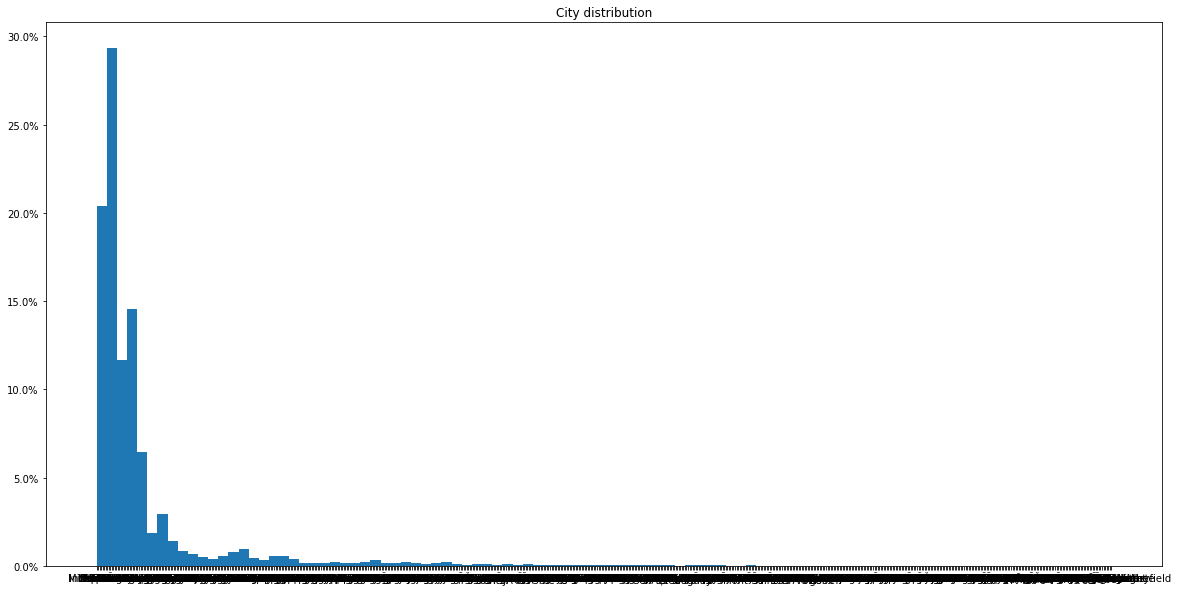

In [16]:
data = train_test_set.loc[train_test_set['city']!="Las Vegas", 'city']
weights = _np.ones(len(data)) / len(data)
_plt.figure(figsize=(20,10))
_plt.hist(data, weights=weights, bins=100)
_plt.title("City distribution")
_plt.gca().yaxis.set_major_formatter(_PercentFormatter(1))
_plt.show()

In [17]:
main_cities = city_count.where(city_count >= 100).dropna()
print(main_cities.to_string())
print(main_cities.shape)
main_cities = '|'.join(list(main_cities.index))

Las Vegas               208437.0
Phoenix                  71126.0
Toronto                  57047.0
Charlotte                40190.0
Scottsdale               36579.0
Pittsburgh               26891.0
Henderson                21518.0
MontrÃ©al                18531.0
Tempe                    18354.0
Mesa                     17235.0
Chandler                 15441.0
Gilbert                  14055.0
Cleveland                12873.0
Glendale                 10742.0
Madison                   9688.0
Markham                   8248.0
Calgary                   7958.0
Mississauga               7192.0
Peoria                    6582.0
North Las Vegas           4771.0
Surprise                  4117.0
Richmond Hill             3886.0
Goodyear                  3020.0
Concord                   2905.0
Scarborough               2544.0
Champaign                 2513.0
Vaughan                   2496.0
Avondale                  2451.0
Huntersville              2046.0
Lakewood                  2008.0
Matthews  

In [18]:
train_test_set['city'] = train_test_set['city'].str.findall(main_cities)
train_test_set['city'] = train_test_set['city'].map(lambda x: 'Other' if x==[] else x[0])
train_test_set.head()

,review_id,user_id,business_id,stars_review,useful_review,funny_review,cool_review,bin_truth_score,real_truth_score,cuisine_av_hist,cuisine_av_hist_bin,cuisine_av_hist_real,coll_score,coll_score_bin,coll_score_real,likes,postal_code,latitude,longitude,review_count,stars_restaurant,OutdoorSeating,BusinessAcceptsCreditCards,RestaurantsDelivery,RestaurantsReservations,WiFi,Alcohol,categories,city,Monday_Open,Tuesday_Open,Wednesday_Open,Thursday_Open,Friday_Open,Saturday_Open,Sunday_Open,Monday_Close,Tuesday_Close,Wednesday_Close,Thursday_Close,Friday_Close,Saturday_Close,Sunday_Close,average_stars_review,num_reviews_review,average_stars_bin_review,num_reviews_bin_review,average_stars_real_review,num_reviews_real_review,compliment_count,average_stars_user,review,years_of_elite,fans,useful_user,cool_user,funny_user,friends,num_reviews_user,average_stars_bin_user,num_reviews_bin_user,average_stars_real_user,num_reviews_real_user,av_rat_chinese_cuisine,av_rat_japanese_cuisine,av_rat_mexican_cuisine,av_rat_italian_cuisine,av_rat_others_cuisine,av_rat_american_cuisine,av_rat_korean_cuisine,av_rat_mediterranean_cuisine,av_rat_thai_cuisine,av_rat_asianfusion_cuisine,av_rat_chinese_cuisine_bin,av_rat_japanese_cuisine_bin,av_rat_mexican_cuisine_bin,av_rat_italian_cuisine_bin,av_rat_others_cuisine_bin,av_rat_american_cuisine_bin,av_rat_korean_cuisine_bin,av_rat_mediterranean_cuisine_bin,av_rat_thai_cuisine_bin,av_rat_asianfusion_cuisine_bin,av_rat_chinese_cuisine_real,av_rat_japanese_cuisine_real,av_rat_mexican_cuisine_real,av_rat_italian_cuisine_real,av_rat_others_cuisine_real,av_rat_american_cuisine_real,av_rat_korean_cuisine_real,av_rat_mediterranean_cuisine_real,av_rat_thai_cuisine_real,av_rat_asianfusion_cuisine_real
0,---HLAnHbuLi7vd5TL6uYg,zyp8SaRnZ94sWZpLrifS1Q,l6xZVTEtdZAvNpL1JhYGuw,4,0,0,0,-1,0.595406,3.726715,3.704594,3.719363,-0.062602,-0.064146,-0.054028,1,J3G 4K8,45.569980,-73.199634,4,5.0,None,None,None,None,None,None,"Italian, Restaurants, Mediterranean",Other,16:30:00,16:30:00,16:30:00,16:30:00,16:30:00,16:30:00,16:30:00,22:00:00,22:00:00,22:00:00,23:00:00,23:00:00,23:00:00,22:00:00,5.000000,3.0,5.000000,3.0,5.000000,1.746082,0.009869,3.000000,10,0,0,2,0,0,22,3.0,3.000000,3.0,3.022921,2.723338,3.556721,3.79608,3.686094,3.777956,3.000000,3.684951,3.789846,3.933014,3.868171,3.770015,3.542997,3.763461,3.662669,3.749776,3.000000,3.667520,3.771654,3.904608,3.851784,3.744434,3.555679,3.789966,3.678871,3.770170,3.022921,3.676024,3.788204,3.928912,3.867280,3.767263
1,---L4b6VR6HoB-q7cfMWIA,697iJkhX1mkVF9RNhn114Q,XiXu6WHbDoopKpeg7DfKdQ,5,3,1,2,1,0.993384,3.013889,3.014925,3.039444,-0.507850,-0.525615,-0.455618,1,L5V 1N3,43.579150,-79.683305,51,3.5,True,None,False,False,Free,No,"Food, Breakfast & Brunch, Restaurants, Coffee ...",Mississauga,07:00:00,07:00:00,07:00:00,07:00:00,07:00:00,07:00:00,07:00:00,22:00:00,22:00:00,22:00:00,22:00:00,12:00:00,12:00:00,22:00:00,3.521739,46.0,3.540541,37.0,3.495062,36.481444,0.009869,3.157143,236,5,25,809,331,162,3238,140.0,3.152672,131.0,3.158813,126.185462,3.833333,2.87500,4.000000,3.250000,3.013889,3.125000,3.333333,3.400000,2.666667,2.666667,3.823529,2.600000,4.000000,3.250000,3.014925,3.066667,3.333333,3.400000,2.400000,2.666667,3.821347,2.726907,4.000000,3.303025,3.039444,3.145065,2.847918,3.387395,2.572254,2.752899
2,---sPYSgArT4Sd5v1nDVMQ,iVSuN8PrtKVtLzhNiu23uA,OumGHdbdp7WgyYMhcAdjhw,1,0,0,0,1,0.519254,3.726715,3.704594,3.719363,-0.062602,-0.064146,-0.054028,0,85379,33.608745,-112.359880,190,2.5,True,True,False,True,Free,Full_Bar,"Sports Bars, Bars, Chicken Wings, Nightlife, A...",Surprise,11:00:00,11:00:00,11:00:00,11:00:00,11:00:00,11:00:00,10:30:00,22:00:00,22:00:00,22:00:00,22:00:00,23:00:00,23:00:00,22:00:00,2.821229,179.0,2.814286,140.0,2.817668,133.926571,0.009869,3.703313,1,0,0,0,0,0,4,0.0,3.703313,0.0,3.703313,0.000000,3.556721,3.79608,3.686094,3.777956,3.736355,3.684951,3.789846,3.933014,3.868171,3.770015,3.542997,3.763461,3.662669,3.749776,3.719581,3.667520,3.771654,3.904608,3.85

We print and plot the distribution of the categories, to see the long tail and decide how many of them to keep.

In [19]:
category_count = _pd.Series(', '.join(list(train_test_set['categories'])).split(', ')).value_counts()
print(category_count.to_string())
print(category_count.shape)

Restaurants                         712379
Food                                192841
Nightlife                           170259
Bars                                165959
American (Traditional)              123975
Breakfast & Brunch                  120310
American (New)                      117437
Sandwiches                           82264
Mexican                              73726
Burgers                              71598
Pizza                                67538
Italian                              62490
Seafood                              57228
Japanese                             53952
Salad                                49388
Fast Food                            46982
Event Planning & Services            45382
Coffee & Tea                         43592
Chinese                              42971
Asian Fusion                         42576
Sushi Bars                           42487
Cafes                                40002
Steakhouses                          37097
Desserts   

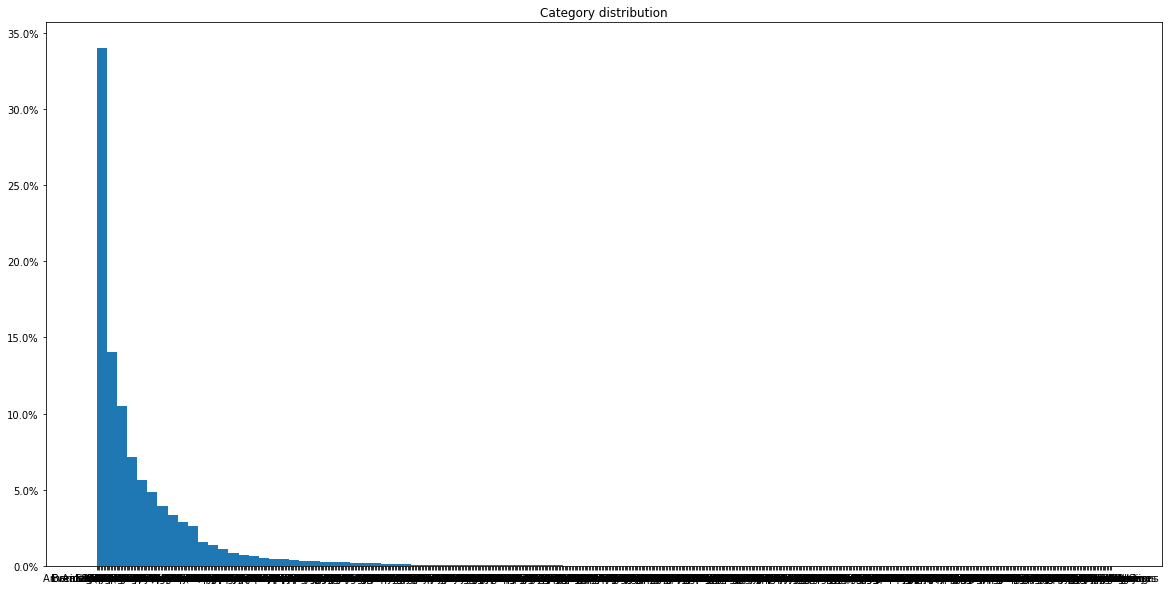

In [20]:
data = category_count.drop(labels=['Restaurants', 'Food']).index
vals = category_count.drop(labels=['Restaurants', 'Food']).values
weights = vals / vals.sum()
_plt.figure(figsize=(20,10))
_plt.hist(data, weights=weights, bins=100)
_plt.title("Category distribution")
_plt.gca().yaxis.set_major_formatter(_PercentFormatter(1))
_plt.show()

In [21]:
main_categories = category_count.drop(labels=['Restaurants', 'Food']).where(category_count >= 100).dropna()
print(main_categories.to_string())
print(main_categories.shape)
main_categories = '|'.join([_re.escape(x) for x in main_categories.index])

Nightlife                           170259.0
Bars                                165959.0
American (Traditional)              123975.0
Breakfast & Brunch                  120310.0
American (New)                      117437.0
Sandwiches                           82264.0
Mexican                              73726.0
Burgers                              71598.0
Pizza                                67538.0
Italian                              62490.0
Seafood                              57228.0
Japanese                             53952.0
Salad                                49388.0
Fast Food                            46982.0
Event Planning & Services            45382.0
Coffee & Tea                         43592.0
Chinese                              42971.0
Asian Fusion                         42576.0
Sushi Bars                           42487.0
Cafes                                40002.0
Steakhouses                          37097.0
Desserts                             36523.0
Cocktail B

In [22]:
train_test_set['categories'] = train_test_set['categories'].str.findall(main_categories)
train_test_set['categories'] = train_test_set['categories'].map(lambda x: set(x))
train_test_set['categories'] = train_test_set['categories'].map(lambda x: ['Other'] if not bool(x) else list(x))
train_test_set['categories'] = train_test_set['categories'].map(', '.join) 
train_test_set.head()

,review_id,user_id,business_id,stars_review,useful_review,funny_review,cool_review,bin_truth_score,real_truth_score,cuisine_av_hist,cuisine_av_hist_bin,cuisine_av_hist_real,coll_score,coll_score_bin,coll_score_real,likes,postal_code,latitude,longitude,review_count,stars_restaurant,OutdoorSeating,BusinessAcceptsCreditCards,RestaurantsDelivery,RestaurantsReservations,WiFi,Alcohol,categories,city,Monday_Open,Tuesday_Open,Wednesday_Open,Thursday_Open,Friday_Open,Saturday_Open,Sunday_Open,Monday_Close,Tuesday_Close,Wednesday_Close,Thursday_Close,Friday_Close,Saturday_Close,Sunday_Close,average_stars_review,num_reviews_review,average_stars_bin_review,num_reviews_bin_review,average_stars_real_review,num_reviews_real_review,compliment_count,average_stars_user,review,years_of_elite,fans,useful_user,cool_user,funny_user,friends,num_reviews_user,average_stars_bin_user,num_reviews_bin_user,average_stars_real_user,num_reviews_real_user,av_rat_chinese_cuisine,av_rat_japanese_cuisine,av_rat_mexican_cuisine,av_rat_italian_cuisine,av_rat_others_cuisine,av_rat_american_cuisine,av_rat_korean_cuisine,av_rat_mediterranean_cuisine,av_rat_thai_cuisine,av_rat_asianfusion_cuisine,av_rat_chinese_cuisine_bin,av_rat_japanese_cuisine_bin,av_rat_mexican_cuisine_bin,av_rat_italian_cuisine_bin,av_rat_others_cuisine_bin,av_rat_american_cuisine_bin,av_rat_korean_cuisine_bin,av_rat_mediterranean_cuisine_bin,av_rat_thai_cuisine_bin,av_rat_asianfusion_cuisine_bin,av_rat_chinese_cuisine_real,av_rat_japanese_cuisine_real,av_rat_mexican_cuisine_real,av_rat_italian_cuisine_real,av_rat_others_cuisine_real,av_rat_american_cuisine_real,av_rat_korean_cuisine_real,av_rat_mediterranean_cuisine_real,av_rat_thai_cuisine_real,av_rat_asianfusion_cuisine_real
0,---HLAnHbuLi7vd5TL6uYg,zyp8SaRnZ94sWZpLrifS1Q,l6xZVTEtdZAvNpL1JhYGuw,4,0,0,0,-1,0.595406,3.726715,3.704594,3.719363,-0.062602,-0.064146,-0.054028,1,J3G 4K8,45.569980,-73.199634,4,5.0,None,None,None,None,None,None,"Mediterranean, Italian",Other,16:30:00,16:30:00,16:30:00,16:30:00,16:30:00,16:30:00,16:30:00,22:00:00,22:00:00,22:00:00,23:00:00,23:00:00,23:00:00,22:00:00,5.000000,3.0,5.000000,3.0,5.000000,1.746082,0.009869,3.000000,10,0,0,2,0,0,22,3.0,3.000000,3.0,3.022921,2.723338,3.556721,3.79608,3.686094,3.777956,3.000000,3.684951,3.789846,3.933014,3.868171,3.770015,3.542997,3.763461,3.662669,3.749776,3.000000,3.667520,3.771654,3.904608,3.851784,3.744434,3.555679,3.789966,3.678871,3.770170,3.022921,3.676024,3.788204,3.928912,3.867280,3.767263
1,---L4b6VR6HoB-q7cfMWIA,697iJkhX1mkVF9RNhn114Q,XiXu6WHbDoopKpeg7DfKdQ,5,3,1,2,1,0.993384,3.013889,3.014925,3.039444,-0.507850,-0.525615,-0.455618,1,L5V 1N3,43.579150,-79.683305,51,3.5,True,None,False,False,Free,No,"Coffee & Tea, Breakfast & Brunch",Mississauga,07:00:00,07:00:00,07:00:00,07:00:00,07:00:00,07:00:00,07:00:00,22:00:00,22:00:00,22:00:00,22:00:00,12:00:00,12:00:00,22:00:00,3.521739,46.0,3.540541,37.0,3.495062,36.481444,0.009869,3.157143,236,5,25,809,331,162,3238,140.0,3.152672,131.0,3.158813,126.185462,3.833333,2.87500,4.000000,3.250000,3.013889,3.125000,3.333333,3.400000,2.666667,2.666667,3.823529,2.600000,4.000000,3.250000,3.014925,3.066667,3.333333,3.400000,2.400000,2.666667,3.821347,2.726907,4.000000,3.303025,3.039444,3.145065,2.847918,3.387395,2.572254,2.752899
2,---sPYSgArT4Sd5v1nDVMQ,iVSuN8PrtKVtLzhNiu23uA,OumGHdbdp7WgyYMhcAdjhw,1,0,0,0,1,0.519254,3.726715,3.704594,3.719363,-0.062602,-0.064146,-0.054028,0,85379,33.608745,-112.359880,190,2.5,True,True,False,True,Free,Full_Bar,"Bars, American (New), Chicken Wings, Burgers, ...",Surprise,11:00:00,11:00:00,11:00:00,11:00:00,11:00:00,11:00:00,10:30:00,22:00:00,22:00:00,22:00:00,22:00:00,23:00:00,23:00:00,22:00:00,2.821229,179.0,2.814286,140.0,2.817668,133.926571,0.009869,3.703313,1,0,0,0,0,0,4,0.0,3.703313,0.0,3.703313,0.000000,3.556721,3.79608,3.686094,3.777956,3.736355,3.684951,3.789846,3.933014,3.868171,3.770015,3.542997,3.763461,3.662669,3.749776,3.719581,3.667520,3.771654,3.904608,3.851784,3.744434,3.555679,3.78996

Now we apply the actual conversion

In [23]:
train_test_set.shape

(712379, 93)

In [24]:
cat_cols = ['OutdoorSeating', 'BusinessAcceptsCreditCards', 'RestaurantsDelivery', 'RestaurantsReservations', 'WiFi',
        'Alcohol', 'city']
train_test_set = _pd.get_dummies(train_test_set, columns=cat_cols, prefix=cat_cols)
train_test_set.shape

(712379, 281)

In [25]:
categories = train_test_set['categories'].str.get_dummies(',')
f1 = lambda x: "categories_" + x
categories.rename(columns=f1, inplace=True)
train_test_set[categories.columns] = categories
train_test_set.drop(columns=['categories'], inplace=True)
train_test_set.shape

(712379, 817)

In [26]:
oe = _OrdinalEncoder()

In [27]:
ord_cols = ['Monday_Open', 'Tuesday_Open', 'Wednesday_Open', 'Thursday_Open', 'Friday_Open',
            'Saturday_Open', 'Sunday_Open', 'Monday_Close', 'Tuesday_Close', 'Wednesday_Close',
            'Thursday_Close','Friday_Close', 'Saturday_Close', 'Sunday_Close', 'postal_code']

train_test_set[ord_cols] = oe.fit_transform(train_test_set[ord_cols].to_numpy())

The resulting dataset

In [28]:
train_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712379 entries, 0 to 153992
Columns: 817 entries, review_id to categories_Zoos
dtypes: float64(68), int32(1), int64(550), object(3), uint8(195)
memory usage: 3.4+ GB


In [29]:
train_set = train_test_set[:_train_len]
test_set = train_test_set[_train_len:]

In [30]:
train_set.head(10)

,review_id,user_id,business_id,stars_review,useful_review,funny_review,cool_review,bin_truth_score,real_truth_score,cuisine_av_hist,cuisine_av_hist_bin,cuisine_av_hist_real,coll_score,coll_score_bin,coll_score_real,likes,postal_code,latitude,longitude,review_count,stars_restaurant,Monday_Open,Tuesday_Open,Wednesday_Open,Thursday_Open,Friday_Open,Saturday_Open,Sunday_Open,Monday_Close,Tuesday_Close,Wednesday_Close,Thursday_Close,Friday_Close,Saturday_Close,Sunday_Close,average_stars_review,num_reviews_review,average_stars_bin_review,num_reviews_bin_review,average_stars_real_review,num_reviews_real_review,compliment_count,average_stars_user,review,years_of_elite,fans,useful_user,cool_user,funny_user,friends,num_reviews_user,average_stars_bin_user,num_reviews_bin_user,average_stars_real_user,num_reviews_real_user,av_rat_chinese_cuisine,av_rat_japanese_cuisine,av_rat_mexican_cuisine,av_rat_italian_cuisine,av_rat_others_cuisine,av_rat_american_cuisine,av_rat_korean_cuisine,av_rat_mediterranean_cuisine,av_rat_thai_cuisine,av_rat_asianfusion_cuisine,av_rat_chinese_cuisine_bin,av_rat_japanese_cuisine_bin,av_rat_mexican_cuisine_bin,av_rat_italian_cuisine_bin,av_rat_others_cuisine_bin,av_rat_american_cuisine_bin,av_rat_korean_cuisine_bin,av_rat_mediterranean_cuisine_bin,av_rat_thai_cuisine_bin,av_rat_asianfusion_cuisine_bin,av_rat_chinese_cuisine_real,av_rat_japanese_cuisine_real,av_rat_mexican_cuisine_real,av_rat_italian_cuisine_real,av_rat_others_cuisine_real,av_rat_american_cuisine_real,av_rat_korean_cuisine_real,av_rat_mediterranean_cuisine_real,av_rat_thai_cuisine_real,av_rat_asianfusion_cuisine_real,OutdoorSeating_False,OutdoorSeating_None,OutdoorSeating_True,BusinessAcceptsCreditCards_False,BusinessAcceptsCreditCards_None,BusinessAcceptsCreditCards_True,RestaurantsDelivery_False,RestaurantsDelivery_None,RestaurantsDelivery_True,RestaurantsReservations_False,RestaurantsReservations_None,RestaurantsReservations_True,WiFi_Free,WiFi_No,WiFi_None,WiFi_Paid,Alcohol_Beer&Wine,Alcohol_Full_Bar,Alcohol_No,Alcohol_None,city_Ahwatukee,city_Airdrie,city_Ajax,city_Akron,city_Allison Park,city_Amherst,city_Aurora,city_Avon,city_Avondale,city_Beachwood,city_Bellevue,city_Belmont,city_Berea,city_Bethel Park,city_Blue Diamond,city_Boulder City,city_Braddock,city_Brampton,city_Brecksville,city_Bridgeville,city_Broadview Heights,city_Brook Park,city_Brooklyn,city_Brossard,city_Brunswick,city_Buckeye,city_Calgary,city_Canonsburg,city_Carefree,city_Carnegie,city_Cave Creek,city_Chagrin Falls,city_Champaign,city_Chandler,city_Chardon,city_Charlotte,city_Chesterland,city_Cleveland,city_Clover,city_Concord,city_Coraopolis,city_Cornelius,city_Cuyahoga Falls,city_Davidson,city_Denver,city_Dollard-des-Ormeaux,city_Dorval,city_East York,city_El Mirage,city_Elyria,city_Etobicoke,city_Euclid,city_Fairlawn,city_Fairview Park,city_Fitchburg,city_Fort Mill,city_Fountain Hills,city_Gastonia,city_Gilbert,city_Glendale,city_Goodyear,city_Harrisburg,city_Henderson,city_Highland Heights,city_Homestead,city_Hudson,city_Huntersville,city_Independence,city_Indian Land,city_Indian Trail,city_Irwin,city_Kannapolis,city_Kent,city_Lake Wylie,city_Lakewood,city_Las Vegas,city_Laval,city_Laveen,city_Litchfield Park,city_Longueuil,city_Lorain,city_Lyndhurst,city_Macedonia,city_Madison,city_Maple,city_Markham,city_Matthews,city_Mayfield Heights,city_McKees Rocks,city_McMurray,city_Medina,city_Mentor,city_Mesa,city_Middleburg Heights,city_Middleton,city_Mint Hill,city_Mississauga,city_Monona,city_Monroe,city_Monroeville,city_Montreal,city_MontrÃ©al,city_Moon Township,city_Mooresville,city_Mount Holly,city_Murrysville,city_New Kensington,city_Newmarket,city_North Las Vegas,city_North Olmsted,city_North Ridgeville,city_North Royalton,city_North York,city_Northfield,city_Oakmont,city_Oakville,city_Olmsted Falls,city_Orange,city_Orange Village,city_Other,city_Painesville,city_Paradise Valley,city_Parma,city_Peoria,city_Phoenix,city_Pickering,city_Pineville,city_Pittsburgh,city_Point

In [31]:
train_set.shape

(558386, 817)

In [32]:
train_set.to_pickle('../dataset/m2_n9/model_train_set_3.pickle')

In [33]:
test_set.head(10)

,review_id,user_id,business_id,stars_review,useful_review,funny_review,cool_review,bin_truth_score,real_truth_score,cuisine_av_hist,cuisine_av_hist_bin,cuisine_av_hist_real,coll_score,coll_score_bin,coll_score_real,likes,postal_code,latitude,longitude,review_count,stars_restaurant,Monday_Open,Tuesday_Open,Wednesday_Open,Thursday_Open,Friday_Open,Saturday_Open,Sunday_Open,Monday_Close,Tuesday_Close,Wednesday_Close,Thursday_Close,Friday_Close,Saturday_Close,Sunday_Close,average_stars_review,num_reviews_review,average_stars_bin_review,num_reviews_bin_review,average_stars_real_review,num_reviews_real_review,compliment_count,average_stars_user,review,years_of_elite,fans,useful_user,cool_user,funny_user,friends,num_reviews_user,average_stars_bin_user,num_reviews_bin_user,average_stars_real_user,num_reviews_real_user,av_rat_chinese_cuisine,av_rat_japanese_cuisine,av_rat_mexican_cuisine,av_rat_italian_cuisine,av_rat_others_cuisine,av_rat_american_cuisine,av_rat_korean_cuisine,av_rat_mediterranean_cuisine,av_rat_thai_cuisine,av_rat_asianfusion_cuisine,av_rat_chinese_cuisine_bin,av_rat_japanese_cuisine_bin,av_rat_mexican_cuisine_bin,av_rat_italian_cuisine_bin,av_rat_others_cuisine_bin,av_rat_american_cuisine_bin,av_rat_korean_cuisine_bin,av_rat_mediterranean_cuisine_bin,av_rat_thai_cuisine_bin,av_rat_asianfusion_cuisine_bin,av_rat_chinese_cuisine_real,av_rat_japanese_cuisine_real,av_rat_mexican_cuisine_real,av_rat_italian_cuisine_real,av_rat_others_cuisine_real,av_rat_american_cuisine_real,av_rat_korean_cuisine_real,av_rat_mediterranean_cuisine_real,av_rat_thai_cuisine_real,av_rat_asianfusion_cuisine_real,OutdoorSeating_False,OutdoorSeating_None,OutdoorSeating_True,BusinessAcceptsCreditCards_False,BusinessAcceptsCreditCards_None,BusinessAcceptsCreditCards_True,RestaurantsDelivery_False,RestaurantsDelivery_None,RestaurantsDelivery_True,RestaurantsReservations_False,RestaurantsReservations_None,RestaurantsReservations_True,WiFi_Free,WiFi_No,WiFi_None,WiFi_Paid,Alcohol_Beer&Wine,Alcohol_Full_Bar,Alcohol_No,Alcohol_None,city_Ahwatukee,city_Airdrie,city_Ajax,city_Akron,city_Allison Park,city_Amherst,city_Aurora,city_Avon,city_Avondale,city_Beachwood,city_Bellevue,city_Belmont,city_Berea,city_Bethel Park,city_Blue Diamond,city_Boulder City,city_Braddock,city_Brampton,city_Brecksville,city_Bridgeville,city_Broadview Heights,city_Brook Park,city_Brooklyn,city_Brossard,city_Brunswick,city_Buckeye,city_Calgary,city_Canonsburg,city_Carefree,city_Carnegie,city_Cave Creek,city_Chagrin Falls,city_Champaign,city_Chandler,city_Chardon,city_Charlotte,city_Chesterland,city_Cleveland,city_Clover,city_Concord,city_Coraopolis,city_Cornelius,city_Cuyahoga Falls,city_Davidson,city_Denver,city_Dollard-des-Ormeaux,city_Dorval,city_East York,city_El Mirage,city_Elyria,city_Etobicoke,city_Euclid,city_Fairlawn,city_Fairview Park,city_Fitchburg,city_Fort Mill,city_Fountain Hills,city_Gastonia,city_Gilbert,city_Glendale,city_Goodyear,city_Harrisburg,city_Henderson,city_Highland Heights,city_Homestead,city_Hudson,city_Huntersville,city_Independence,city_Indian Land,city_Indian Trail,city_Irwin,city_Kannapolis,city_Kent,city_Lake Wylie,city_Lakewood,city_Las Vegas,city_Laval,city_Laveen,city_Litchfield Park,city_Longueuil,city_Lorain,city_Lyndhurst,city_Macedonia,city_Madison,city_Maple,city_Markham,city_Matthews,city_Mayfield Heights,city_McKees Rocks,city_McMurray,city_Medina,city_Mentor,city_Mesa,city_Middleburg Heights,city_Middleton,city_Mint Hill,city_Mississauga,city_Monona,city_Monroe,city_Monroeville,city_Montreal,city_MontrÃ©al,city_Moon Township,city_Mooresville,city_Mount Holly,city_Murrysville,city_New Kensington,city_Newmarket,city_North Las Vegas,city_North Olmsted,city_North Ridgeville,city_North Royalton,city_North York,city_Northfield,city_Oakmont,city_Oakville,city_Olmsted Falls,city_Orange,city_Orange Village,city_Other,city_Painesville,city_Paradise Valley,city_Parma,city_Peoria,city_Phoenix,city_Pickering,city_Pineville,city_Pittsburgh,city_Point

In [34]:
test_set.shape

(153993, 817)

In [35]:
test_set.to_pickle('../dataset/m2_n9/model_test_set_3.pickle')

In [36]:
_del_all()

## 6. Models
### 6.1 Linear SVM

(see the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html))

In [3]:
train_set = _pd.read_pickle('../dataset/m2_n9/model_train_set_3.pickle')
train_set.head()

,review_id,user_id,business_id,stars_review,useful_review,funny_review,cool_review,bin_truth_score,real_truth_score,cuisine_av_hist,cuisine_av_hist_bin,cuisine_av_hist_real,coll_score,coll_score_bin,coll_score_real,likes,postal_code,latitude,longitude,review_count,stars_restaurant,Monday_Open,Tuesday_Open,Wednesday_Open,Thursday_Open,Friday_Open,Saturday_Open,Sunday_Open,Monday_Close,Tuesday_Close,Wednesday_Close,Thursday_Close,Friday_Close,Saturday_Close,Sunday_Close,average_stars_review,num_reviews_review,average_stars_bin_review,num_reviews_bin_review,average_stars_real_review,num_reviews_real_review,compliment_count,average_stars_user,review,years_of_elite,fans,useful_user,cool_user,funny_user,friends,num_reviews_user,average_stars_bin_user,num_reviews_bin_user,average_stars_real_user,num_reviews_real_user,av_rat_chinese_cuisine,av_rat_japanese_cuisine,av_rat_mexican_cuisine,av_rat_italian_cuisine,av_rat_others_cuisine,av_rat_american_cuisine,av_rat_korean_cuisine,av_rat_mediterranean_cuisine,av_rat_thai_cuisine,av_rat_asianfusion_cuisine,av_rat_chinese_cuisine_bin,av_rat_japanese_cuisine_bin,av_rat_mexican_cuisine_bin,av_rat_italian_cuisine_bin,av_rat_others_cuisine_bin,av_rat_american_cuisine_bin,av_rat_korean_cuisine_bin,av_rat_mediterranean_cuisine_bin,av_rat_thai_cuisine_bin,av_rat_asianfusion_cuisine_bin,av_rat_chinese_cuisine_real,av_rat_japanese_cuisine_real,av_rat_mexican_cuisine_real,av_rat_italian_cuisine_real,av_rat_others_cuisine_real,av_rat_american_cuisine_real,av_rat_korean_cuisine_real,av_rat_mediterranean_cuisine_real,av_rat_thai_cuisine_real,av_rat_asianfusion_cuisine_real,OutdoorSeating_False,OutdoorSeating_None,OutdoorSeating_True,BusinessAcceptsCreditCards_False,BusinessAcceptsCreditCards_None,BusinessAcceptsCreditCards_True,RestaurantsDelivery_False,RestaurantsDelivery_None,RestaurantsDelivery_True,RestaurantsReservations_False,RestaurantsReservations_None,RestaurantsReservations_True,WiFi_Free,WiFi_No,WiFi_None,WiFi_Paid,Alcohol_Beer&Wine,Alcohol_Full_Bar,Alcohol_No,Alcohol_None,city_Ahwatukee,city_Airdrie,city_Ajax,city_Akron,city_Allison Park,city_Amherst,city_Aurora,city_Avon,city_Avondale,city_Beachwood,city_Bellevue,city_Belmont,city_Berea,city_Bethel Park,city_Blue Diamond,city_Boulder City,city_Braddock,city_Brampton,city_Brecksville,city_Bridgeville,city_Broadview Heights,city_Brook Park,city_Brooklyn,city_Brossard,city_Brunswick,city_Buckeye,city_Calgary,city_Canonsburg,city_Carefree,city_Carnegie,city_Cave Creek,city_Chagrin Falls,city_Champaign,city_Chandler,city_Chardon,city_Charlotte,city_Chesterland,city_Cleveland,city_Clover,city_Concord,city_Coraopolis,city_Cornelius,city_Cuyahoga Falls,city_Davidson,city_Denver,city_Dollard-des-Ormeaux,city_Dorval,city_East York,city_El Mirage,city_Elyria,city_Etobicoke,city_Euclid,city_Fairlawn,city_Fairview Park,city_Fitchburg,city_Fort Mill,city_Fountain Hills,city_Gastonia,city_Gilbert,city_Glendale,city_Goodyear,city_Harrisburg,city_Henderson,city_Highland Heights,city_Homestead,city_Hudson,city_Huntersville,city_Independence,city_Indian Land,city_Indian Trail,city_Irwin,city_Kannapolis,city_Kent,city_Lake Wylie,city_Lakewood,city_Las Vegas,city_Laval,city_Laveen,city_Litchfield Park,city_Longueuil,city_Lorain,city_Lyndhurst,city_Macedonia,city_Madison,city_Maple,city_Markham,city_Matthews,city_Mayfield Heights,city_McKees Rocks,city_McMurray,city_Medina,city_Mentor,city_Mesa,city_Middleburg Heights,city_Middleton,city_Mint Hill,city_Mississauga,city_Monona,city_Monroe,city_Monroeville,city_Montreal,city_MontrÃ©al,city_Moon Township,city_Mooresville,city_Mount Holly,city_Murrysville,city_New Kensington,city_Newmarket,city_North Las Vegas,city_North Olmsted,city_North Ridgeville,city_North Royalton,city_North York,city_Northfield,city_Oakmont,city_Oakville,city_Olmsted Falls,city_Orange,city_Orange Village,city_Other,city_Painesville,city_Paradise Valley,city_Parma,city_Peoria,city_Phoenix,city_Pickering,city_Pineville,city_Pittsburgh,city_Point

In [4]:
#sub_train_set = train_set[:round(train_set.shape[0]/3)]
sub_train_set = train_set
del train_set
sub_train_set.shape

(558386, 817)

In [5]:
# define classifier
svc_classifier = _LinearSVC(random_state=0, max_iter=50000)
svc_classifier.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 50000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 0,
 'tol': 0.0001,
 'verbose': 0}

In [6]:
# fine tune classifier
# param_grid = {'C':[0.001,0.01,0.1,0.25,0.5,0.75,1,10,100,1000], 'gamma':[3,2,1,0.1,0.001,0.0001]}
param_grid = {'C':[0.001,0.01,0.1,0.25,0.5,0.75,1,10,100,1000]}
# grid = _GridSearchCV(estimator=svc_classifier, param_grid=param_grid, refit=True, verbose=2, cv=3, error_score=_np.nan, n_jobs=1, pre_dispatch=1)
grid = _GridSearchCV(estimator=svc_classifier, param_grid=param_grid, refit=True, verbose=2, cv=3, error_score=_np.nan, n_jobs=-1, pre_dispatch=6)
grid.fit(sub_train_set.drop(columns=['likes', 'stars_review', 'review_id', 'user_id', 'business_id']), sub_train_set['likes'])
print("best params:", grid.best_params_, "- best score:", grid.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 1654.8min finished


best params: {'C': 0.001} - best score: 0.7436808945783024


C:\Users\super\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [7]:
print("results:", grid.cv_results_)

results: {'mean_fit_time': array([19900.99567477, 19961.755548  , 19843.87850094, 19883.72761846,
       19875.85472822, 19892.886506  , 19819.18020558, 19831.93277272,
       19672.39210947, 19633.8438464 ]), 'std_fit_time': array([11.92322164, 24.47909948, 11.8002273 ,  2.51810785, 18.78170298,
       16.00907826,  5.86167115, 32.23873155,  4.59971461, 24.49313577]), 'mean_score_time': array([ 2.63927579,  5.25461706,  5.47336515, 10.05810801,  5.17248909,
        3.84837699,  2.75297205,  2.87099091,  2.33608754,  1.75242146]), 'std_score_time': array([0.28703641, 3.56587212, 1.62402285, 4.61803914, 2.93643879,
       1.57086447, 0.04191375, 0.27929337, 0.24098951, 0.2409035 ]), 'param_C': masked_array(data=[0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1, 10, 100, 1000],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 0.25}, {'C

In [8]:
del sub_train_set
train_set = _pd.read_pickle('../dataset/m2_n9/model_train_set_3.pickle')

In [9]:
best_model = grid.best_estimator_
best_model.fit(train_set.drop(columns=['likes', 'stars_review', 'review_id', 'user_id', 'business_id']), train_set['likes'])

C:\Users\super\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=50000,
          multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
          verbose=0)

In [10]:
print("coef:", best_model.coef_)
print("intercept:", best_model.intercept_)

coef: [[-1.43167078e-01 -2.03906910e-01  3.42779107e-01 -1.04728908e-02
  -1.47427540e-01 -2.43472370e-02 -9.26808435e-03 -1.17709493e-02
   5.58234365e-02  1.83726109e-02 -7.91658762e-03  7.49998933e-05
  -3.29092790e-02  7.08513173e-03 -4.64203658e-05  6.24335229e-01
  -4.68312019e-05  1.13214836e-03  1.87475912e-04 -8.54227633e-04
  -4.47446153e-04 -7.61677236e-04  1.13923954e-03 -1.91138083e-04
  -1.40924026e-04  4.50836058e-04 -7.61383085e-05  5.97650915e-05
   2.98315416e-05 -2.74831993e-04 -6.26183842e-02  5.30331089e-05
   5.84330552e-03  2.03076934e-04 -3.48781537e-02 -2.18059846e-04
  -4.02326827e-02  4.95315660e-02  3.39012708e-04  1.71206420e-02
  -8.71542990e-04 -2.61593855e-04  1.30803827e-04  1.18480402e-04
  -4.80787054e-06 -5.59617233e-03  1.61222017e-02  1.03926925e-04
   4.67182627e-03  5.79030033e-03  3.74660499e-02  1.02789779e-02
   4.51314090e-02  1.57159326e-02  2.23464027e-02  5.36922329e-02
   2.34749232e-02  2.86587882e-02  1.87929188e-02  3.83956193e-04
  -7

In [11]:
del train_set
test_set = _pd.read_pickle('../dataset/m2_n9/model_test_set_3.pickle')
test_set.head()

,review_id,user_id,business_id,stars_review,useful_review,funny_review,cool_review,bin_truth_score,real_truth_score,cuisine_av_hist,cuisine_av_hist_bin,cuisine_av_hist_real,coll_score,coll_score_bin,coll_score_real,likes,postal_code,latitude,longitude,review_count,stars_restaurant,Monday_Open,Tuesday_Open,Wednesday_Open,Thursday_Open,Friday_Open,Saturday_Open,Sunday_Open,Monday_Close,Tuesday_Close,Wednesday_Close,Thursday_Close,Friday_Close,Saturday_Close,Sunday_Close,average_stars_review,num_reviews_review,average_stars_bin_review,num_reviews_bin_review,average_stars_real_review,num_reviews_real_review,compliment_count,average_stars_user,review,years_of_elite,fans,useful_user,cool_user,funny_user,friends,num_reviews_user,average_stars_bin_user,num_reviews_bin_user,average_stars_real_user,num_reviews_real_user,av_rat_chinese_cuisine,av_rat_japanese_cuisine,av_rat_mexican_cuisine,av_rat_italian_cuisine,av_rat_others_cuisine,av_rat_american_cuisine,av_rat_korean_cuisine,av_rat_mediterranean_cuisine,av_rat_thai_cuisine,av_rat_asianfusion_cuisine,av_rat_chinese_cuisine_bin,av_rat_japanese_cuisine_bin,av_rat_mexican_cuisine_bin,av_rat_italian_cuisine_bin,av_rat_others_cuisine_bin,av_rat_american_cuisine_bin,av_rat_korean_cuisine_bin,av_rat_mediterranean_cuisine_bin,av_rat_thai_cuisine_bin,av_rat_asianfusion_cuisine_bin,av_rat_chinese_cuisine_real,av_rat_japanese_cuisine_real,av_rat_mexican_cuisine_real,av_rat_italian_cuisine_real,av_rat_others_cuisine_real,av_rat_american_cuisine_real,av_rat_korean_cuisine_real,av_rat_mediterranean_cuisine_real,av_rat_thai_cuisine_real,av_rat_asianfusion_cuisine_real,OutdoorSeating_False,OutdoorSeating_None,OutdoorSeating_True,BusinessAcceptsCreditCards_False,BusinessAcceptsCreditCards_None,BusinessAcceptsCreditCards_True,RestaurantsDelivery_False,RestaurantsDelivery_None,RestaurantsDelivery_True,RestaurantsReservations_False,RestaurantsReservations_None,RestaurantsReservations_True,WiFi_Free,WiFi_No,WiFi_None,WiFi_Paid,Alcohol_Beer&Wine,Alcohol_Full_Bar,Alcohol_No,Alcohol_None,city_Ahwatukee,city_Airdrie,city_Ajax,city_Akron,city_Allison Park,city_Amherst,city_Aurora,city_Avon,city_Avondale,city_Beachwood,city_Bellevue,city_Belmont,city_Berea,city_Bethel Park,city_Blue Diamond,city_Boulder City,city_Braddock,city_Brampton,city_Brecksville,city_Bridgeville,city_Broadview Heights,city_Brook Park,city_Brooklyn,city_Brossard,city_Brunswick,city_Buckeye,city_Calgary,city_Canonsburg,city_Carefree,city_Carnegie,city_Cave Creek,city_Chagrin Falls,city_Champaign,city_Chandler,city_Chardon,city_Charlotte,city_Chesterland,city_Cleveland,city_Clover,city_Concord,city_Coraopolis,city_Cornelius,city_Cuyahoga Falls,city_Davidson,city_Denver,city_Dollard-des-Ormeaux,city_Dorval,city_East York,city_El Mirage,city_Elyria,city_Etobicoke,city_Euclid,city_Fairlawn,city_Fairview Park,city_Fitchburg,city_Fort Mill,city_Fountain Hills,city_Gastonia,city_Gilbert,city_Glendale,city_Goodyear,city_Harrisburg,city_Henderson,city_Highland Heights,city_Homestead,city_Hudson,city_Huntersville,city_Independence,city_Indian Land,city_Indian Trail,city_Irwin,city_Kannapolis,city_Kent,city_Lake Wylie,city_Lakewood,city_Las Vegas,city_Laval,city_Laveen,city_Litchfield Park,city_Longueuil,city_Lorain,city_Lyndhurst,city_Macedonia,city_Madison,city_Maple,city_Markham,city_Matthews,city_Mayfield Heights,city_McKees Rocks,city_McMurray,city_Medina,city_Mentor,city_Mesa,city_Middleburg Heights,city_Middleton,city_Mint Hill,city_Mississauga,city_Monona,city_Monroe,city_Monroeville,city_Montreal,city_MontrÃ©al,city_Moon Township,city_Mooresville,city_Mount Holly,city_Murrysville,city_New Kensington,city_Newmarket,city_North Las Vegas,city_North Olmsted,city_North Ridgeville,city_North Royalton,city_North York,city_Northfield,city_Oakmont,city_Oakville,city_Olmsted Falls,city_Orange,city_Orange Village,city_Other,city_Painesville,city_Paradise Valley,city_Parma,city_Peoria,city_Phoenix,city_Pickering,city_Pineville,city_Pittsburgh,city_Point

In [12]:
# test classifier
predic = best_model.predict(test_set.drop(columns=['likes', 'stars_review', 'review_id', 'user_id', 'business_id']))
print("predictions:\n", predic)

predictions:
 [1 1 1 ... 1 1 1]


In [13]:
# evaluate classifier

print("Report for Support Vector Machine:")
print(_classification_report(test_set['likes'], predic))

print("Accuracy for Support Vector Machine:", _accuracy_score(test_set['likes'], predic)*100)

Report for Support Vector Machine:
              precision    recall  f1-score   support

           0       0.70      0.36      0.48     50930
           1       0.74      0.92      0.82    103063

    accuracy                           0.74    153993
   macro avg       0.72      0.64      0.65    153993
weighted avg       0.73      0.74      0.71    153993

Accuracy for Support Vector Machine: 73.72737721844499


In [14]:
# Confusion matrix for SVC

print("Confusion Matrix for SVC before balance the data: ")
_confusion_matrix(test_set['likes'], predic)

Confusion Matrix for SVC before balance the data: 


array([[18347, 32583],
       [ 7875, 95188]], dtype=int64)

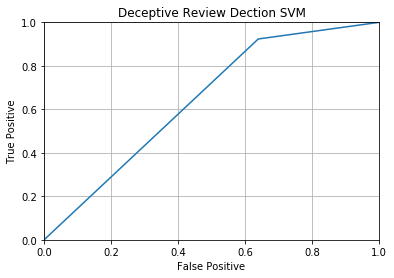

In [15]:
# draw ROC curve
fpr, tpr, thresholds = _roc_curve(test_set['likes'], predic)

_plt.plot(fpr,tpr)
_plt.xlim([0.0,1.0])
_plt.ylim([0.0,1.0])

_plt.title("Deceptive Review Dection SVM")
_plt.xlabel("False Positive")
_plt.ylabel("True Positive")

_plt.grid(True)
_plt.show()

In [17]:
_jl.dump(best_model, "../models/best_SVM.joblib")

['../models/best_SVM.joblib']

In [ ]:
%reset

### 6.2 Random Forest Classifier

(see the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html))

In [ ]:
train_set = _pd.read_pickle('../dataset/m2_n9/model_train_set_3.pickle')
train_set.head()

In [ ]:
#sub_train_set = train_set[:round(train_set.shape[0]/3)]
sub_train_set = train_set
del train_set
sub_train_set.shape

In [ ]:
random_forest = RandomForestClassifier(n_jobs = 2, random_state = 0)
random_forest.get_params()

In [ ]:
# fine tune classifier
# param_grid = {'C':[0.001,0.01,0.1,0.25,0.5,0.75,1,10,100,1000], 'gamma':[3,2,1,0.1,0.001,0.0001]}
#param_grid = {'C':[0.001,0.01,0.1,0.25,0.5,0.75,1,10,100,1000]}
# grid = _GridSearchCV(estimator=svc_classifier, param_grid=param_grid, refit=True, verbose=2, cv=3, error_score=_np.nan, n_jobs=1, pre_dispatch=1)
param_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

grid = _GridSearchCV(estimator=random_forest, param_grid=param_grid, refit=True, verbose=2, cv=3, error_score=_np.nan, n_jobs=-1, pre_dispatch=6)
grid.fit(sub_train_set.drop(columns=['likes', 'stars_review', 'review_id', 'user_id', 'business_id']), sub_train_set['likes'])
print("best params:", grid.best_params_, "- best score:", grid.best_score_)

In [ ]:
print("results:", grid.cv_results_)

In [ ]:
del sub_train_set
train_set = _pd.read_pickle('../dataset/m2_n9/model_train_set_3.pickle')

In [ ]:
#Idealmente si può reinstanziare un nuovo classificatore con i best params invece di utilizzare grid.best_estimator
#Questo perche ci sono alcuni parametri non presi in considerazione nel grid search di random forest come n_jobs per
#andare in parallelo, la verbosità ecc.

Quello che dico nella cella sopra lo fanno [qua](https://www.kaggle.com/sociopath00/random-forest-using-gridsearchcv)

In [ ]:
best_model = grid.best_estimator_
best_model.fit(train_set.drop(columns=['likes', 'stars_review', 'review_id', 'user_id', 'business_id']), train_set['likes'])

In [ ]:
print("coef:", best_model.coef_)
print("intercept:", best_model.intercept_)

In [ ]:
del train_set
test_set = _pd.read_pickle('../dataset/m2_n9/model_test_set_3.pickle')
test_set.head()

In [ ]:
# test classifier
predic = best_model.predict(test_set.drop(columns=['likes', 'stars_review', 'review_id', 'user_id', 'business_id']))
print("predictions:\n", predic)

In [ ]:
# evaluate classifier

print("Report for Random Forest classifier:")
print(_classification_report(test_set['likes'], predic))

print("Accuracy for Random Forest Classifier:", _accuracy_score(test_set['likes'], predic)*100)

In [ ]:
# Confusion matrix for SVC

print("Confusion Matrix for Random Forest before balance the data: ")
_confusion_matrix(test_set['likes'], predic)

In [ ]:
# draw ROC curve
fpr, tpr, thresholds = _roc_curve(test_set['likes'], predic)

_plt.plot(fpr,tpr)
_plt.xlim([0.0,1.0])
_plt.ylim([0.0,1.0])

_plt.title("Deceptive Review Dection Random Forest")
_plt.xlabel("False Positive")
_plt.ylabel("True Positive")

_plt.grid(True)
_plt.show()

In [ ]:
%reset